#### *Please refer to the uploaded .html file if any of the plots are not displayed correctly.

## Data Preprocessing

### Import Packages and Loading Data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time

master_tm = time.time()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

try:
    from pmdarima.arima import auto_arima
    import plotly.graph_objects as go
except:
    !pip install pmdarima --y
    !pip install plotly --y
    from pmdarima.arima import auto_arima
    import plotly.graph_objects as go

In [2]:
# Load dataset
df = pd.read_csv('Financial_Info_SG_Firms_Combined.csv', header=0)

# Remove all empty columns
df.dropna(axis=1, how='all', inplace=True)

print(df.isna().sum())
df

serial number                                                0
Worldscope Permanent ID                                      0
DS_CODE                                                      0
ADR CUSIP 1                                              51686
ADR CUSIP 2                                              53234
                                                         ...  
Unrealized Valuation Gains/Losses Investments            51741
Unrealized Valuation Gains/Losses Investment Property    51792
Unrealized Valuation Gains/Losses Biological Assets      53072
Unrealized Valuation Gains/Losses Hedges/Derivatives     51519
Unrealized Valuation Gains/Losses Other                  53094
Length: 1247, dtype: int64


serial number Worldscope Permanent ID DS_CODE ADR CUSIP 1  ADR CUSIP 2  \
0                  1               C702B7140  13039P         NaN          NaN   
1                 44               C702L6360  13439K         NaN          NaN   
2                 87               C702L5920  13440J         NaN          NaN   
3                130               C15683S10  13931M         NaN          NaN   
4                173               C702H3870  140010         NaN          NaN   
...              ...                     ...     ...         ...          ...   
53272          53105               C45825610  998571         NaN          NaN   
53273          53148               C702CW520  998573         NaN          NaN   
53274          53191               C70257880  998675         NaN          NaN   
53275          53234               C70259470  998687         NaN          NaN   
53276          53277               C70282760  998697         NaN          NaN   

        Acronym     Address City Address State  Alpha (Security)  Beta (WS)  \
0           NaN              NaN           NaN             -0.49       1.23   
1           NaN              NaN           NaN             -2.00       1.17   
2           NaN        Singapore           NaN               NaN        NaN   
3           NaN          BEIJING       Beijing               NaN        NaN   
4           NaN              NaN           NaN              1.50       0.84   
...         ...              ...           ...               ...        ...   
53272       NaN  62502 Putrajaya           NaN               NaN        NaN   
53273  SPURAFIN              NaN           NaN             -0.83       0.26   
53274       NaN              NaN           NaN               NaN        NaN   
53275       NaN              NaN           NaN               NaN        NaN   
53276       NaN              NaN           NaN             -0.53       0.39   

       ...  Unconsolidated/Parent Company Net Profit  \
0      ...                                       NaN   
1      ...                                       NaN   
2      ...                                       NaN   
3      ...                                       NaN   
4      ...                                       NaN   
...    ...                                       ...   
53272  ...                                       NaN   
53273  ...                                       NaN   
53274  ...                                       NaN   
53275  ...                                       NaN   
53276  ...                                       NaN   

      Unconsolidated/Parent Company Pretax Earnings Per Share  \
0                                                    NaN        
1                                                    NaN        
2                                                    NaN        
3                                                    NaN        
4                                                    NaN        
...                                                  ...        
53272                                                NaN        
53273                                                NaN        
53274                                                NaN        
53275                                                NaN        
53276                                                NaN        

      Weighted Cost Of Debt  Unrealized Valuation Gains/Losses Total  \
0                       NaN                                      NaN   
1                       NaN                                      NaN   
2                       NaN                                      NaN   
3                       NaN                                      NaN   
4                       NaN                                      NaN   
...                     ...                                      ...   
53272                   NaN                                      NaN   
53273                   NaN                            

       x    y
0   1.00   24
1   0.95   37
2   0.90   42
3   0.85   48
4   0.80   49
5   0.75   56
6   0.70   59
7   0.65   71
8   0.60   85
9   0.55   92
10  0.50   95
11  0.45   99
12  0.40  101
13  0.35  102
14  0.30  214
15  0.25  355
16  0.20  445
17  0.15  540
18  0.10  595
19  0.05  641


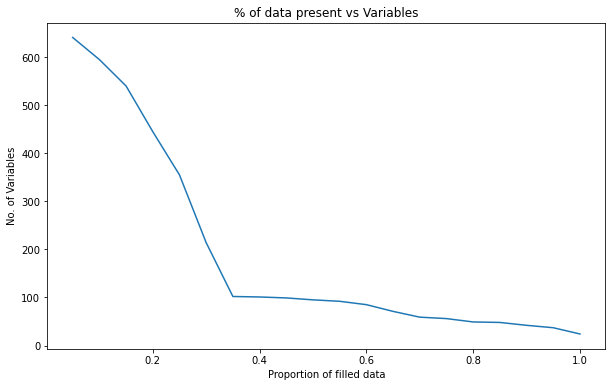

In [3]:
# Visualize number of variables and their proportion of NaN values
x = []
y = []

for i in np.arange(0,1,0.05):
    vars = len(list(df.columns[df.isna().sum()<=i*len(df)]))
    x.append(np.round(1-i,2))
    y.append(vars)

print(pd.DataFrame({'x':x,'y':y}))

plt.figure(figsize=(10,6))
plt.plot(x,y)
plt.title('% of data present vs Variables')
plt.xlabel('Proportion of filled data')
plt.ylabel('No. of Variables')
plt.show()

### Variable Selection

In [4]:
# Numerical Data
for item in list(df.dtypes[df.dtypes!='object'].index):
    print(item)

serial number
ADR CUSIP 2
Alpha (Security)
Beta (WS)
Book Value Per Share - Current (Security)
Cash Flow Per Share - Current (Security)
Closely Held Shares - Current
Common / Ordinary Shareholders
Common Shares Outstanding - Current (Security)
Date Added To Product
Date Company Founded
Date Of Closely Held Shares
Date Of Common Shares
Date Of Common/Ordinary Shareholders
Date Of Current Price (Security)
Date Of Incorporation
Date Of Last 12 Months EPS (Security)
Dividend Payout Per Share - Current (Security)
Dividend Yield - Current (Security)
Dividends Per Share - Last 12 Months (Security)
EPS - Last 12 Months (Security)
Earnings Yield - Current (Security)
Earnings Yield - Current High (Security)
Earnings Yield - Current Low (Security)
General Industry Classification (Key Item)
Inactive Date (Security)
Indicated Dividend Rate (Security)
Industry Classification Benchmark
Industry Group
Latest Annual Updated (Key Item)
Latest Interim Date (Key Item)
Latest Reuters  Data Year
Market Capi

Receivables (Net)
Raw Materials
Progress Payments And Other
Redeemable Preferred Stock
Real Estate Assets
Real Estate Mortgage Loans
Reserve For Loan Losses
Property, Plant And Equipment Gross
Property, Plant And Equipment Net
Provisions For Risks And Charges
Revaluation Reserves
Retained Earnings
Reduction In Long Term Debt
Quick Ratio
Quick Ratio 5 Year Average
Receivables % Total Current Assets
Receivables % Total Current Assets 5 Year Average
Return On Equity Total %
Return On Equity Per Share Fiscal
Return On Equity Total % 5 Year Average
Return On Assets
Return On Assets 5 Year Average
Research & Development/Sales
Research & Development/Sales 5 Year Average
Return On Equity Per Share
Return On Equity Per Share 5 Year Average
Return On Invested Capital
Return On Invested Capital 5 Year Average
Reinvestment Rate Per Share 1 Year
Reinvestment Rate Per Share Fiscal
Reinvestment Rate Per Share 5 Year Average
Reinvestment Rate Total $ 1 Yr
Reinvestment Rate Total $ 5 Year Average
Retai

In [5]:
# Categorical Data
for item in list(df.dtypes[df.dtypes=='object'].index):
    print(item)

Worldscope Permanent ID
DS_CODE
ADR CUSIP 1
Acronym
Address City
Address State
Buildings
Business Description - Extended (Key Item)
Company Name (Security)
Company Name - Short (Security)
Cusip (Security)
Disclosure Company Identifer
Entity Type (Key Item)
Fax Number
Indicator - Adr
Indicator - Currently A Mult-Share Company (Key Item)
Indicator - Limited Data Set Company (Key Item)
Indicator - Non-Traded Company/Security
Indicator - Reuters Data Company
Internet Address
Investor Relations - Address
Investor Relations - Email Address
Investor Relations - Name
Investor Relations - Phone/Fax
Isin Number (Security)
Major Shareholders
Month Of Fiscal Year End
Nation (Security)
Officer 1 Name
Officer 2 Name
Officer 3 Name
Officer 4 Name
Officer 5 Name
Parent Auditor 1
Parent Auditor 1 - Affiliate 1
Parent Auditor 1 - Affiliate 2
Parent Auditor 2
Parent Auditor 2 - Affiliate 1
Parent Auditor 4 - Affiliate 1
Phone Number
Post Code / Zip Code
Post Office Box
Products
Region
Sedol Number (Secur

In [6]:
# Manual Variable Selection and Checking Empty Values
df2 = df[['Alpha (Security)',
          'Beta (WS)',
          'Cash Flow Per Share - Current (Security)',
          'EPS - Last 12 Months (Security)',
          'Market Capitalisation - Current (Security)',
          'Book Value Per Share - Current (Security)',
          'Market Price - Current (Security)',
          'Reinvestment Rate - Per Share - Current',
          'Year',
          'Enterprise Value',
          'Net Sales Or Revenues',
          'Retained Earnings',
          'Total Assets',
          'Total Liabilities',
          'Total Shareholders Equity',
          'Company Name (Security)',
          'General Industry Classification (Key Item)']].copy()

df2.isna().sum()

Alpha (Security)                              26918
Beta (WS)                                     26918
Cash Flow Per Share - Current (Security)      17673
EPS - Last 12 Months (Security)               17630
Market Capitalisation - Current (Security)    17114
Book Value Per Share - Current (Security)     17630
Market Price - Current (Security)             10836
Reinvestment Rate - Per Share - Current       19264
Year                                              0
Enterprise Value                              37492
Net Sales Or Revenues                         35939
Retained Earnings                             39144
Total Assets                                  36017
Total Liabilities                             36019
Total Shareholders Equity                     36006
Company Name (Security)                           0
General Industry Classification (Key Item)        0
dtype: int64

In [7]:
# Drop rows with NaN values
df3 = df2.dropna(axis=0, how='any', inplace=False).reset_index(drop=True).copy()
df3

Alpha (Security)  Beta (WS)  Cash Flow Per Share - Current (Security)  \
0                -0.57       0.76                                    -0.035   
1                 0.60       1.17                                     0.223   
2                -0.12       0.30                                     0.197   
3                -0.57       0.76                                    -0.035   
4                -0.15       0.63                                     0.228   
...                ...        ...                                       ...   
7744             -0.32       0.71                                     0.224   
7745             -0.83       0.56                                     0.106   
7746             -1.96       3.57                                     0.000   
7747             -0.83       0.26                                     0.040   
7748             -0.53       0.39                                     0.112   

      EPS - Last 12 Months (Security)  \
0                              -0.017   
1                               0.077   
2                               0.220   
3                              -0.017   
4                               0.164   
...                               ...   
7744                            0.146   
7745                            0.117   
7746                           -0.093   
7747                            0.012   
7748                            0.193   

      Market Capitalisation - Current (Security)  \
0                                      1005851.0   
1                                       378118.0   
2                                      3874113.0   
3                                      1005851.0   
4                                      5942471.0   
...                                          ...   
7744                                    963011.0   
7745                                   3216016.0   
7746                                     35451.0   
7747                                    133296.0   
7748                                    629789.0   

      Book Value Per Share - Current (Security)  \
0                                         0.248   
1                                         0.626   
2                                         4.242   
3                                         0.248   
4                                         2.178   
...                                         ...   
7744                                      3.832   
7745                                      1.717   
7746                                      0.082   
7747                                      1.576   
7748                                      2.857   

      Market Price - Current (Security)  \
0                                 0.200   
1                                 0.345   
2                                 2.730   
3                                 0.200   
4                                 3.680   
...                                 ...   
7744                              2.170   
7745                              2.260   
7746                              0.070   
7747                              0.840   
7748                              1.490   

      Reinvestment Rate - Per Share - Current  Year  Enterprise Value  \
0                                       -6.52  1984          165444.0   
1                                        9.85  1984          110246.0   
2                                        4.52  1984          217583.0   
3                                       -6.52  1985           -4533.0   
4                                        0.64  1985         1278577.0   
...                                       ...   ...               ...   
7744                                     1.22  2015         -460989.0   
7745                                    -0.74  2015         4153613.0   
7746                                   -80.83  2015           28165.0   
7747                                    -0.49  2015          146775.0   
7748  

### Creating Dummy Variables

In [8]:
# Create dummy variables for categorical variables
num_vars = list(df3.columns)[:-2]
num_vars.remove('Year')
cat_vars = list(df3.columns)[-1:]
id_vars = ['Year'] + list(df3.columns)[-2:-1]

quantitative_data = df3[num_vars].copy()
categorical_data = df3[cat_vars].copy()
categorical_data.astype('category')

dummy = pd.get_dummies(categorical_data, columns=list(categorical_data.columns))
df_regression = pd.concat([quantitative_data,dummy],axis=1)
df_regression = pd.concat([df_regression.pop('Market Price - Current (Security)'),df_regression], axis=1)
df_regression

Market Price - Current (Security)  Alpha (Security)  Beta (WS)  \
0                                 0.200             -0.57       0.76   
1                                 0.345              0.60       1.17   
2                                 2.730             -0.12       0.30   
3                                 0.200             -0.57       0.76   
4                                 3.680             -0.15       0.63   
...                                 ...               ...        ...   
7744                              2.170             -0.32       0.71   
7745                              2.260             -0.83       0.56   
7746                              0.070             -1.96       3.57   
7747                              0.840             -0.83       0.26   
7748                              1.490             -0.53       0.39   

      Cash Flow Per Share - Current (Security)  \
0                                       -0.035   
1                                        0.223   
2                                        0.197   
3                                       -0.035   
4                                        0.228   
...                                        ...   
7744                                     0.224   
7745                                     0.106   
7746                                     0.000   
7747                                     0.040   
7748                                     0.112   

      EPS - Last 12 Months (Security)  \
0                              -0.017   
1                               0.077   
2                               0.220   
3                              -0.017   
4                               0.164   
...                               ...   
7744                            0.146   
7745                            0.117   
7746                           -0.093   
7747                            0.012   
7748                            0.193   

      Market Capitalisation - Current (Security)  \
0                                      1005851.0   
1                                       378118.0   
2                                      3874113.0   
3                                      1005851.0   
4                                      5942471.0   
...                                          ...   
7744                                    963011.0   
7745                                   3216016.0   
7746                                     35451.0   
7747                                    133296.0   
7748                                    629789.0   

      Book Value Per Share - Current (Security)  \
0                                         0.248   
1                                         0.626   
2                                         4.242   
3                                         0.248   
4                                         2.178   
...                                         ...   
7744                                      3.832   
7745                                      1.717   
7746                                      0.082   
7747                                      1.576   
7748                                      2.857   

      Reinvestment Rate - Per Share - Current  Enterprise Value  \
0                                       -6.52          165444.0   
1                                        9.85          110246.0   
2                                        4.52          217583.0   
3                                       -6.52           -4533.0   
4                                        0.64         1278577.0   
...                                       ...               ...   
7744                                     1.22         -460989.0   
7745                                    -0.74         4153613.0   
7746                                   -80.83           28165.0   
7747                                    -0.49          146775.0   
7748                                     4.64          733654.0   

    

### Data Visualization & Further Variable Selection

#### Univariate Analysis

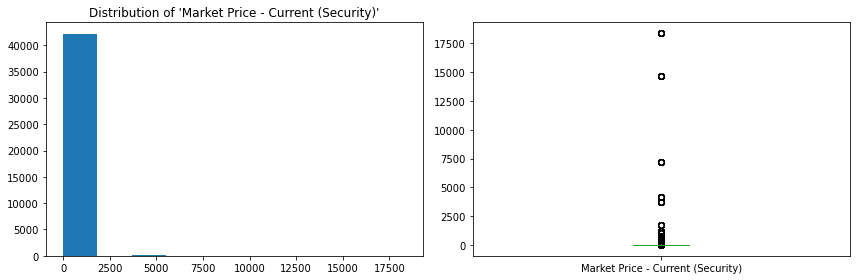

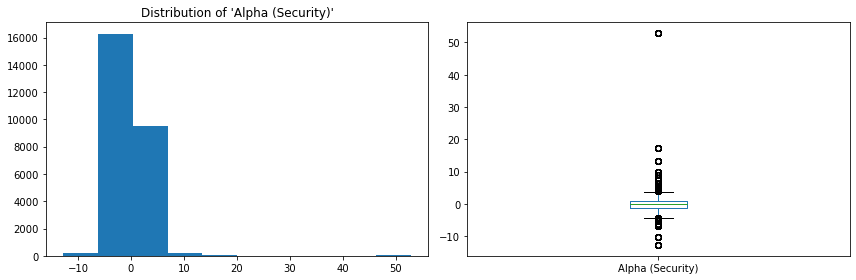

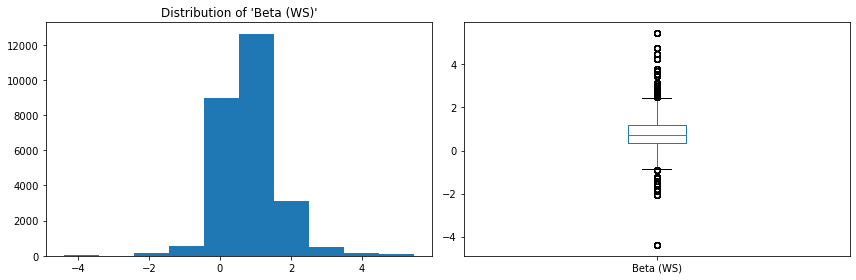

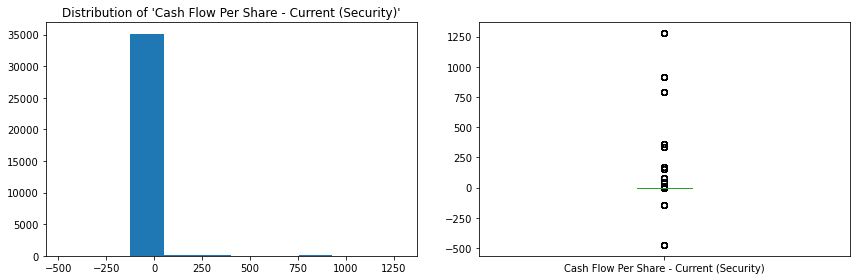

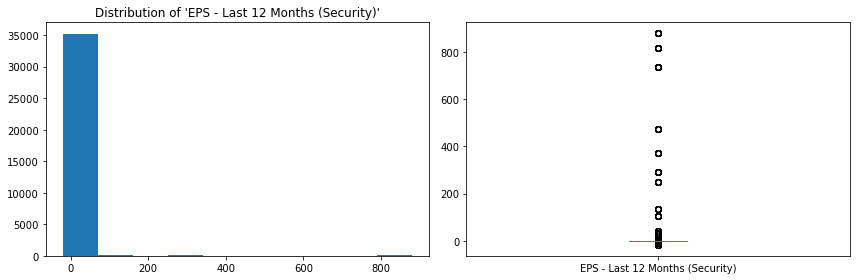

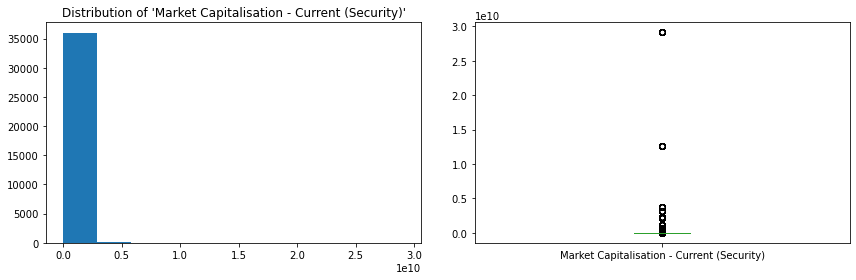

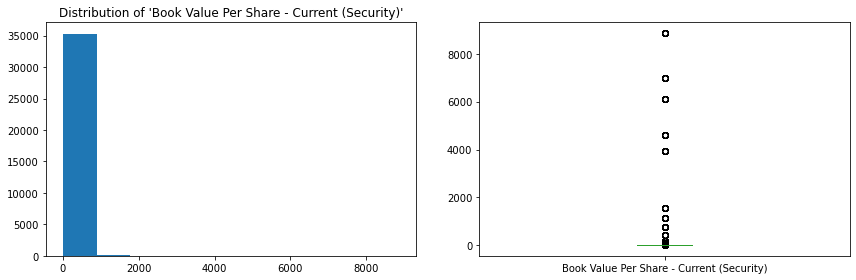

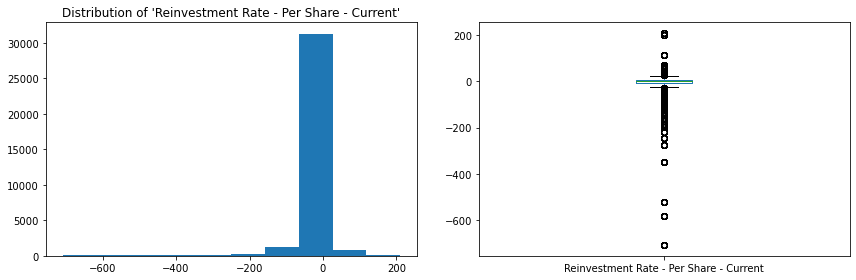

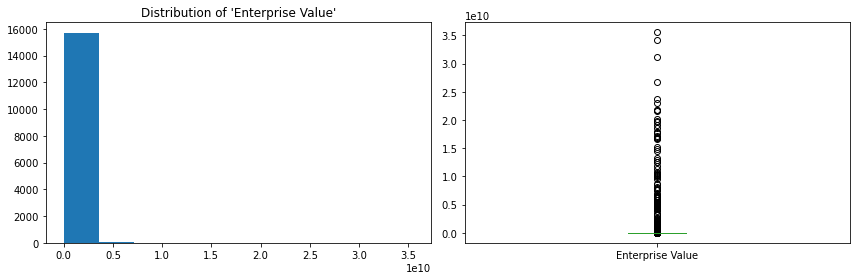

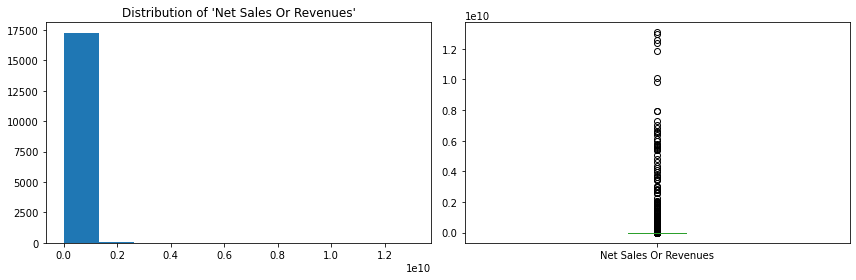

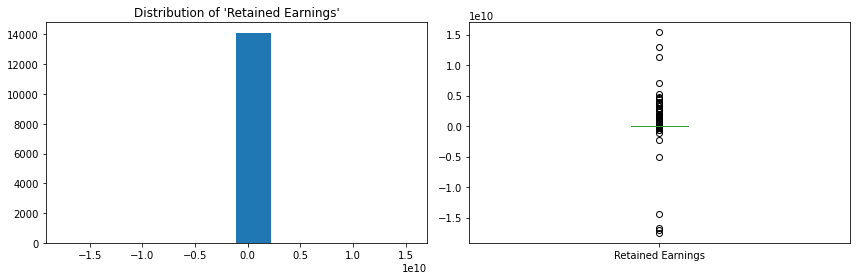

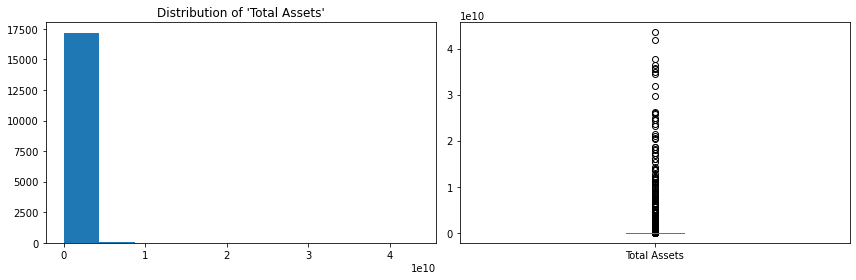

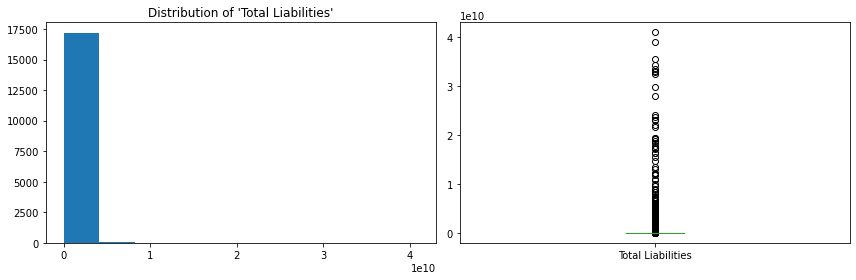

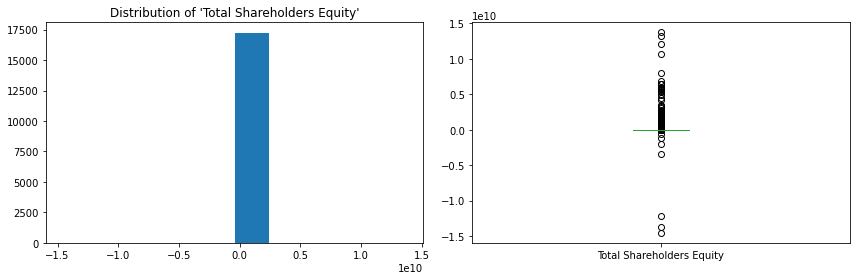

In [9]:
# Univariate Analysis - Understanding distribution and shape of each variable
for col in list(df_regression.columns)[:-6]:
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    if col in cat_vars:
        axes[0].bar(x=list(df[col].value_counts().index), 
                    height=list(df[col].value_counts().values))
        #axes[0].set_ylim([y_min, y_max])
    else:
        df[col].hist(ax = axes[0], grid=False)
    
    axes[0].set_title('Distribution of \''+ col + '\'')
    
    df.boxplot(column = col, ax = axes[1], grid=False)
    plt.tight_layout()
    plt.show()


#### Bivariate Analysis

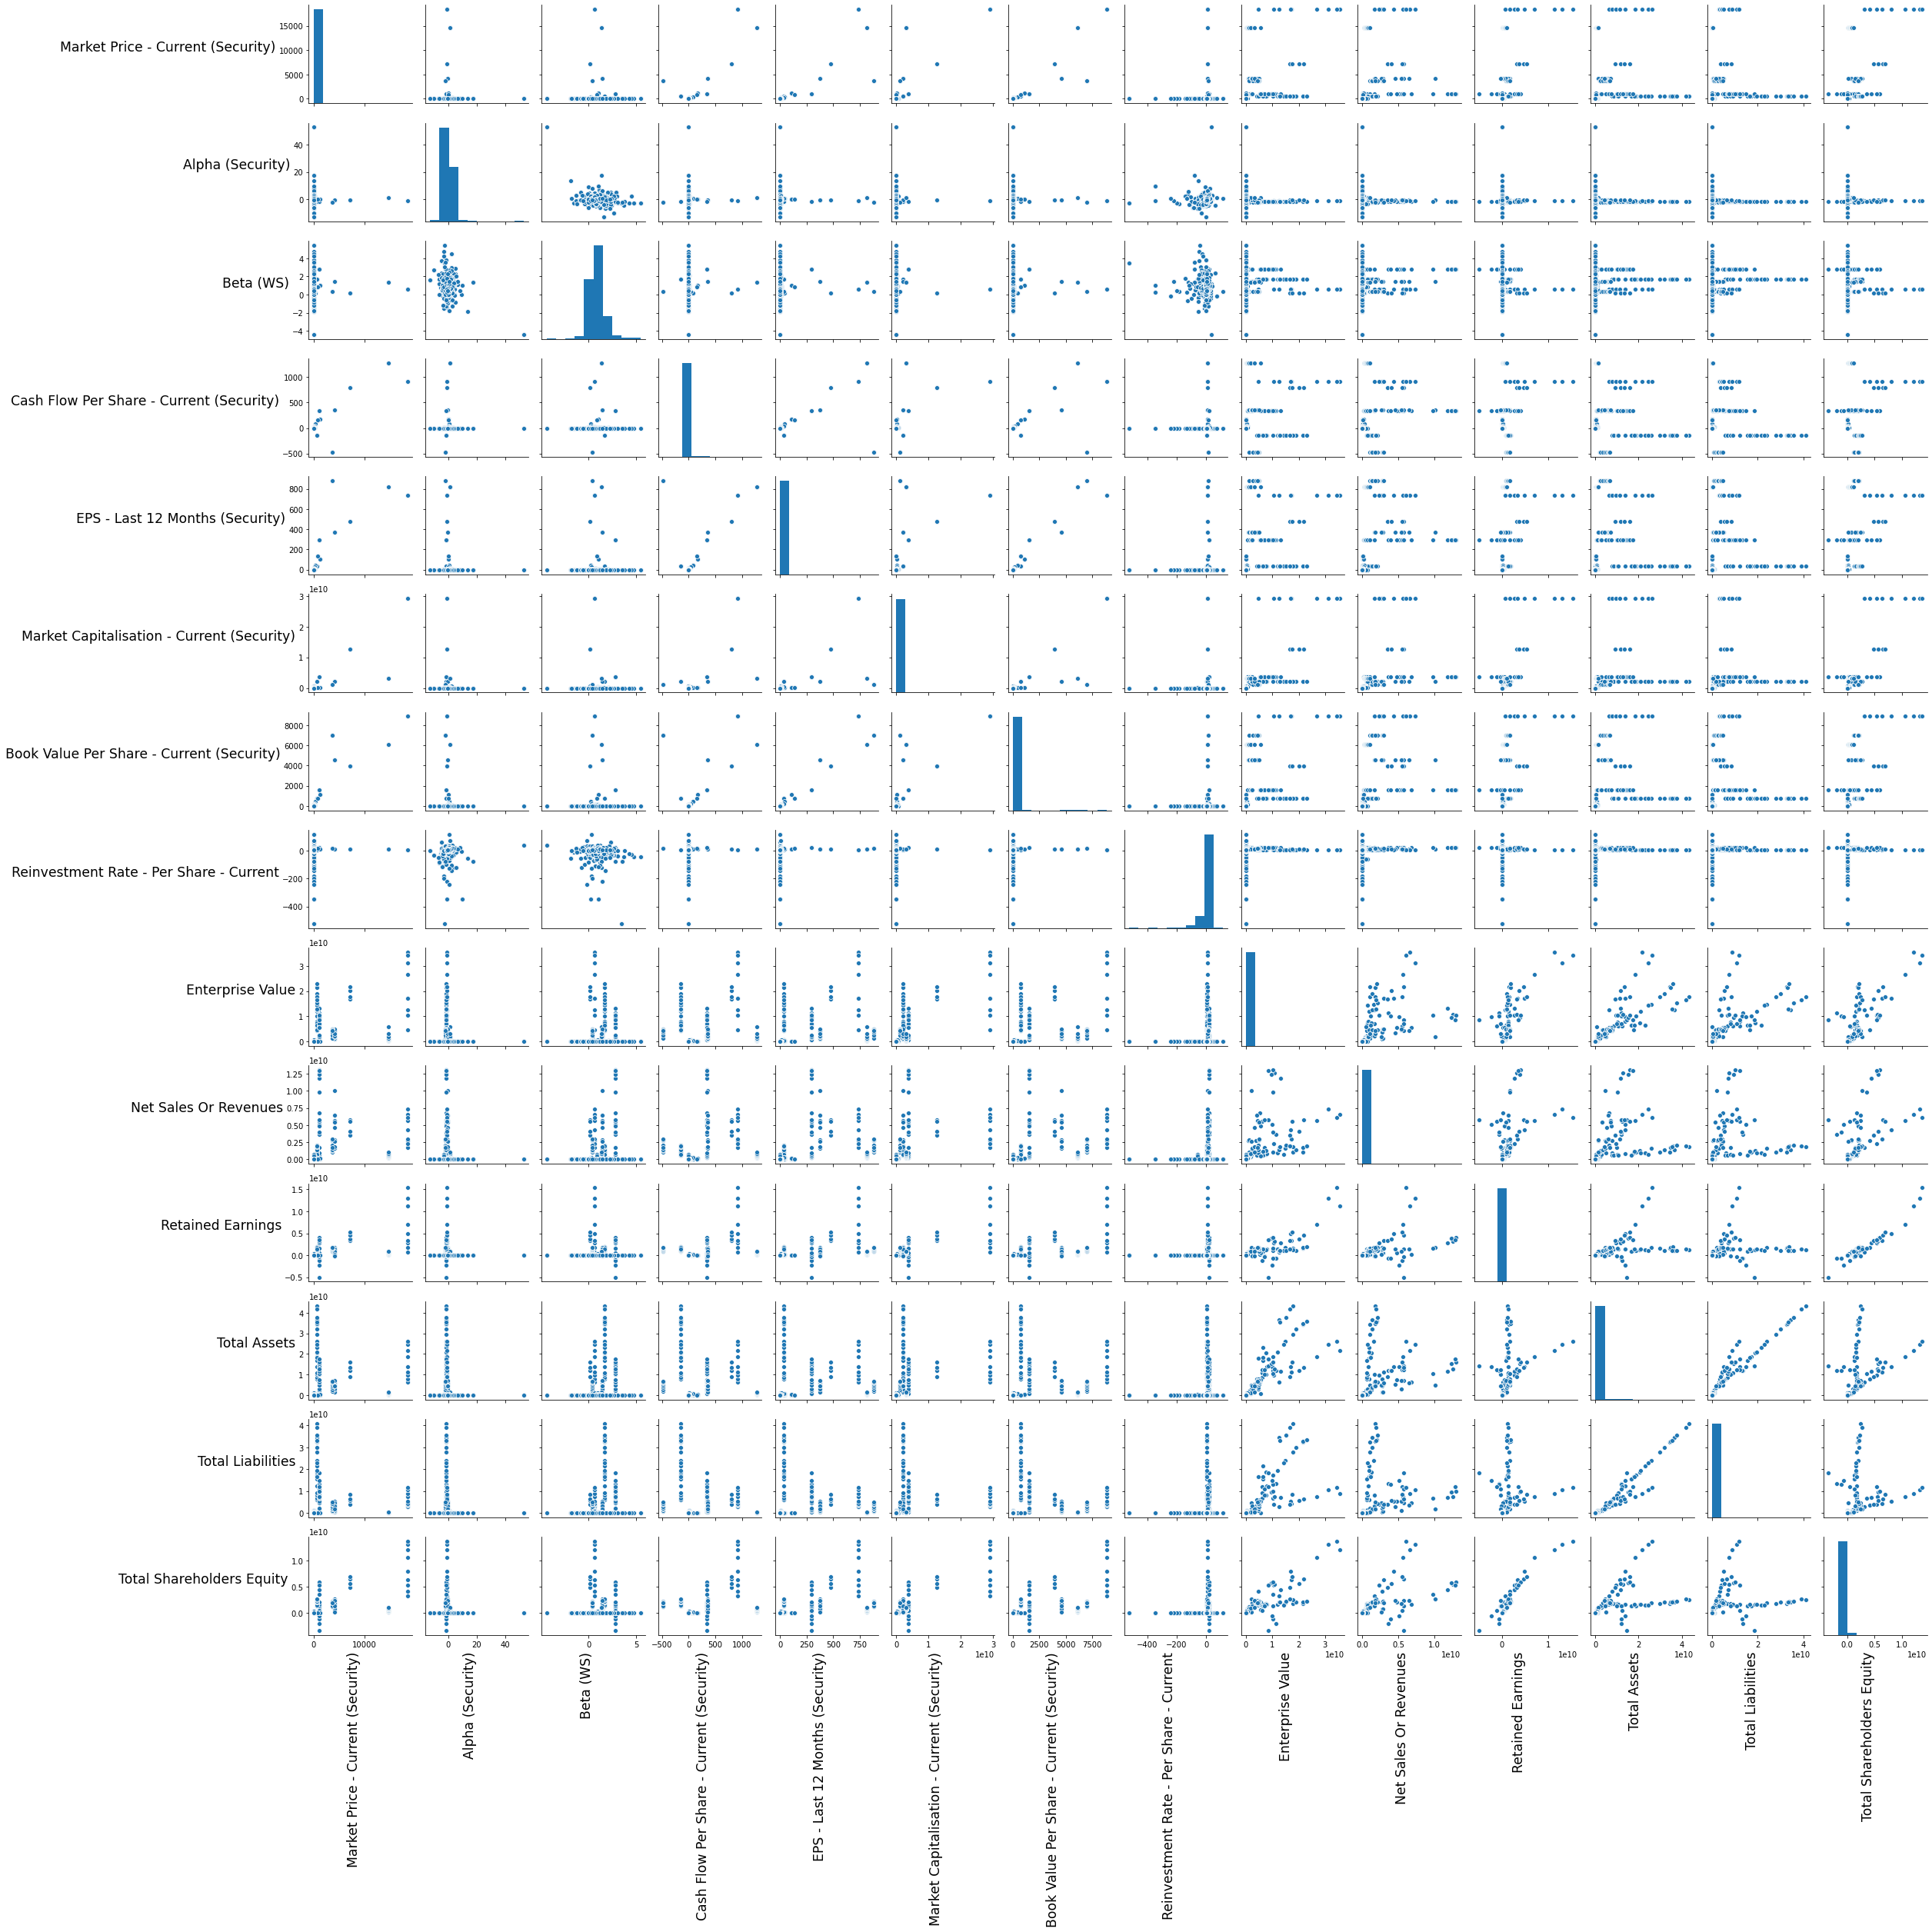

In [10]:
# Bivariate Analysis - Understanding the pairwise relationship between variables
train_set_duplicated = df_regression.iloc[:,:-6].copy()
chart = sns.pairplot(train_set_duplicated)

chart.fig.draw(chart.fig.canvas.get_renderer())

for ax in chart.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, fontsize='xx-large')
    ax.set_ylabel(ax.get_ylabel(), rotation=0, fontsize='xx-large')
    ax.yaxis.get_label().set_horizontalalignment('right')
    ax.xaxis.get_label().set_horizontalalignment('right')

plt.tight_layout()

#### Correlation Matrix (Heatmap)

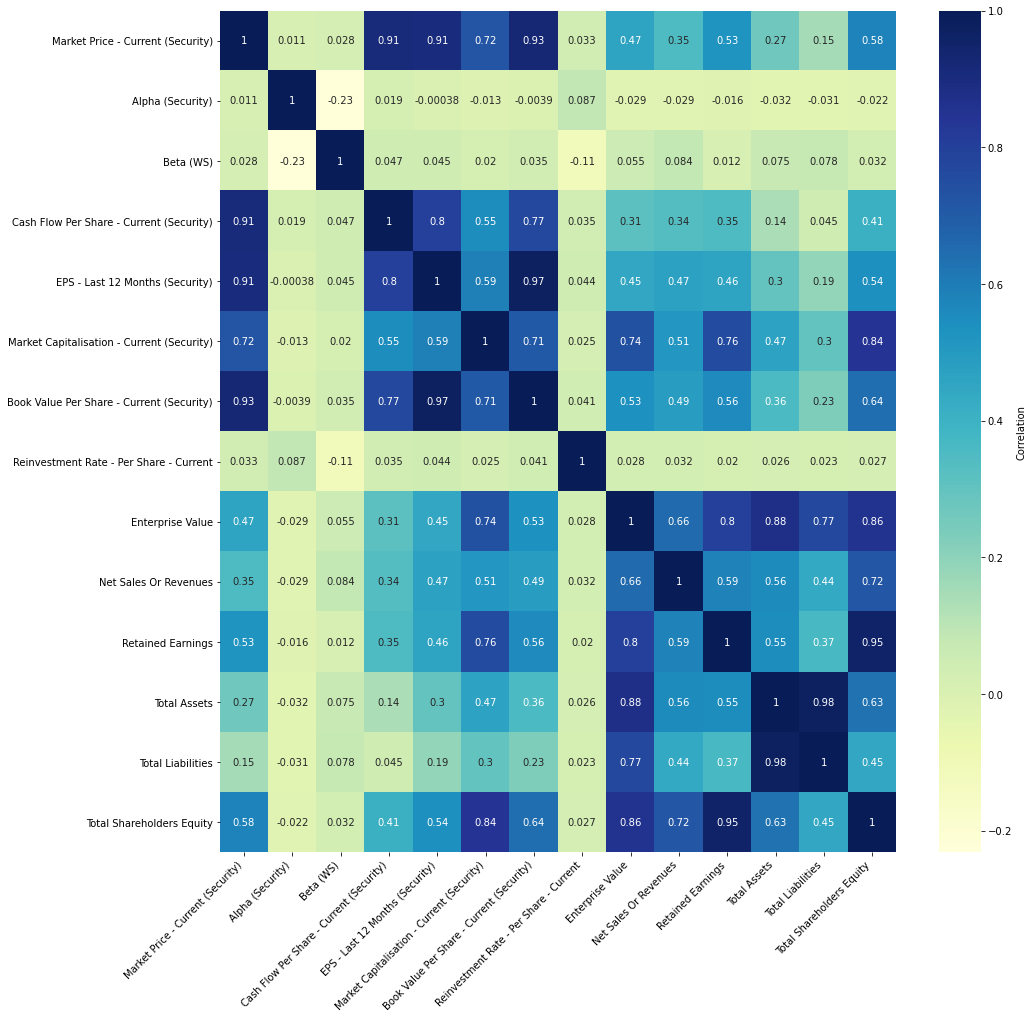

<Figure size 432x288 with 0 Axes>

In [11]:
# Correlation Matrix (Heatmap)
corr = df_regression.iloc[:,:-6].corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

In [12]:
# Further variable selection to exclude variables with high correlation
df_regression.drop(columns=['Total Shareholders Equity',
                            'Enterprise Value',
                            'EPS - Last 12 Months (Security)',
                            'Total Assets'], inplace=True)
df_regression

Market Price - Current (Security)  Alpha (Security)  Beta (WS)  \
0                                 0.200             -0.57       0.76   
1                                 0.345              0.60       1.17   
2                                 2.730             -0.12       0.30   
3                                 0.200             -0.57       0.76   
4                                 3.680             -0.15       0.63   
...                                 ...               ...        ...   
7744                              2.170             -0.32       0.71   
7745                              2.260             -0.83       0.56   
7746                              0.070             -1.96       3.57   
7747                              0.840             -0.83       0.26   
7748                              1.490             -0.53       0.39   

      Cash Flow Per Share - Current (Security)  \
0                                       -0.035   
1                                        0.223   
2                                        0.197   
3                                       -0.035   
4                                        0.228   
...                                        ...   
7744                                     0.224   
7745                                     0.106   
7746                                     0.000   
7747                                     0.040   
7748                                     0.112   

      Market Capitalisation - Current (Security)  \
0                                      1005851.0   
1                                       378118.0   
2                                      3874113.0   
3                                      1005851.0   
4                                      5942471.0   
...                                          ...   
7744                                    963011.0   
7745                                   3216016.0   
7746                                     35451.0   
7747                                    133296.0   
7748                                    629789.0   

      Book Value Per Share - Current (Security)  \
0                                         0.248   
1                                         0.626   
2                                         4.242   
3                                         0.248   
4                                         2.178   
...                                         ...   
7744                                      3.832   
7745                                      1.717   
7746                                      0.082   
7747                                      1.576   
7748                                      2.857   

      Reinvestment Rate - Per Share - Current  Net Sales Or Revenues  \
0                                       -6.52              1259231.0   
1                                        9.85               128317.0   
2                                        4.52               103738.0   
3                                       -6.52              1421395.0   
4                                        0.64               566844.0   
...                                       ...                    ...   
7744                                     1.22               309082.0   
7745                                    -0.74              2767010.0   
7746                                   -80.83                32317.0   
7747                                    -0.49                33193.0   
7748                                     4.64               270867.0   

      Retained Earnings  Total Liabilities  \
0                4588.0           157424.0   
1              -13441.0            31201.0   
2               68809.0            89197.0   
3                9889.0           316612.0   
4               24616.0           285446.0   
...                 ...                ...   
7744           808832.0         11598093.0   
7745           292256.0          1160031.0   
7746           -53115.0

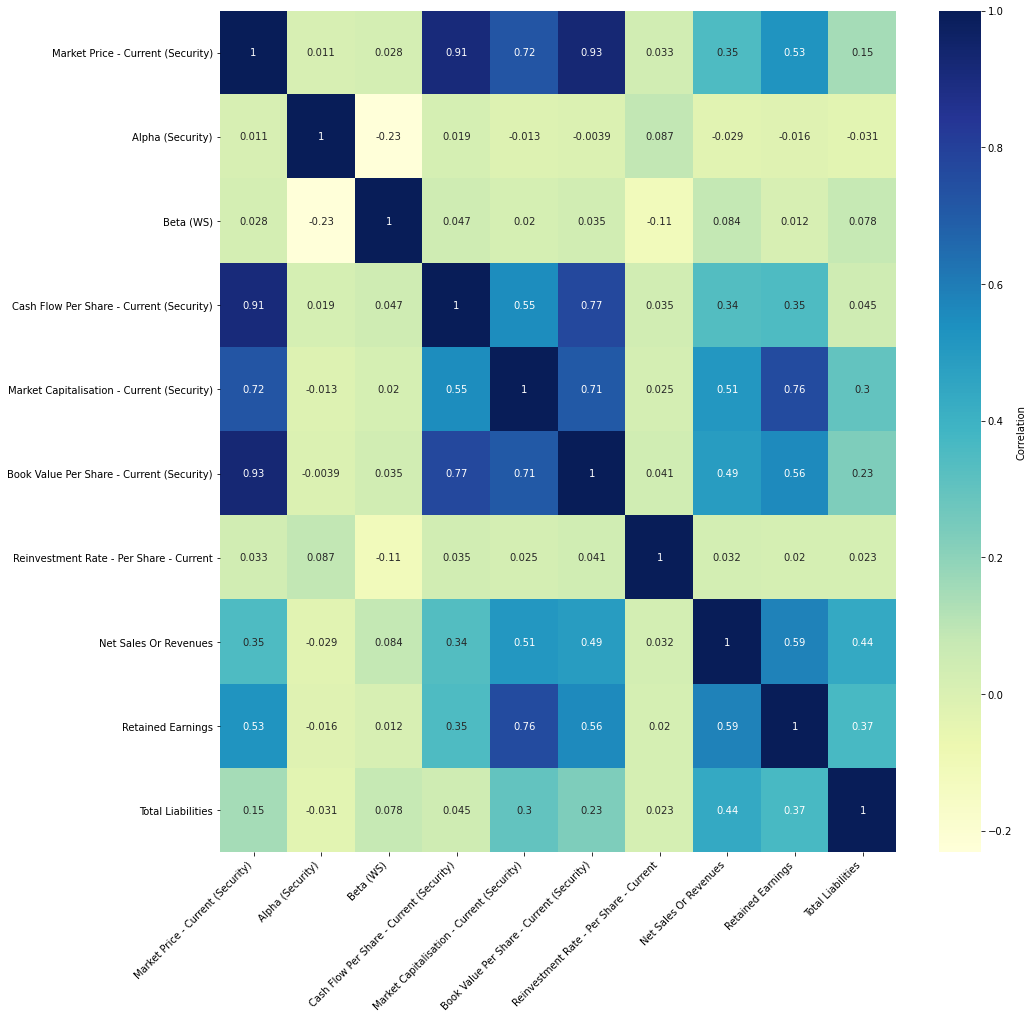

<Figure size 432x288 with 0 Axes>

In [13]:
# Correlation Matrix (Heatmap)
corr = df_regression.iloc[:,:-6].corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

### Data Preparation for Time Series

In [14]:
# Identifying Company for Time Series
company_list = []
dataset_len = []
non_empty_len = []

for company in set(df2['Company Name (Security)']):
    temp = df2[df2['Company Name (Security)']==company].copy()

    company_list.append(company)
    dataset_len.append(len(temp))

    temp.dropna(axis=0, how='any', inplace=True)
    non_empty_len.append(len(temp))

df_summary = pd.DataFrame({'company':company_list,
                           'dataset_length':dataset_len,
                           'non_empty':non_empty_len})
df_summary.sort_values(by=['non_empty'], ascending=False, inplace=True)
df_summary.reset_index(drop=True, inplace=True)
df_summary

company  dataset_length  non_empty
0                  UNITED ENGINEERS LIMITED              43         30
1                            PRUDENTIAL PLC              43         29
2                  BURWILL HOLDINGS LIMITED              43         29
3                        COMFORT GLOVES BHD              43         28
4     UNITED INDUSTRIAL CORPORATION LIMITED              43         28
...                                     ...             ...        ...
1230           KIAN ANN ENGINEERING LIMITED              43          0
1231                     STRATECH GROUP LTD              43          0
1232            OVERSEAS UNION BANK LIMITED              43          0
1233             PEOPLE'S FOOD HOLDINGS LTD              43          0
1234                       CHINA ENERGY LTD              43          0

[1235 rows x 3 columns]

In [15]:
# Company and Feature Selection for Time Series Analysis
df_timeseries = df[['Company Name (Security)',
                    'Year',
                    'Net Sales Or Revenues',
                    'Straits Times Index Year Close',
                    'Singapore Real interest rate (%)',
                    'United States Real interest rate (%)',
                    'Common Shares Outstanding']].copy()
df_timeseries = df_timeseries[df_timeseries['Company Name (Security)']=='UNITED ENGINEERS LIMITED'].dropna(axis=0, how='any', inplace=False).reset_index(drop=True)
df_timeseries = df_timeseries.drop(columns=['Company Name (Security)']).iloc[-30:,:].reset_index(drop=True)
df_timeseries

Year  Net Sales Or Revenues  Straits Times Index Year Close  \
0   1986                38907.0                          891.30   
1   1987                31205.0                          823.58   
2   1988                29633.0                         1038.62   
3   1989                51496.0                         1481.33   
4   1990               124263.0                         1154.48   
5   1991               140914.0                         1490.70   
6   1992               218293.0                         1524.40   
7   1993               240778.0                         2425.68   
8   1994               286076.0                         2239.56   
9   1995               369896.0                         2266.54   
10  1996               494227.0                         2216.79   
11  1997               431713.0                         1529.84   
12  1998               375061.0                         1392.73   
13  1999               434684.0                         2479.58   
14  2000               396961.0                         1926.83   
15  2001               441669.0                         1623.60   
16  2002               473686.0                         1341.03   
17  2003               464506.0                         1764.52   
18  2004               597719.0                         2066.14   
19  2005               667009.0                         2347.34   
20  2006               657085.0                         2985.83   
21  2007               539120.0                         3482.30   
22  2008               620102.0                         1761.56   
23  2009               703732.0                         2897.62   
24  2010               901420.0                         3190.04   
25  2011              1187112.0                         2646.35   
26  2012               595744.0                         3167.08   
27  2013              2012992.0                         3167.43   
28  2014              3209321.0                         3365.15   
29  2015              1856993.0                         2882.73   

    Singapore Real interest rate (%)  United States Real interest rate (%)  \
0                           8.175095                              6.193866   
1                           5.537964                              5.592565   
2                           0.506177                              5.590367   
3                           1.970430                              6.690695   
4                           2.545571                              6.039744   
5                           3.014366                              4.915352   
6                           4.502178                              3.884240   
7                           1.870546                              3.546689   
8                           2.336514                              4.898356   
9                           3.119200                              6.594069   
10                          4.683159                              6.324008   
11                          5.184799                              6.603407   
12                          8.883830                              7.148192   
13                          9.731647                              6.457135   
14                          1.897404                              6.844844   
15                          7.602585                              4.626757   
16                          6.290364                              3.045071   
17                          7.223124                              2.224101   
18                          1.178439                              1.604589   
19                          3.329066                              2.981357   
20                          3.404016                              4.786448   
21                         -0.553498                              5.223406   
22                          6.861239                              3.082411   
23                          2.349363                  

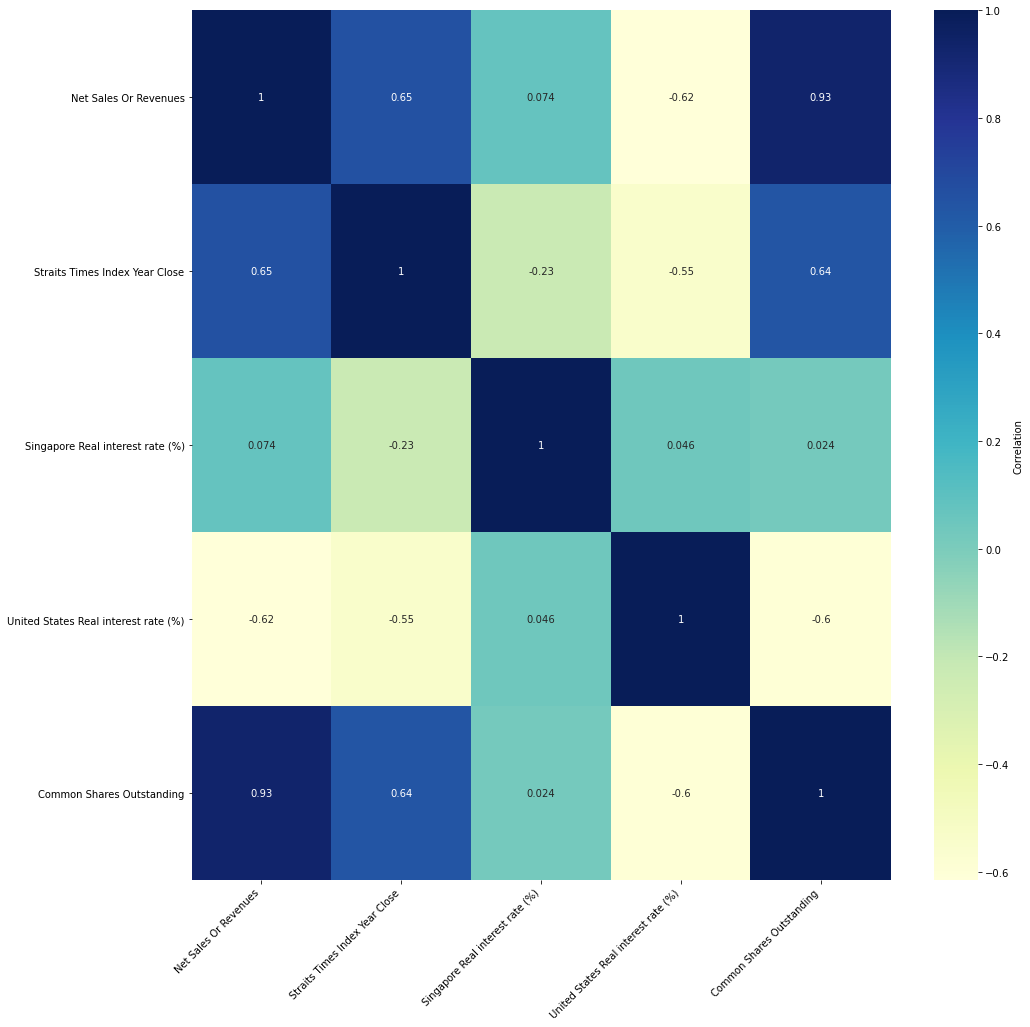

<Figure size 432x288 with 0 Axes>

In [16]:
# Correlation Matrix (Heatmap)
corr = df_timeseries.iloc[:,1:].copy()
corr = corr.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

### Data Preparation for Clustering Analysis

In [17]:
# Identifying which year to use for clustering
df5 = df2.copy()
df5.drop(columns=['General Industry Classification (Key Item)'], inplace=True)
df5 = pd.concat([df5.pop('Company Name (Security)'),df5], axis=1)

years = []
data_len = []
non_empty = []

for year in set(df5['Year']):
    temp = df5[df5['Year']==year].copy()

    years.append(year)
    data_len.append(len(temp))

    temp.dropna(axis=0, how='any', inplace=True)
    non_empty.append(len(temp))

df_summary = pd.DataFrame({'year':years,
                           'data_len':data_len,
                           'non_empty':non_empty})
df_summary.sort_values(by=['non_empty'], ascending=False, inplace=True)
df_summary.reset_index(drop=True, inplace=True)
df_summary

year  data_len  non_empty
0   2014      1239        574
1   2013      1239        566
2   2015      1239        564
3   2012      1239        531
4   2011      1239        496
5   2010      1239        484
6   2009      1239        464
7   2008      1239        444
8   2007      1239        428
9   2006      1239        399
10  2005      1239        376
11  2004      1239        357
12  2003      1239        334
13  2002      1239        302
14  2001      1239        280
15  2000      1239        232
16  1999      1239        142
17  1998      1239        108
18  1991      1239         90
19  1997      1239         79
20  1990      1239         74
21  1995      1239         72
22  1992      1239         70
23  1996      1239         69
24  1989      1239         56
25  1993      1239         53
26  1994      1239         52
27  1988      1239         24
28  1987      1239         17
29  1986      1239          5
30  1985      1239          4
31  1984      1239          3
32  1974      1239          0
33  1983      1239          0
34  1982      1239          0
35  1981      1239          0
36  1980      1239          0
37  1979      1239          0
38  1978      1239          0
39  1977      1239          0
40  1976      1239          0
41  1975      1239          0
42  1973      1239          0

In [18]:
# Selecting dataset for Clustering
df_cluster = df5[df5['Year']==2014].copy()
df_cluster.drop(columns=['Year'], inplace=True)
df_cluster.dropna(axis=0, how='any', inplace=True)
df_cluster.reset_index(drop=True, inplace=True)
df_cluster

Company Name (Security)  Alpha (Security)  Beta (WS)  \
0           AEM HOLDINGS LIMITED             -0.49       1.23   
1                     HYFLUX LTD             -2.00       1.17   
2      SHC INSURANCE PTE LIMITED              1.50       0.84   
3               LH GROUP LIMITED             -1.86       0.60   
4    CREATIVE TECHNOLOGY LIMITED             -1.48       1.31   
..                           ...               ...        ...   
569   HONG LEONG FINANCE LIMITED             -0.32       0.71   
570                   MAGNUM BHD             -0.83       0.56   
571    INTERRA RESOURCES LIMITED             -1.96       3.57   
572    SINGAPURA FINANCE LIMITED             -0.83       0.26   
573     FAR EAST ORCHARD LIMITED             -0.53       0.39   

     Cash Flow Per Share - Current (Security)  \
0                                       0.180   
1                                       0.092   
2                                      -0.007   
3                                      -0.111   
4                                       0.173   
..                                        ...   
569                                     0.224   
570                                     0.106   
571                                     0.000   
572                                     0.040   
573                                     0.112   

     EPS - Last 12 Months (Security)  \
0                              0.195   
1                             -0.030   
2                             -0.007   
3                             -0.162   
4                              0.208   
..                               ...   
569                            0.146   
570                            0.117   
571                           -0.093   
572                            0.012   
573                            0.193   

     Market Capitalisation - Current (Security)  \
0                                       24431.0   
1                                      384790.0   
2                                       40696.0   
3                                        8829.0   
4                                       67870.0   
..                                          ...   
569                                    963011.0   
570                                   3216016.0   
571                                     35451.0   
572                                    133296.0   
573                                    629789.0   

     Book Value Per Share - Current (Security)  \
0                                        0.583   
1                                        1.018   
2                                        0.127   
3                                        1.456   
4                                        1.881   
..                                         ...   
569                                      3.832   
570                                      1.717   
571                                      0.082   
572                                      1.576   
573                                      2.857   

     Market Price - Current (Security)  \
0                                0.565   
1                                0.490   
2                                0.133   
3                                0.590   
4                                0.965   
..                                 ...   
569                              2.170   
570                              2.260   
571                              0.070   
572                              0.840   
573                              1.490   

     Reinvestment Rate - Per Share - Current  Enterprise Value  \
0                                      35.89           16546.0   
1                                      -4.02         1852622.0   
2                                      -4.19           -6175.0   
3                                     -10.13            6569.0   
4                                      10.78             264.0   
..                                       ..

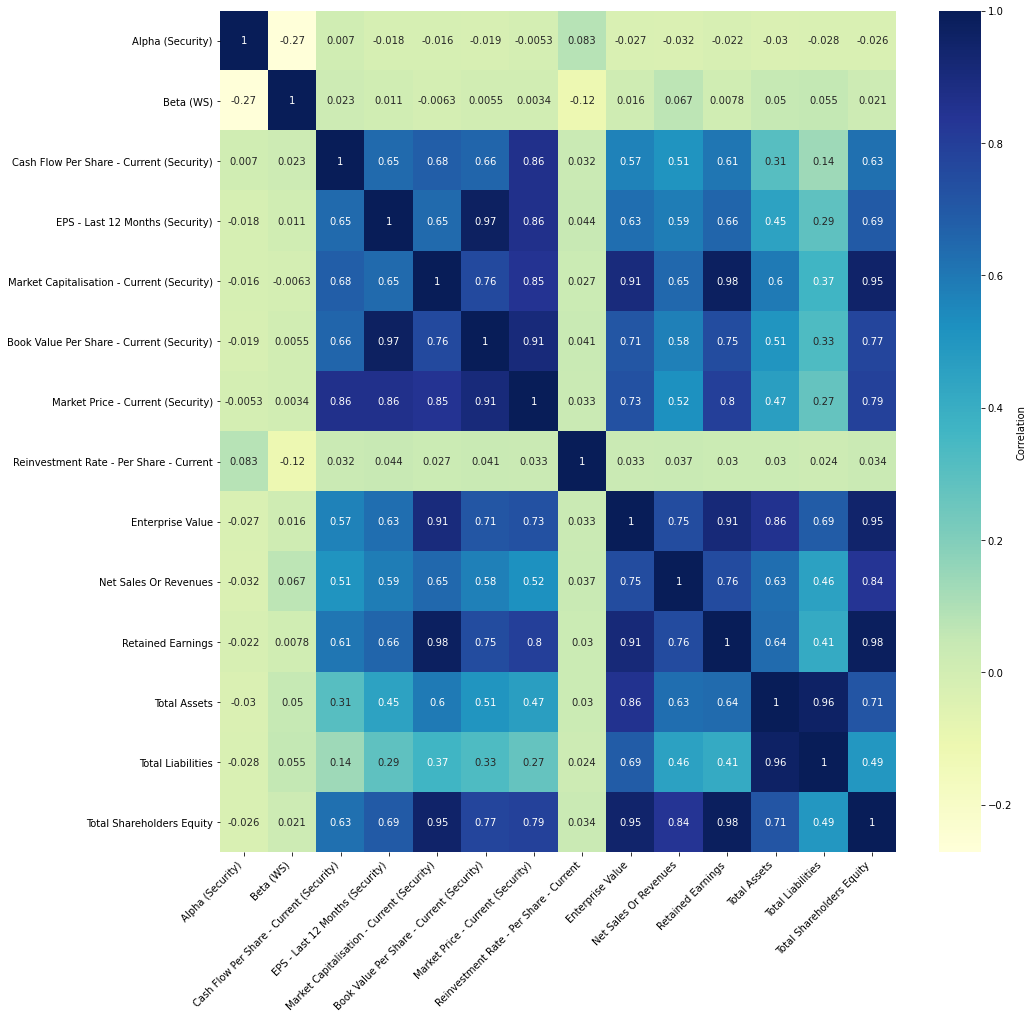

<Figure size 432x288 with 0 Axes>

In [19]:
# Correlation Matrix (Heatmap)
corr = df_cluster.iloc[:,1:].copy()
corr = corr.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

In [20]:
# Further variable selection to exclude variables with high correlation
df_cluster.drop(columns=['Total Shareholders Equity',
                         'Enterprise Value',
                         'Book Value Per Share - Current (Security)',
                         'Total Assets',
                         'Retained Earnings',
                         'Market Price - Current (Security)'], inplace=True)
df_cluster

Company Name (Security)  Alpha (Security)  Beta (WS)  \
0           AEM HOLDINGS LIMITED             -0.49       1.23   
1                     HYFLUX LTD             -2.00       1.17   
2      SHC INSURANCE PTE LIMITED              1.50       0.84   
3               LH GROUP LIMITED             -1.86       0.60   
4    CREATIVE TECHNOLOGY LIMITED             -1.48       1.31   
..                           ...               ...        ...   
569   HONG LEONG FINANCE LIMITED             -0.32       0.71   
570                   MAGNUM BHD             -0.83       0.56   
571    INTERRA RESOURCES LIMITED             -1.96       3.57   
572    SINGAPURA FINANCE LIMITED             -0.83       0.26   
573     FAR EAST ORCHARD LIMITED             -0.53       0.39   

     Cash Flow Per Share - Current (Security)  \
0                                       0.180   
1                                       0.092   
2                                      -0.007   
3                                      -0.111   
4                                       0.173   
..                                        ...   
569                                     0.224   
570                                     0.106   
571                                     0.000   
572                                     0.040   
573                                     0.112   

     EPS - Last 12 Months (Security)  \
0                              0.195   
1                             -0.030   
2                             -0.007   
3                             -0.162   
4                              0.208   
..                               ...   
569                            0.146   
570                            0.117   
571                           -0.093   
572                            0.012   
573                            0.193   

     Market Capitalisation - Current (Security)  \
0                                       24431.0   
1                                      384790.0   
2                                       40696.0   
3                                        8829.0   
4                                       67870.0   
..                                          ...   
569                                    963011.0   
570                                   3216016.0   
571                                     35451.0   
572                                    133296.0   
573                                    629789.0   

     Reinvestment Rate - Per Share - Current  Net Sales Or Revenues  \
0                                      35.89                30860.0   
1                                      -4.02               321394.0   
2                                      -4.19                 3597.0   
3                                     -10.13                32573.0   
4                                      10.78               146568.0   
..                                       ...                    ...   
569                                     1.22               267158.0   
570                                    -0.74              2886541.0   
571                                   -80.83                78641.0   
572                                    -0.49                28876.0   
573                                     4.64               315537.0   

     Total Liabilities  
0              16308.0  
1            1859318.0  
2                412.0  
3              10086.0  
4              73223.0  
..                 ...  
569         10599893.0  
570          1172589.0  
571            34826.0  
572           857556.0  
573           692051.0  

[574 rows x 9 columns]

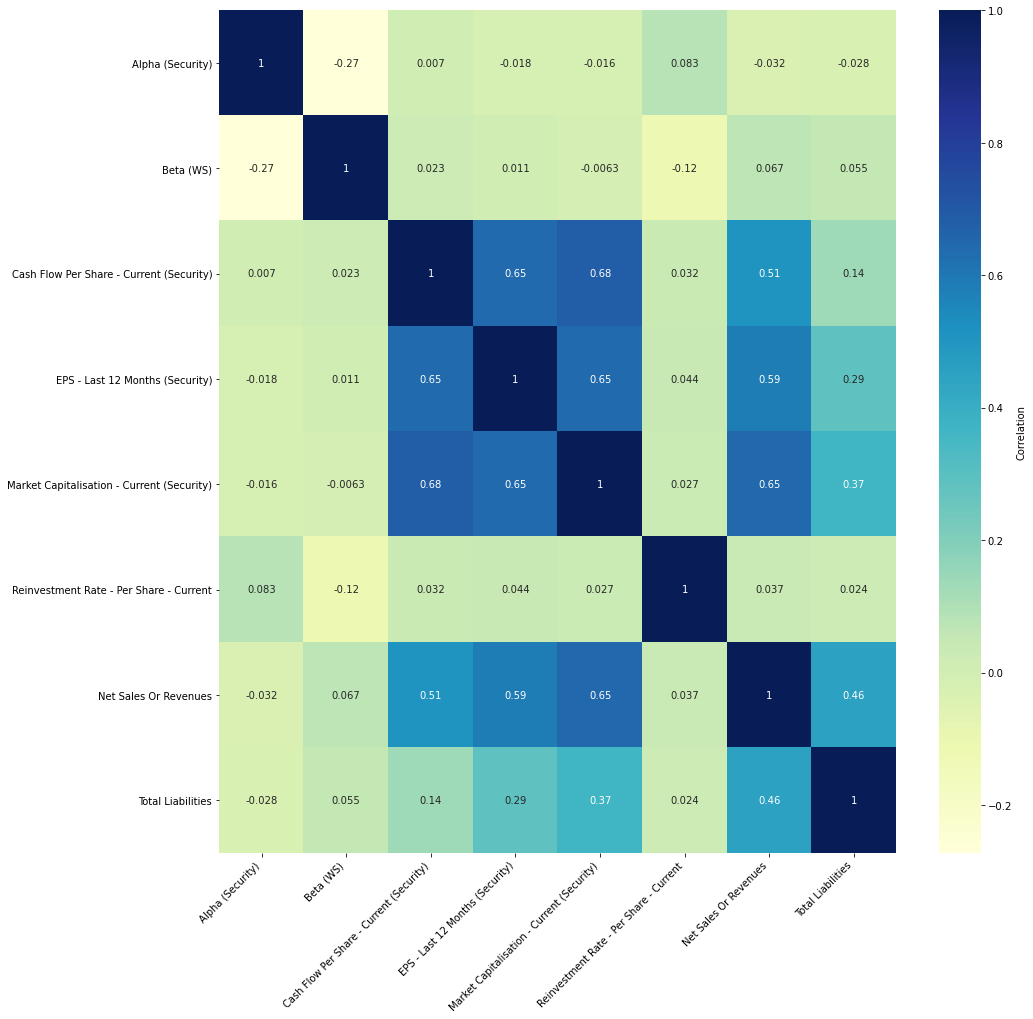

<Figure size 432x288 with 0 Axes>

In [21]:
# Correlation Matrix (Heatmap)
corr = df_cluster.iloc[:,1:].copy()
corr = corr.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu",cbar_kws={'label': 'Correlation'})
plt.tight_layout()
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)

plt.show()
plt.clf()

## Regression Analysis

In [22]:
# Feature Scaling and Standardization
df = df_regression.copy()
x_scaled = df.iloc[:,1:-6].copy()
y_scaled = df.iloc[:,0:1].copy()

x_scaler = StandardScaler().fit(x_scaled)
y_scaler = StandardScaler().fit(y_scaled)

x_scaled = pd.DataFrame(x_scaler.transform(x_scaled), columns=list(df.columns)[1:-6])
y_scaled = pd.DataFrame(y_scaler.transform(y_scaled), columns=[list(df.columns)[0]])

df_norm = pd.concat([y_scaled,x_scaled,df.iloc[:,-6:]], axis=1)
df_norm

Market Price - Current (Security)  Alpha (Security)  Beta (WS)  \
0                             -0.091425         -0.179696  -0.125978   
1                             -0.091293          0.200371   0.367681   
2                             -0.089124         -0.033516  -0.679839   
3                             -0.091425         -0.179696  -0.125978   
4                             -0.088259         -0.043262  -0.282504   
...                                 ...               ...        ...   
7744                          -0.089633         -0.098485  -0.186180   
7745                          -0.089551         -0.264155  -0.366787   
7746                          -0.091543         -0.631228   3.257390   
7747                          -0.090843         -0.264155  -0.728001   
7748                          -0.090252         -0.166702  -0.571475   

      Cash Flow Per Share - Current (Security)  \
0                                    -0.088813   
1                                    -0.085910   
2                                    -0.086203   
3                                    -0.088813   
4                                    -0.085854   
...                                        ...   
7744                                 -0.085899   
7745                                 -0.087227   
7746                                 -0.088419   
7747                                 -0.087969   
7748                                 -0.087159   

      Market Capitalisation - Current (Security)  \
0                                      -0.072079   
1                                      -0.072663   
2                                      -0.069413   
3                                      -0.072079   
4                                      -0.067489   
...                                          ...   
7744                                   -0.072119   
7745                                   -0.070024   
7746                                   -0.072982   
7747                                   -0.072891   
7748                                   -0.072429   

      Book Value Per Share - Current (Security)  \
0                                     -0.111465   
1                                     -0.110796   
2                                     -0.104401   
3                                     -0.111465   
4                                     -0.108051   
...                                         ...   
7744                                  -0.105126   
7745                                  -0.108867   
7746                                  -0.111758   
7747                                  -0.109116   
7748                                  -0.106850   

      Reinvestment Rate - Per Share - Current  Net Sales Or Revenues  \
0                                   -0.003069              -0.081188   
1                                    0.371157              -0.083551   
2                                    0.249310              -0.083602   
3                                   -0.003069              -0.080850   
4                                    0.160612              -0.082635   
...                                       ...                    ...   
7744                                 0.173871              -0.083173   
7745                                 0.129064              -0.078038   
7746                                -1.701831              -0.083752   
7747                                 0.134779              -0.083750   
7748                                 0.252054              -0.083253   

      Retained Earnings  Total Liabilities  \
0             -0.064358          -0.076001   
1             -0.064411          -0.076084   
2             -0.064167          -0.076046   
3             -0.064342          -0.075897   
4             -0.064298          -0.075917   
...                 ...                ...   
7744          -0.061969          -0.068480   
7745          -0.063503          -0.075342   
7746          -0.064529

### Linear Regression (with auto variable selection)

In [23]:
df = df_norm.copy()
y = list(df.columns)[0]

rename_columns = {}

for column_name in list(df.columns):
    ## Go through each column name and check if it contains non-alphanumeric
    if re.search('\W', column_name):
        ## Remove non-alphanumeric at the start or end of the column names or replace with '_' if in the middle
        new_name = re.sub('^\W+', '', column_name)
        new_name = re.sub('\W+$', '', new_name)
        rename_columns.update({column_name: re.sub('\W+', '_', new_name)})

df.rename(columns=rename_columns,
          inplace=True)

modeleq = ' + '.join(list(df.columns)).replace('+', '~', 1)
print('\nModel equation:', modeleq, '\n')

maxR2 = -np.inf
bmodeleq = modeleq
numx = df.shape[1] - 1
x1x2 = False #interaction variables not yet included
df2 = df.copy()

#print(ols(modeleq, df).fit().summary2())

while True:
    regout = ols(modeleq, df).fit()
    R2 = regout.rsquared_adj
    
    if R2 > maxR2:
        maxR2 = R2
        bmodeleq = modeleq

    print('\nAdjusted R2 =', R2, 'for', numx, 'Xs.')
   
    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break
            
        else:
            #add interaction variables for original untransformed variables in best model so far
            
            numx = bmodeleq.count('+') + 1
            print('\nRestarting from best model (with', numx, 'Xs) found so far...')
            
            colname = bmodeleq.replace('~', '+').split(' + ')
            df = df2[colname]
            colname = colname[1:] #remove y
            
                    
            df2 = df.copy()
                    
            #delete any x too highly correlated with another x, to avoid collinearity
            
            corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
            for x in list(df)[1:]:
                #during 1st time thru loop: new column, with label, created in empty dataframe:
                #during subsequent time thru loop: new row, with row label, added to dataframe:
                corv.loc[x, y] = df[x].corr(df[list(df)[0]])
                
            corv = corv.loc[abs(corv).sort_values([y]).index, :] #corr(Xs, y) ranked

            delta = 0.005 #corr difference lower limit
            dl2 = []
            icorr = True
            while icorr:
                a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
                colname = list(df)[1:]
                dl = []
                print('\nX pairs with correlations >', 1 - delta, ':')
                for b in range(1, a.shape[0]):
                    if a.iloc[b, 0]:
                        if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                            #deleting 1 X from correlated pair:
                            dv0 = a.index[b - 1]
                            dv1 = a.index[b]

                            #neither should already be deleted:
                            if not (dv0 in dl) and not (dv1 in dl):
                                #delete x with rather lower corr(x, y):
                                if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                                    d = dv1
                                elif len(dv0) < len(dv1): #delete x with longer name:
                                    d = dv1
                                else:
                                    d = dv0
                                    
                                dl.append(d) #for en masse deletion later
                                corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                                print(dv0,',',dv1)
            
                if len(dl) > 0:
                    df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
                    dl2 = dl2 + dl #keep for real deletion later
                    print('\n' + str(len(dl)), 'variables considered for deletion:')
                    print('\n'.join([str(x) for x in dl]))
                else:
                    print('(no more)')
                    icorr = False
                    
            dl2 = [x for x in dl2 if x.find('_x_') != -1] #only interaction variables kept
            df2.drop(axis=1, columns=dl2, inplace=True) #collinear interaction variables deleted en masse, for real
            #remaining Xs may be collinear
            print('\n' + str(len(dl2)) + ' interaction variables deleted.')
            
            #potential collinearity issues handled
            
            
            modeleq = ' + '.join(list(df2)).replace('+', '~', 1)
            numx = df2.shape[1] - 1
            x1x2 = True #interaction variables already included
            
            #beyond-pairwise collinearity may still be introduced with the interaction variables
            
            df = df2.copy() #ready for continuing deletion
            continue

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = regout.tvalues[1:]
    xdrop = list(t[abs(t) == min(abs(t))].index)[0]
    print('Variable to drop:', xdrop)
    
    df.drop(xdrop, axis=1, inplace=True)
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

numx = bmodeleq.count('+') + 1
print('\nBest model has', numx, 'Xs:')

out = ols(bmodeleq, df2).fit()
print(out.summary2())


Model equation: Market_Price_Current_Security ~ Alpha_Security + Beta_WS + Cash_Flow_Per_Share_Current_Security + Market_Capitalisation_Current_Security + Book_Value_Per_Share_Current_Security + Reinvestment_Rate_Per_Share_Current + Net_Sales_Or_Revenues + Retained_Earnings + Total_Liabilities + General_Industry_Classification_Key_Item__1 + General_Industry_Classification_Key_Item__2 + General_Industry_Classification_Key_Item__3 + General_Industry_Classification_Key_Item__4 + General_Industry_Classification_Key_Item__5 + General_Industry_Classification_Key_Item__6 


Adjusted R2 = 0.982324159939449 for 15 Xs.
Variable to drop: General_Industry_Classification_Key_Item__5

Adjusted R2 = 0.982324159939449 for 14 Xs.
Variable to drop: General_Industry_Classification_Key_Item__1

Adjusted R2 = 0.9823264091630182 for 13 Xs.
Variable to drop: General_Industry_Classification_Key_Item__4

Adjusted R2 = 0.9823283629317311 for 12 Xs.
Variable to drop: General_Industry_Classification_Key_Item__2


In [24]:
# Split training and testing set for ols model after variable selection
data = df2.copy()

x1 = data.iloc[:,1:]
y1 = data.iloc[:,0:1]

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, 
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42)

training_set = pd.concat([y1_train, x1_train], axis=1)
training_set

Market_Price_Current_Security   Beta_WS  \
344                        0.310408 -0.788203   
2760                      -0.067045 -0.619637   
5974                      -0.091348 -1.029012   
4372                      -0.091589 -0.174140   
7271                      -0.090829 -0.715960   
...                             ...       ...   
5226                      -0.091225  0.199114   
5390                      -0.091207 -0.005574   
860                       -0.090743 -0.198221   
7603                       0.074415  0.319519   
7270                      -0.091457  0.957663   

      Cash_Flow_Per_Share_Current_Security  \
344                               0.821713   
2760                             -0.072575   
5974                             -0.088431   
4372                             -0.088262   
7271                             -0.087035   
...                                    ...   
5226                             -0.086765   
5390                             -0.088374   
860                              -0.086855   
7603                              0.072902   
7270                             -0.088566   

      Market_Capitalisation_Current_Security  \
344                                 0.080379   
2760                               -0.067798   
5974                               -0.072992   
4372                               -0.072974   
7271                               -0.072904   
...                                      ...   
5226                               -0.072996   
5390                               -0.071818   
860                                -0.072898   
7603                               -0.064143   
7270                               -0.072973   

      Book_Value_Per_Share_Current_Security  \
344                                0.651464   
2760                              -0.092876   
5974                              -0.110763   
4372                              -0.111774   
7271                              -0.111265   
...                                     ...   
5226                              -0.109602   
5390                              -0.111429   
860                               -0.109703   
7603                              -0.039679   
7270                              -0.111401   

      Reinvestment_Rate_Per_Share_Current  Net_Sales_Or_Revenues  \
344                              0.324064               0.052115   
2760                             0.235137              -0.082578   
5974                             0.378015              -0.083462   
4372                             0.024363              -0.082632   
7271                             0.386473              -0.083710   
...                                   ...                    ...   
5226                            -0.887541              -0.083327   
5390                             0.655084              -0.083671   
860                              0.095688              -0.083226   
7603                             0.390817              -0.075874   
7270                             0.099346              -0.083448   

      Retained_Earnings  Total_Liabilities  \
344           -0.038702          -0.054473   
2760          -0.063390          -0.075972   
5974          -0.064319          -0.076056   
4372          -0.064143          -0.075956   
7271          -0.064266          -0.076099   
...                 ...                ...   
5226          -0.064458          -0.076045   
5390          -0.064333          -0.075632   
860           -0.064244          -0.076061   
7603          -0.057280          -0.073432   
7270          -0.064390          -0.076073   

      General_Industry_Classification_Key_Item__3  \
344                                             0   
2760                                            0   
5974                                            0   
4372                                            0   
7271                                            0   
...                               

In [25]:
rmse_comparison = []

reg_eqn = ' + '.join(list(df2.columns)).replace('+', '~', 1)
print('Model equation:\n', reg_eqn)

reg_model = ols(reg_eqn, training_set).fit()
y_pred = reg_model.predict(x1_test)
rmse = np.sqrt(mean_squared_error(y_pred, y1_test))
rmse_comparison.append(rmse)

print('\nRMSE (Linear Regression) =', rmse)

Model equation:
 Market_Price_Current_Security ~ Beta_WS + Cash_Flow_Per_Share_Current_Security + Market_Capitalisation_Current_Security + Book_Value_Per_Share_Current_Security + Reinvestment_Rate_Per_Share_Current + Net_Sales_Or_Revenues + Retained_Earnings + Total_Liabilities + General_Industry_Classification_Key_Item__3 + General_Industry_Classification_Key_Item__6

RMSE (Linear Regression) = 0.1415275318750541


### Linear Regression

In [26]:
# Split training and testing set for the remaining regression models
data = df_norm.copy()

x = data.iloc[:,1:]
y = data.iloc[:,0:1]

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    shuffle=True, 
                                                    random_state=42)

In [27]:
linear_regr = LinearRegression(fit_intercept=True,
                               normalize=False, 
                               copy_X=True, 
                               n_jobs=-1)

linear_regr.fit(x_train, y_train)
y_pred = linear_regr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse_comparison.append(rmse)

print('RMSE (Linear Regression) =',rmse)

RMSE (Linear Regression) = 0.14151472303855187


### Lasso Regression

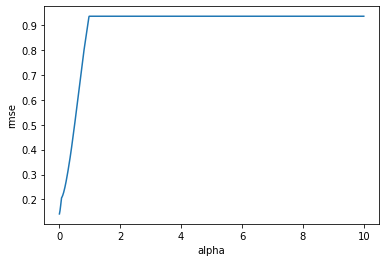

Best alpha = 0.0
Best RMSE (Lasso Regression) = 0.14151472303855406


In [28]:
alpha = np.linspace(0,10,1001)
rmse_all = []

for i in alpha:
    lasso_regr = Lasso(alpha=i, 
                       fit_intercept=True,
                       normalize=False,
                       copy_X=True,
                       max_iter=10000,
                       tol=0.0001,
                       random_state=42)
    lasso_regr.fit(x_train, y_train)
    y_pred = lasso_regr.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmse_all.append(rmse)

index = np.argmin(rmse_all)
best_alpha = alpha[index]
best_rmse = rmse_all[index]
rmse_comparison.append(best_rmse)

plt.plot(alpha, rmse_all)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print('Best alpha =', best_alpha)
print('Best RMSE (Lasso Regression) =', best_rmse)

### Ridge Regression

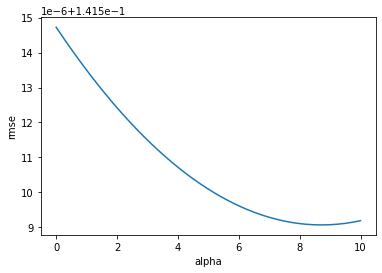

Best alpha = 8.72
Best RMSE (Ridge Regression) = 0.14150907187840261


In [29]:
alpha = np.linspace(0,10,1001)
rmse_all = []

for i in alpha:
    ridge_regr = Ridge(alpha=i,
                       fit_intercept=True,
                       normalize=False,
                       copy_X=True,
                       max_iter=10000,
                       tol=0.0001,
                       random_state=42)
    ridge_regr.fit(x_train, y_train)
    y_pred = ridge_regr.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    rmse_all.append(rmse)

index = np.argmin(rmse_all)
best_alpha = alpha[index]
best_rmse = rmse_all[index]
rmse_comparison.append(best_rmse)

plt.plot(alpha, rmse_all)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print('Best alpha =', best_alpha)
print('Best RMSE (Ridge Regression) =', best_rmse)

### ElasticNet Regression

In [30]:
enet_tm = time.time()

alpha = np.linspace(0,5,501)
ratio = np.linspace(0,1,11)

best_alpha = None
best_ratio = None
best_rmse = 1e+8

for i in alpha:
    for j in ratio:
        elastic_net = ElasticNet(alpha=i,
                                 l1_ratio=j,
                                 fit_intercept=True,
                                 normalize=False,
                                 max_iter=10000,
                                 tol=0.0001,
                                 copy_X=True,
                                 random_state=42)
        elastic_net.fit(x_train, y_train)
        y_pred = elastic_net.predict(x_test)
        rmse = np.sqrt(mean_squared_error(y_pred, y_test))

        if rmse < best_rmse:
            best_alpha = i
            best_ratio = j
            best_rmse = rmse

rmse_comparison.append(best_rmse)

print('Best alpha =', best_alpha)
print('Best ratio =', best_ratio)
print('Best RMSE (Elastic Net) =', best_rmse)
print('Runtime:', time.time()-enet_tm, 'seconds')

Best alpha = 0.0
Best ratio = 0.0
Best RMSE (Elastic Net) = 0.14151472303855406
Runtime: 1152.843255519867 seconds


### Random Forest Regression

In [31]:
rfr = RandomForestRegressor(n_estimators=200,
                            max_features='auto',
                            random_state=42)

rfr.fit(x_train, y_train)
y_pred = rfr.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmse_comparison.append(rmse)

print('Best RMSE (Random Forest Regression) =', rmse)

Best RMSE (Random Forest Regression) = 0.007653504362851763


In [32]:
# Comparing different linear model performances
df_rmse = pd.DataFrame({'RMSE':rmse_comparison}, index=['OLS (Variable Selection)',
                                                        'Linear Regression',
                                                        'Lasso Regression',
                                                        'Ridge Regression',
                                                        'ElasticNet Regression',
                                                        'Random Forest Regression'])
df_rmse

RMSE
OLS (Variable Selection)  0.141528
Linear Regression         0.141515
Lasso Regression          0.141515
Ridge Regression          0.141509
ElasticNet Regression     0.141515
Random Forest Regression  0.007654

## Time Series Analysis

In [33]:
# Load data and set time index
df = df_timeseries.copy()
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', drop=True, inplace=True)
df

Net Sales Or Revenues  Straits Times Index Year Close  \
Year                                                                
1986-01-01                38907.0                          891.30   
1987-01-01                31205.0                          823.58   
1988-01-01                29633.0                         1038.62   
1989-01-01                51496.0                         1481.33   
1990-01-01               124263.0                         1154.48   
1991-01-01               140914.0                         1490.70   
1992-01-01               218293.0                         1524.40   
1993-01-01               240778.0                         2425.68   
1994-01-01               286076.0                         2239.56   
1995-01-01               369896.0                         2266.54   
1996-01-01               494227.0                         2216.79   
1997-01-01               431713.0                         1529.84   
1998-01-01               375061.0                         1392.73   
1999-01-01               434684.0                         2479.58   
2000-01-01               396961.0                         1926.83   
2001-01-01               441669.0                         1623.60   
2002-01-01               473686.0                         1341.03   
2003-01-01               464506.0                         1764.52   
2004-01-01               597719.0                         2066.14   
2005-01-01               667009.0                         2347.34   
2006-01-01               657085.0                         2985.83   
2007-01-01               539120.0                         3482.30   
2008-01-01               620102.0                         1761.56   
2009-01-01               703732.0                         2897.62   
2010-01-01               901420.0                         3190.04   
2011-01-01              1187112.0                         2646.35   
2012-01-01               595744.0                         3167.08   
2013-01-01              2012992.0                         3167.43   
2014-01-01              3209321.0                         3365.15   
2015-01-01              1856993.0                         2882.73   

            Singapore Real interest rate (%)  \
Year                                           
1986-01-01                          8.175095   
1987-01-01                          5.537964   
1988-01-01                          0.506177   
1989-01-01                          1.970430   
1990-01-01                          2.545571   
1991-01-01                          3.014366   
1992-01-01                          4.502178   
1993-01-01                          1.870546   
1994-01-01                          2.336514   
1995-01-01                          3.119200   
1996-01-01                          4.683159   
1997-01-01                          5.184799   
1998-01-01                          8.883830   
1999-01-01                          9.731647   
2000-01-01                          1.897404   
2001-01-01                          7.602585   
2002-01-01                          6.290364   
2003-01-01                          7.223124   
2004-01-01                          1.178439   
2005-01-01                          3.329066   
2006-01-01                          3.404016   
2007-01-01                         -0.553498   
2008-01-01                          6.861239   
2009-01-01                          2.349363   
2010-01-01                          4.230749   
2011-01-01                          4.206909   
2012-01-01                          4.874452   
2013-01-01                          5.833606   
2014-01-01                          5.596786   
2015-01-01                          2.126478   

            United States Real interest rate (%)  Common Shares Outstanding  
Year                                                                         
1986-01-01                              6.193866                   202389.0  
1987-01-01                      

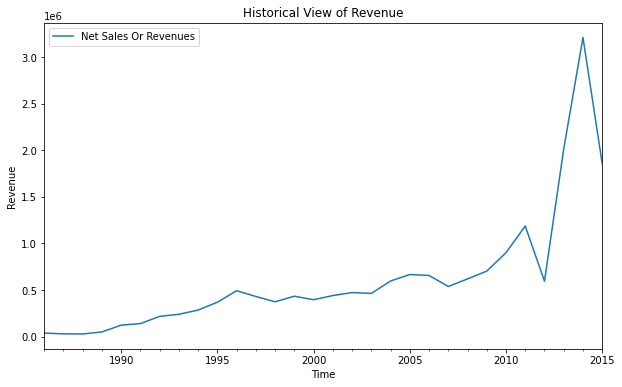

In [34]:
# Initial Visualization of Time Series
ts = df[['Net Sales Or Revenues']].copy()

plt.rcParams["figure.figsize"] = 10, 6
ts.plot()
plt.title('Historical View of Revenue')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.show()

### Time Series Decomposition 

In [35]:
### Time Series Decomposition Function
# data:                 [Series, DataFrame] time series data
# model_type:           ['add', 'mul'] Additive or Multiplicative Models to use for time series decomposition
# freq:                 [<int>] number of periods in a season
# n_obs:                [<int>] last n number of data point to view in decomposition plot

def ts_visualize(decomposition, n_obs=365):
    if len(decomposition.observed) > n_obs:
        
        try:
            decomposition.observed = decomposition.observed[-n_obs:]
            decomposition.trend = decomposition.trend[-n_obs:]
            decomposition.seasonal = decomposition.seasonal[-n_obs:]
            decomposition.resid = decomposition.resid[-n_obs:]
        except:
            decomposition._observed = decomposition._observed[-n_obs:]
            decomposition._trend = decomposition._trend[-n_obs:]
            decomposition._seasonal = decomposition._seasonal[-n_obs:]
            decomposition._resid = decomposition._resid[-n_obs:]
        
        #plt.xticks(rotation=90)
        print('Last', n_obs, 'observations:')
        decomposition.plot()
        plt.show()


def ts_decomp(data, model_type='mul', time_windows=[365, 30, 7, 1], freq=365):
    plt.rcParams['figure.figsize'] = 12, 15
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 1
    
    nr = data.shape[0]

    try:
        if 'mf4' in vars() or 'mf4' in globals() or 'mf4' in vars(__builtins__):
            del mf4 #delete d if defined during previous run
    except:
        pass
    
    mf4 = seasonal_decompose(data, model=model_type, freq=freq, extrapolate_trend='freq') #'extrapolate' removes NaN in 'trend'

    if model_type == 'mul':
        decomp_type = 'Multiplicative'
    elif model_type == 'add':
        decomp_type = 'Additive'
    
    print('\nTime Series Decomposition (' + decomp_type + ') for', nr, 'observations:')

    mf4.plot()
    plt.show()

    for view in time_windows:
        ts_visualize(mf4, n_obs=view)

def decomp_freq(data, ts_name='Time Series', model_type='add', periodicity=[365, 30, 7, 1], n_periods=24):
    all_freq = list(np.array(periodicity)*n_periods) + [1]
    time_windows = list(np.array(periodicity)*n_periods)

    while n_periods>=min(time_windows):
        time_windows.pop(np.argmin(time_windows))
    
    for i in all_freq:
        print("\n##### Time Series Decomposition for", ts_name,"(freq="+str(i)+") #####\n")
        ts_decomp(data, model_type=model_type, time_windows=time_windows, freq=i)


##### Time Series Decomposition for Net Sales Or Revenues (freq=10) #####


Time Series Decomposition (Additive) for 30 observations:


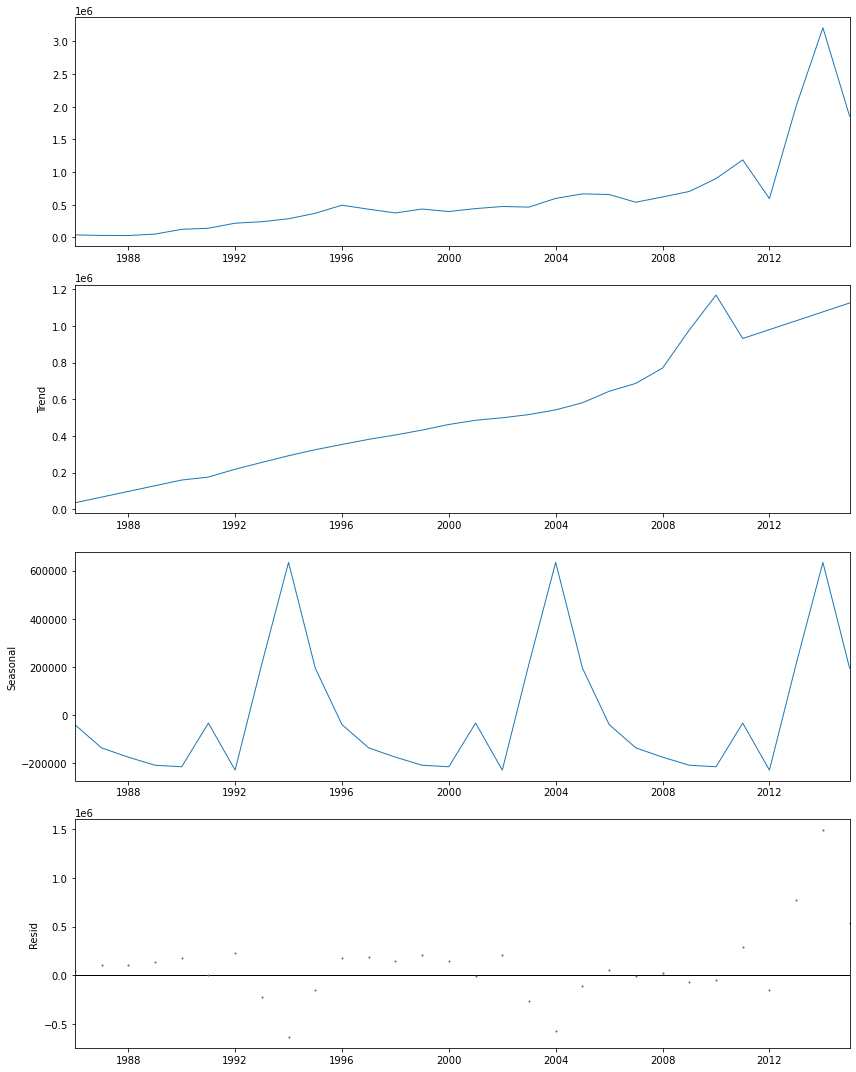

Last 10 observations:


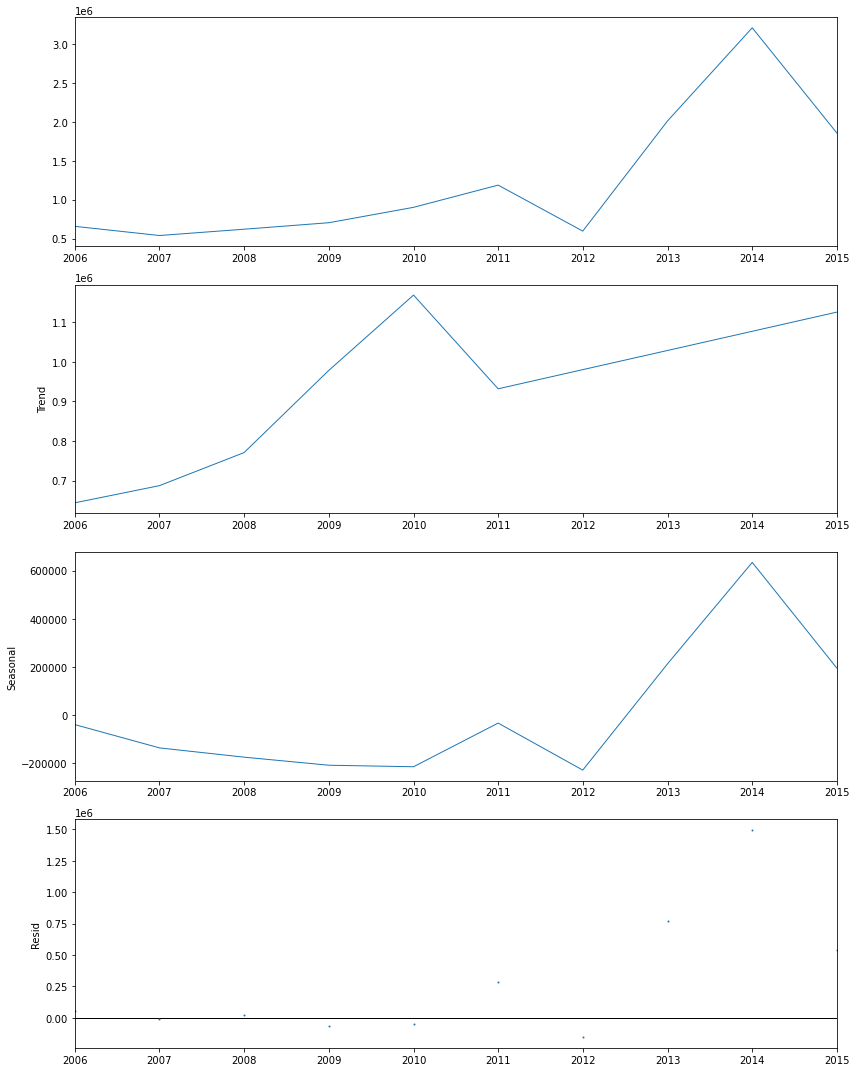

Last 5 observations:


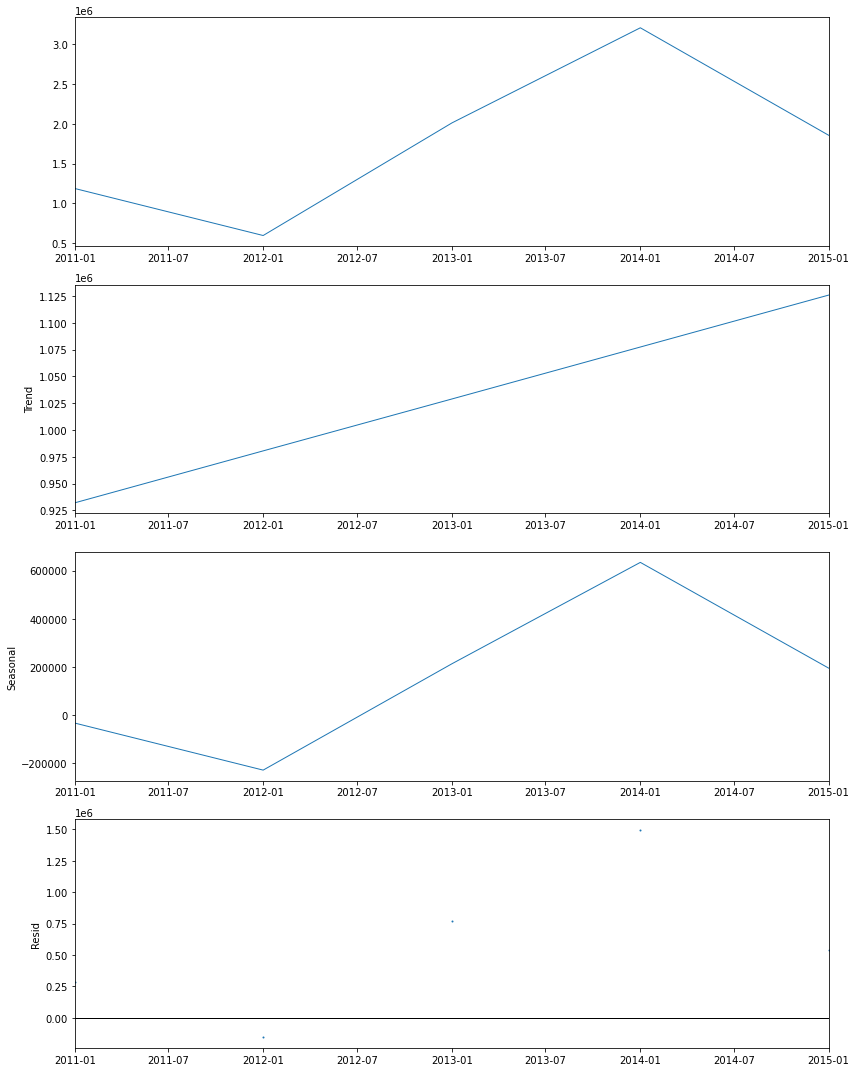

Last 2 observations:


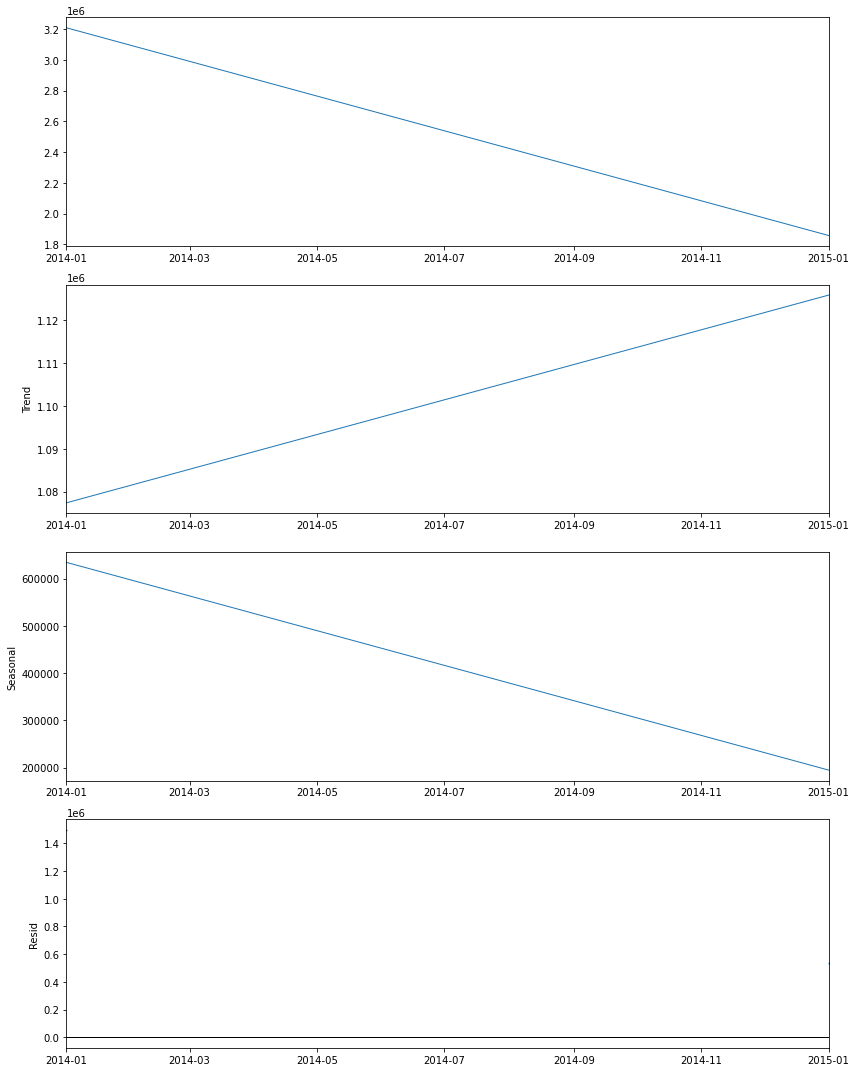


##### Time Series Decomposition for Net Sales Or Revenues (freq=5) #####


Time Series Decomposition (Additive) for 30 observations:


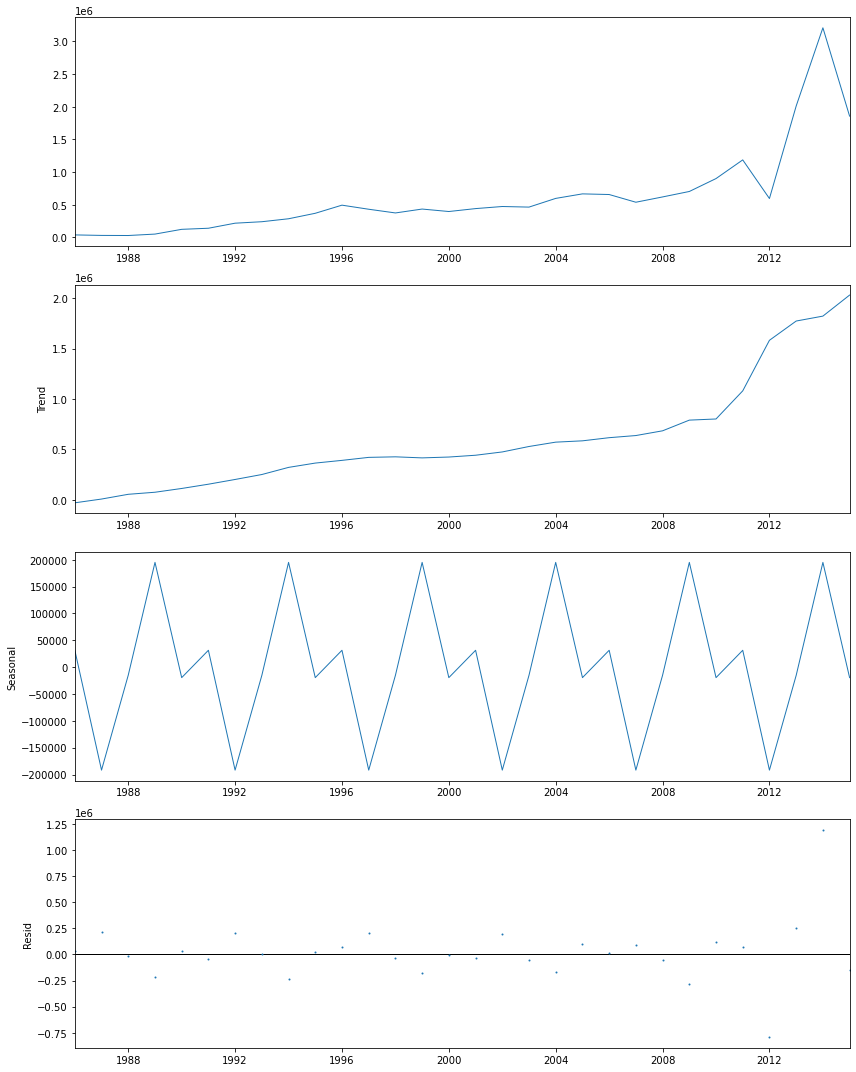

Last 10 observations:


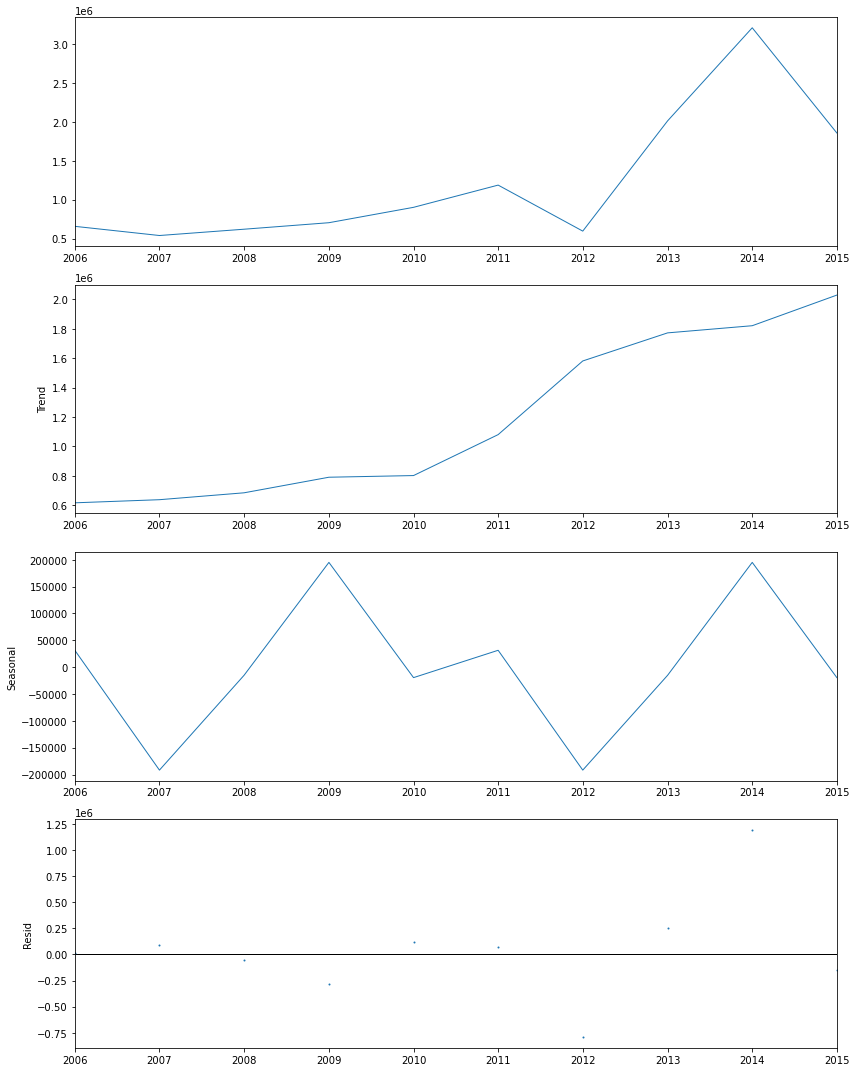

Last 5 observations:


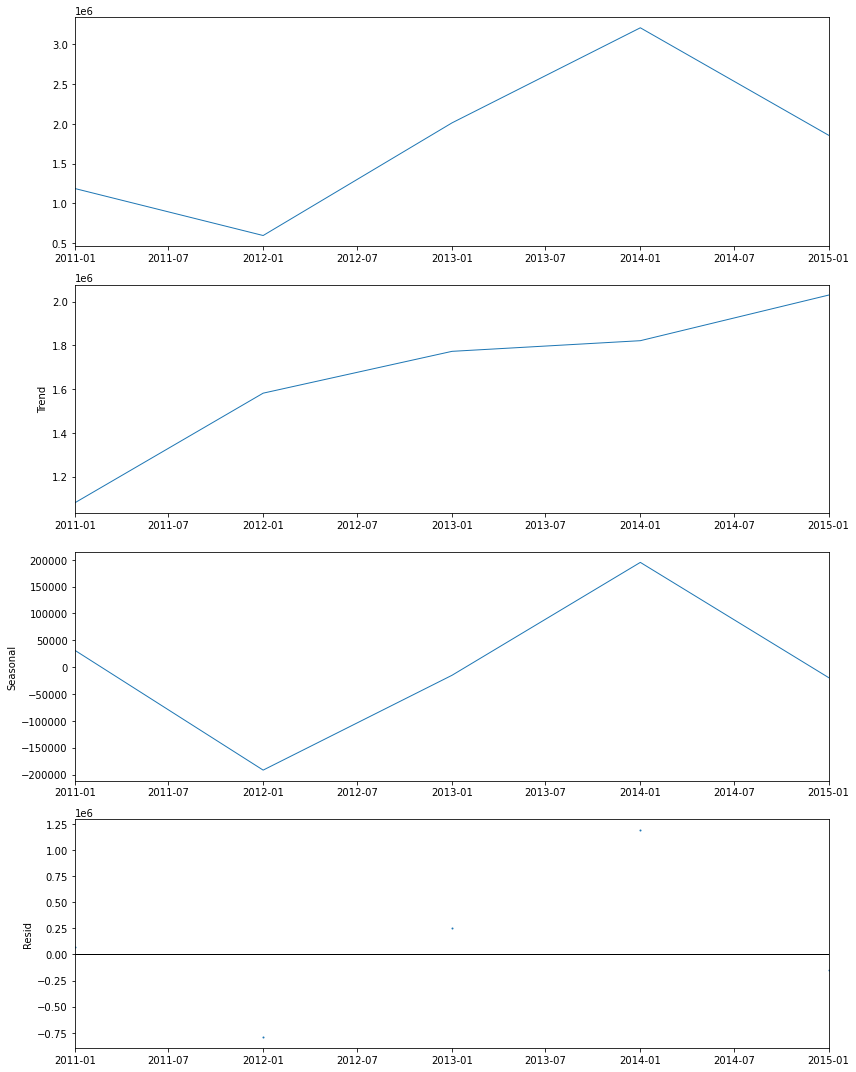

Last 2 observations:


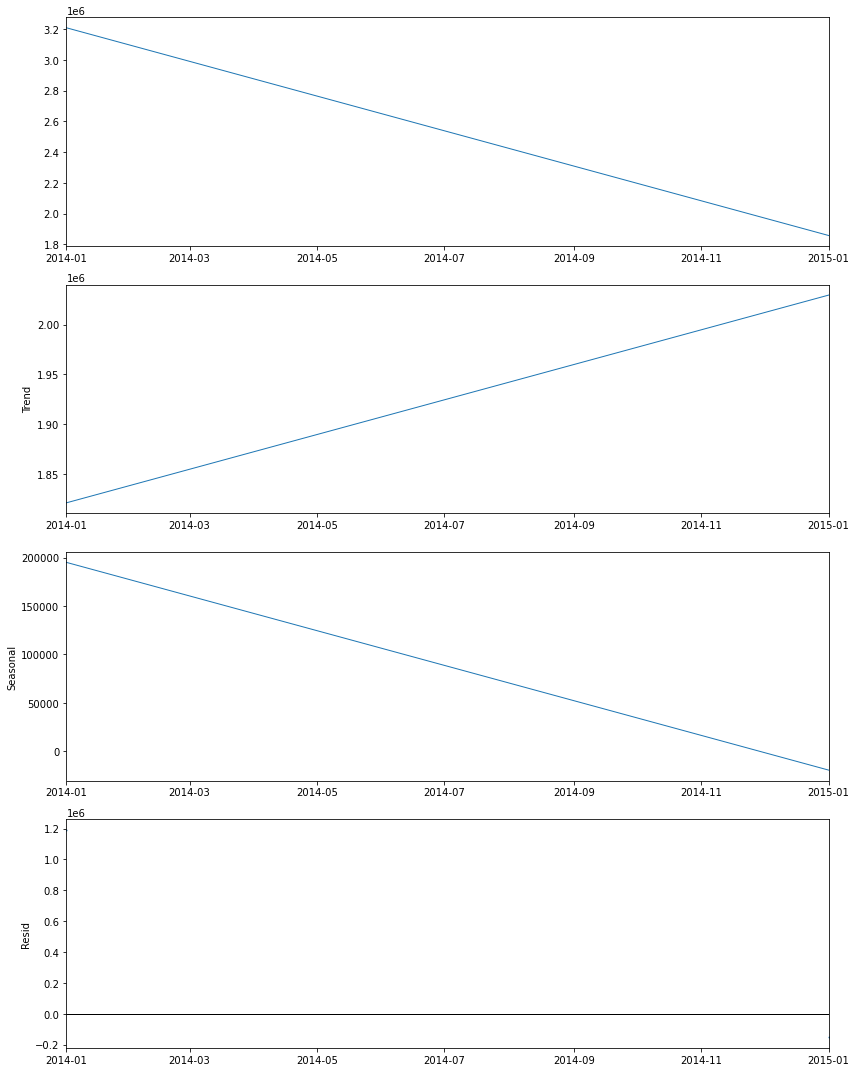


##### Time Series Decomposition for Net Sales Or Revenues (freq=2) #####


Time Series Decomposition (Additive) for 30 observations:


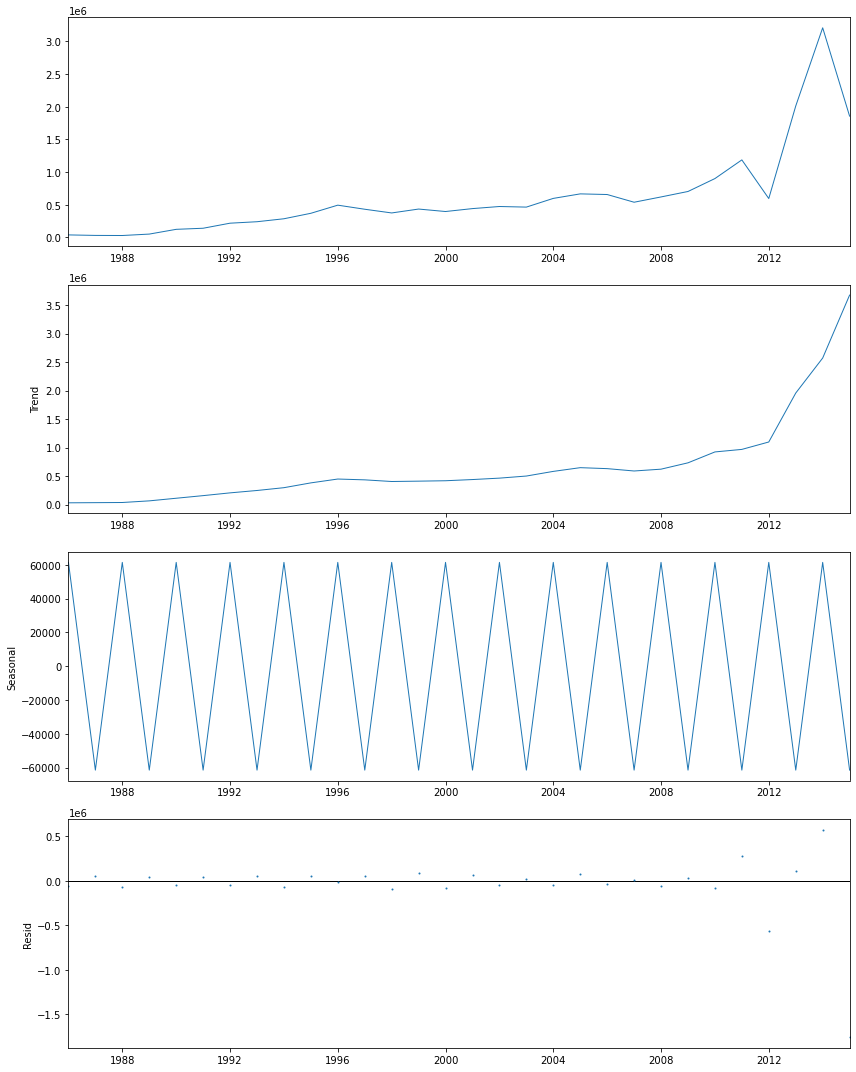

Last 10 observations:


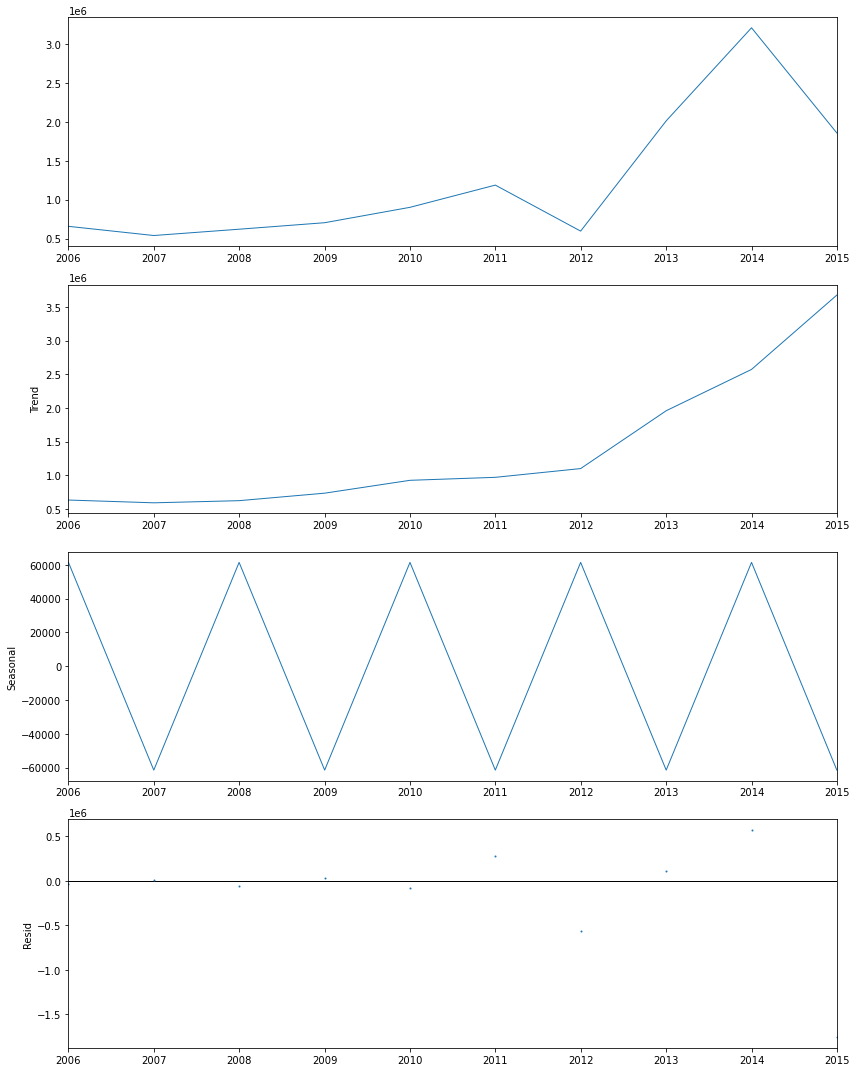

Last 5 observations:


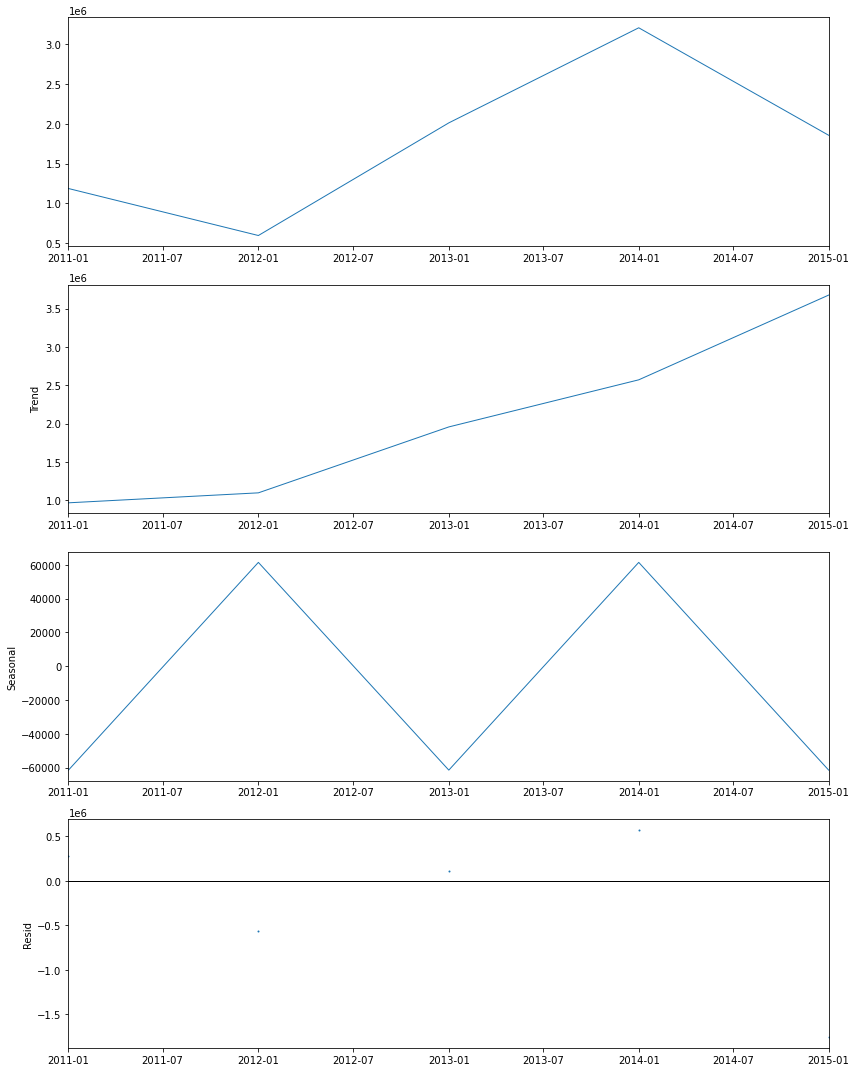

Last 2 observations:


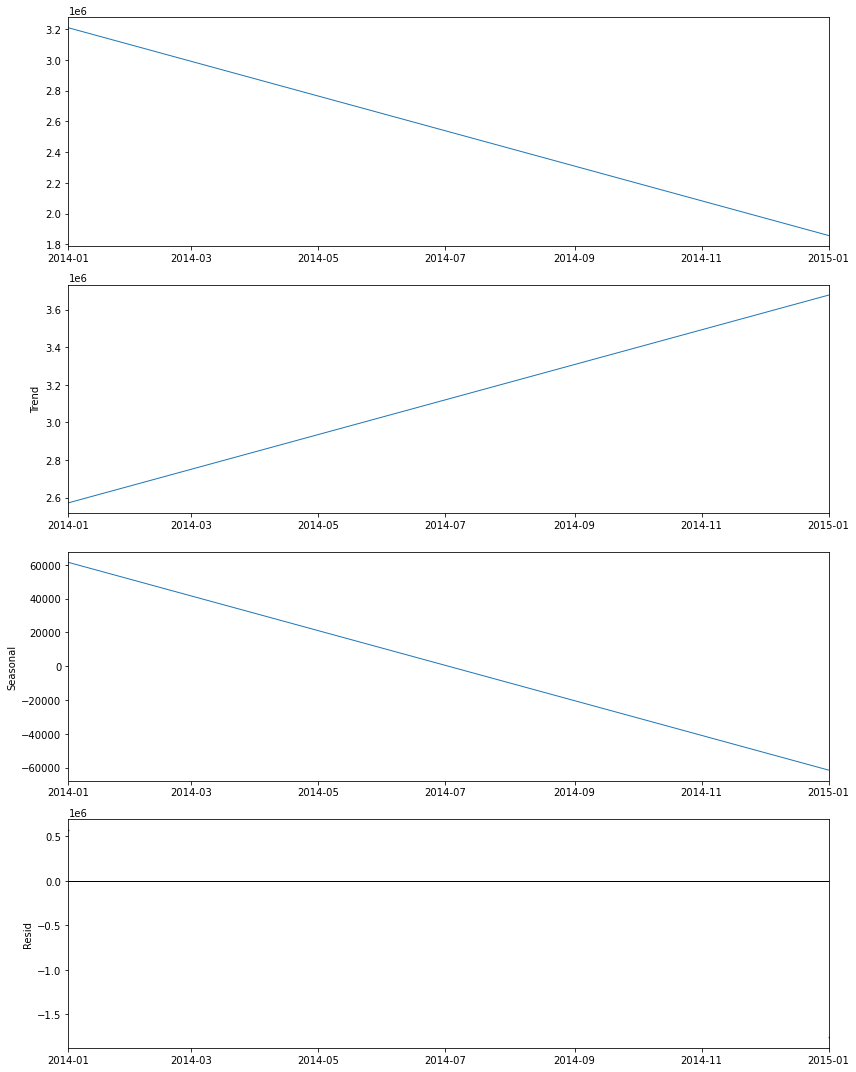


##### Time Series Decomposition for Net Sales Or Revenues (freq=1) #####


Time Series Decomposition (Additive) for 30 observations:


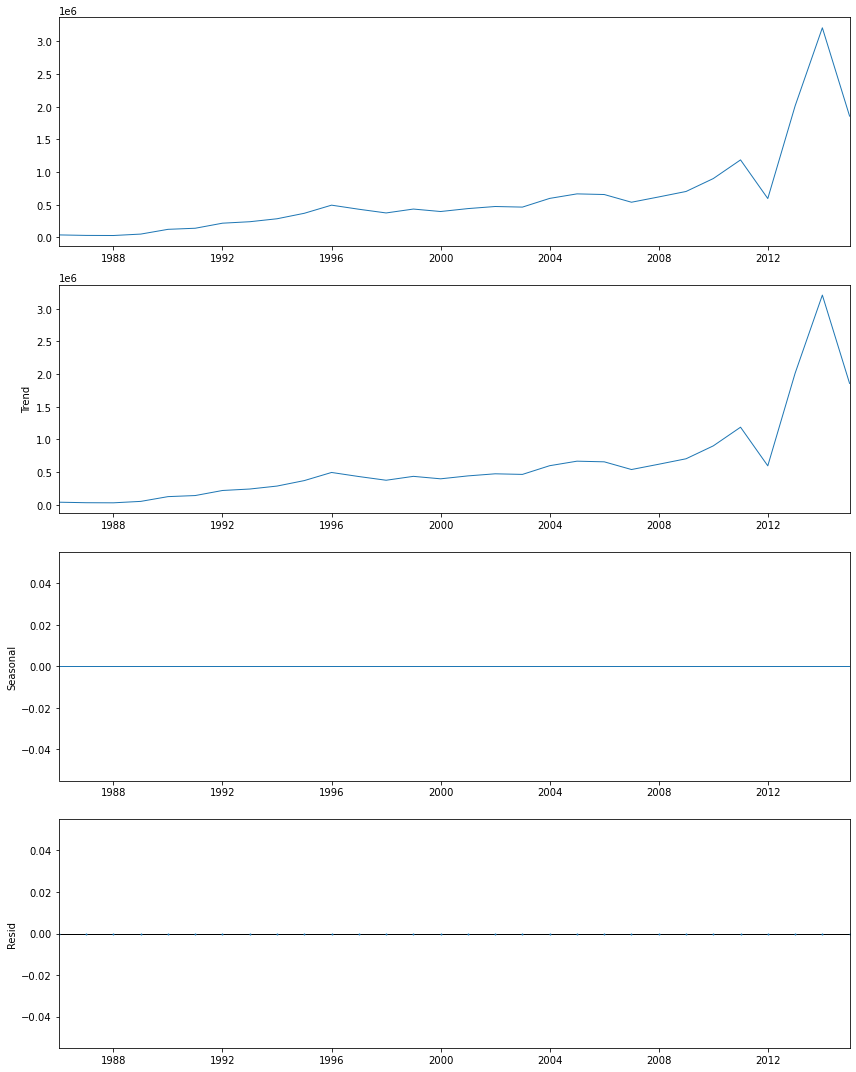

Last 10 observations:


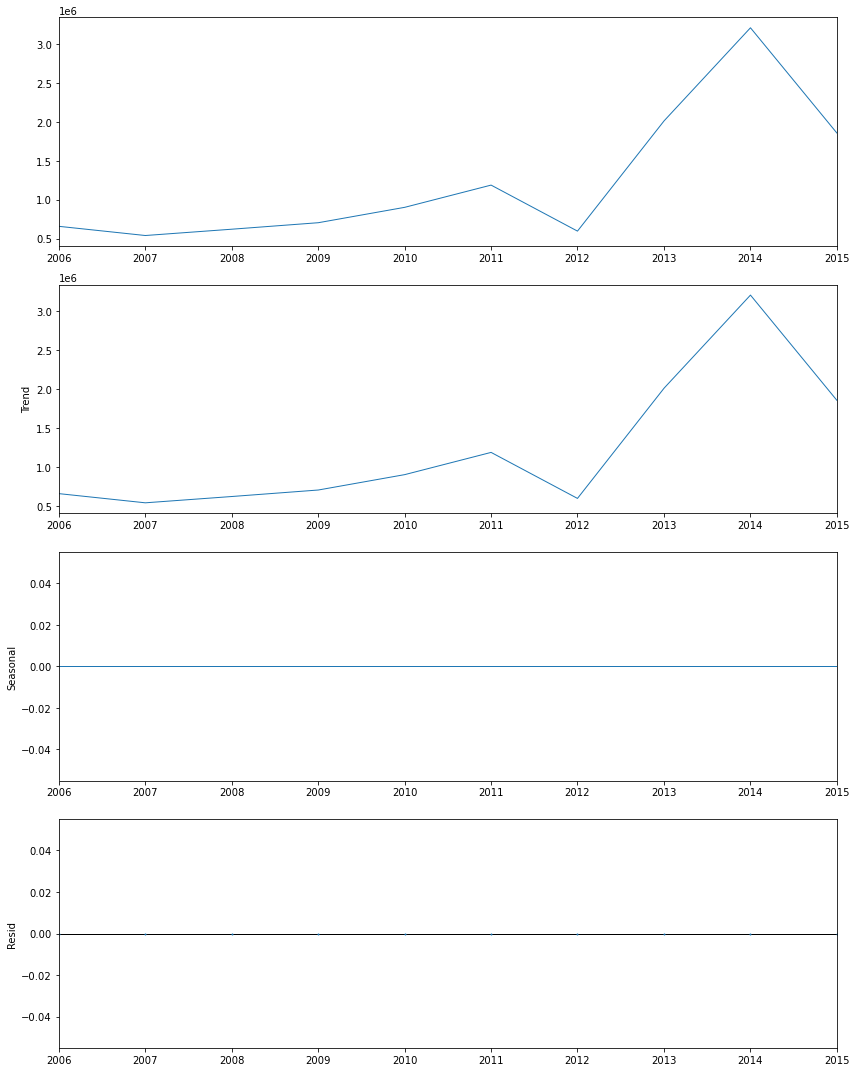

Last 5 observations:


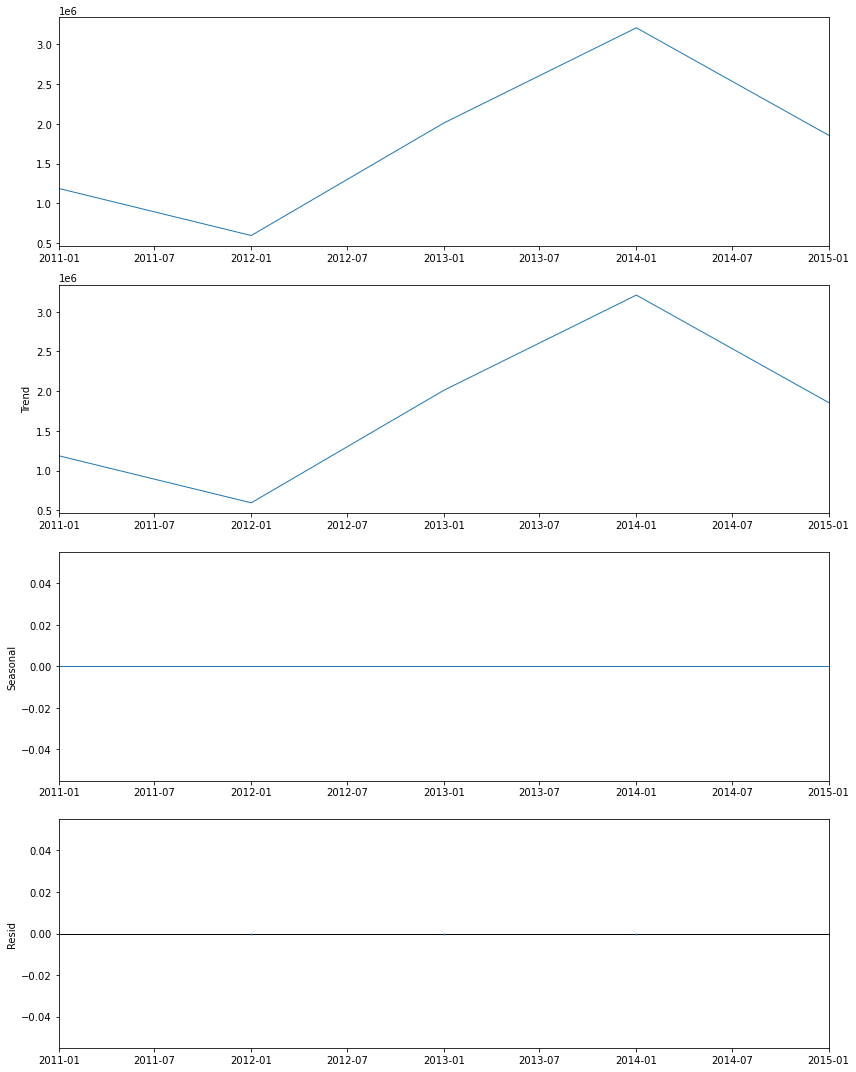

Last 2 observations:


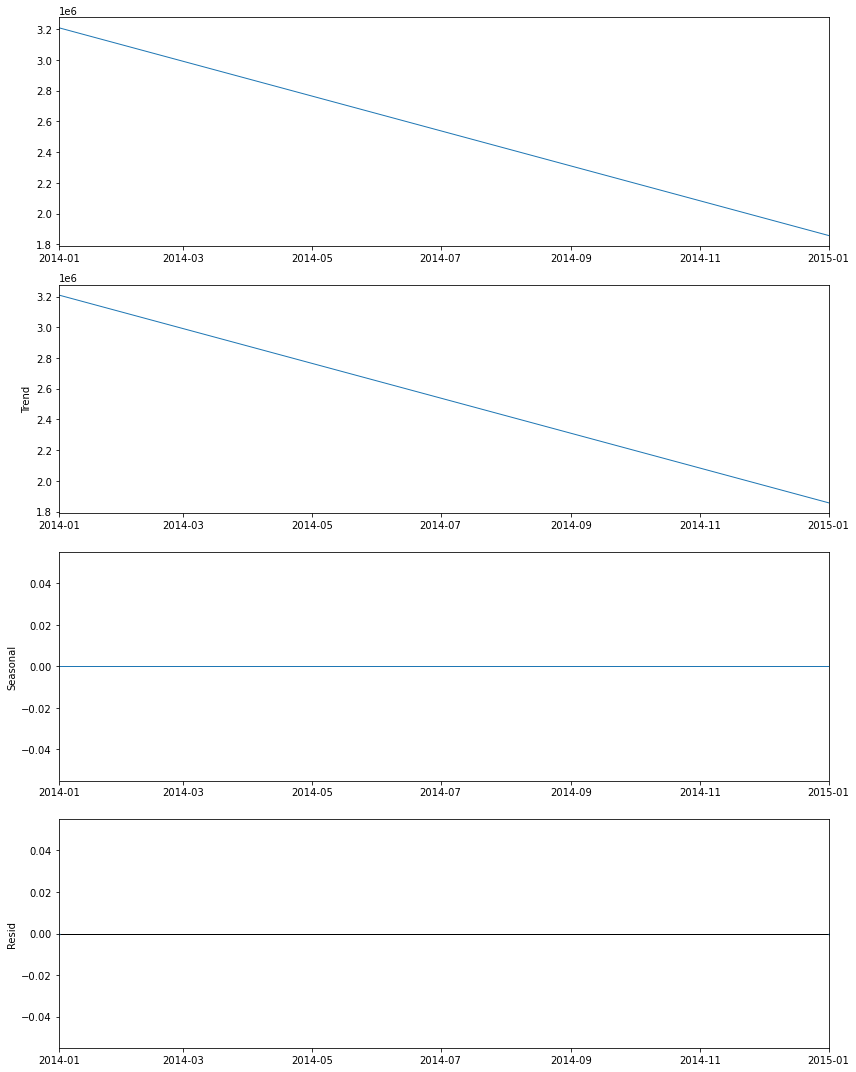


##### Time Series Decomposition for Net Sales Or Revenues (freq=1) #####


Time Series Decomposition (Additive) for 30 observations:


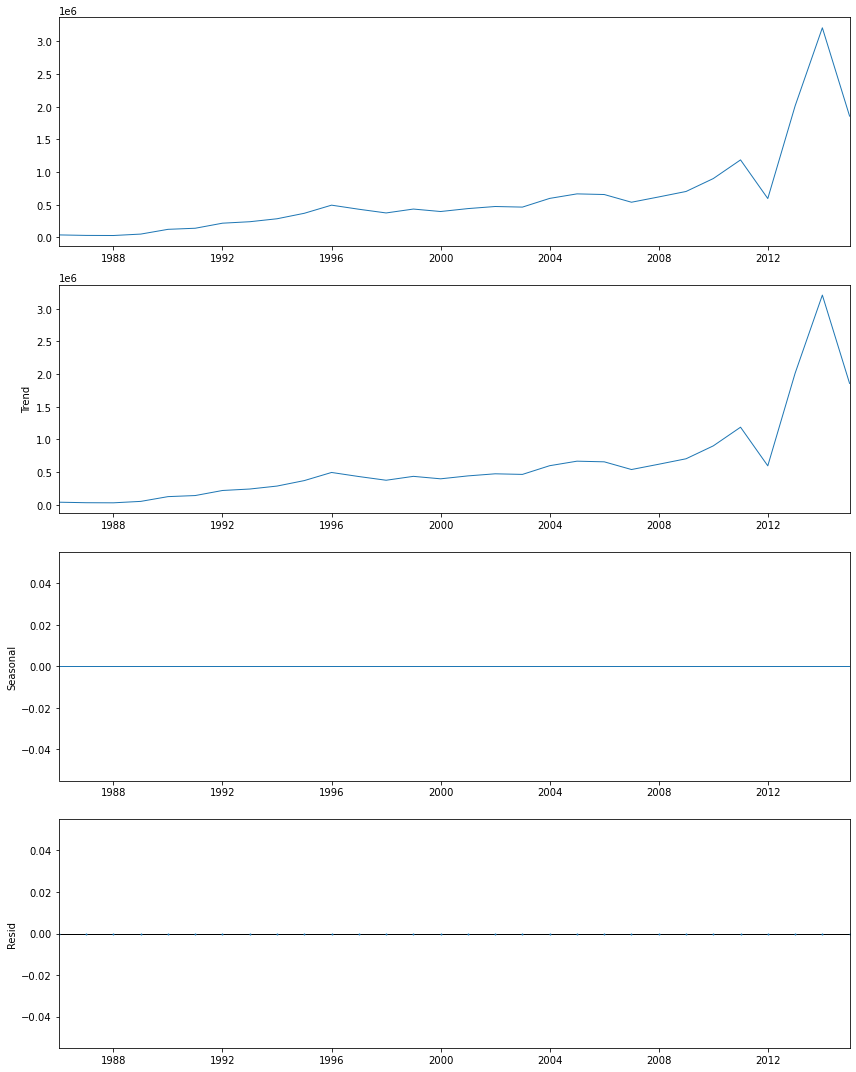

Last 10 observations:


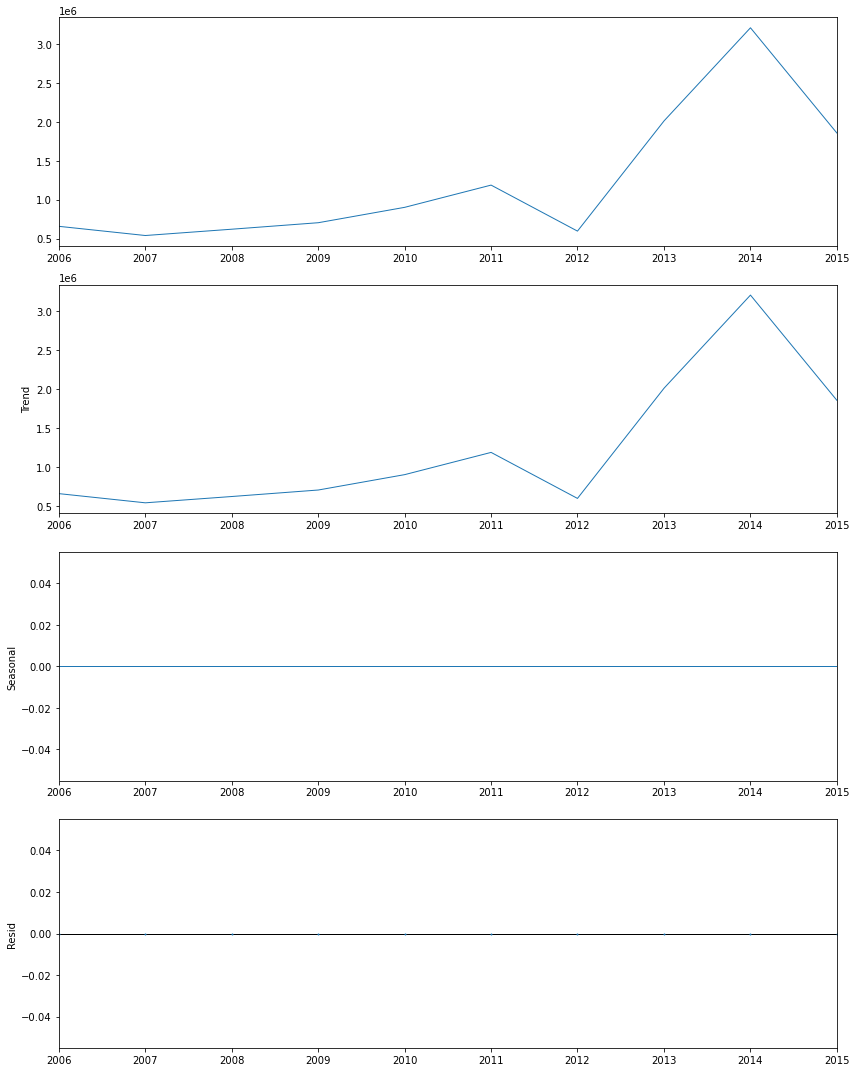

Last 5 observations:


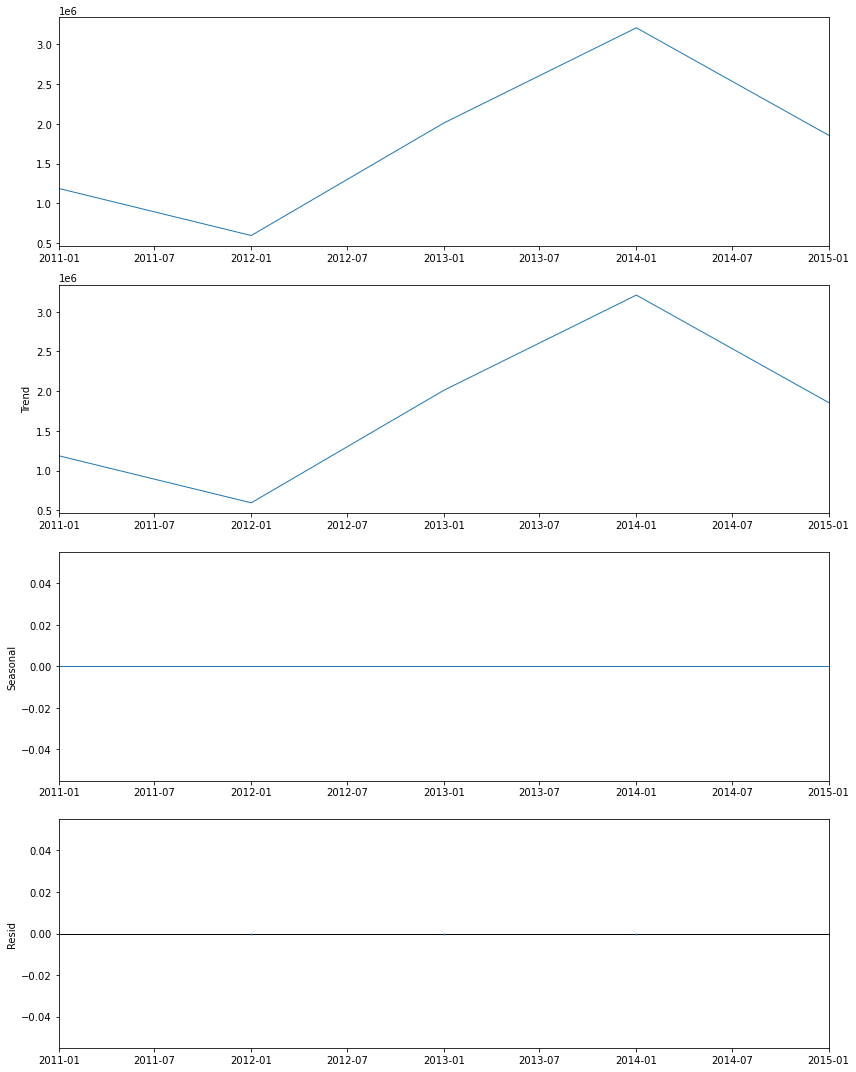

Last 2 observations:


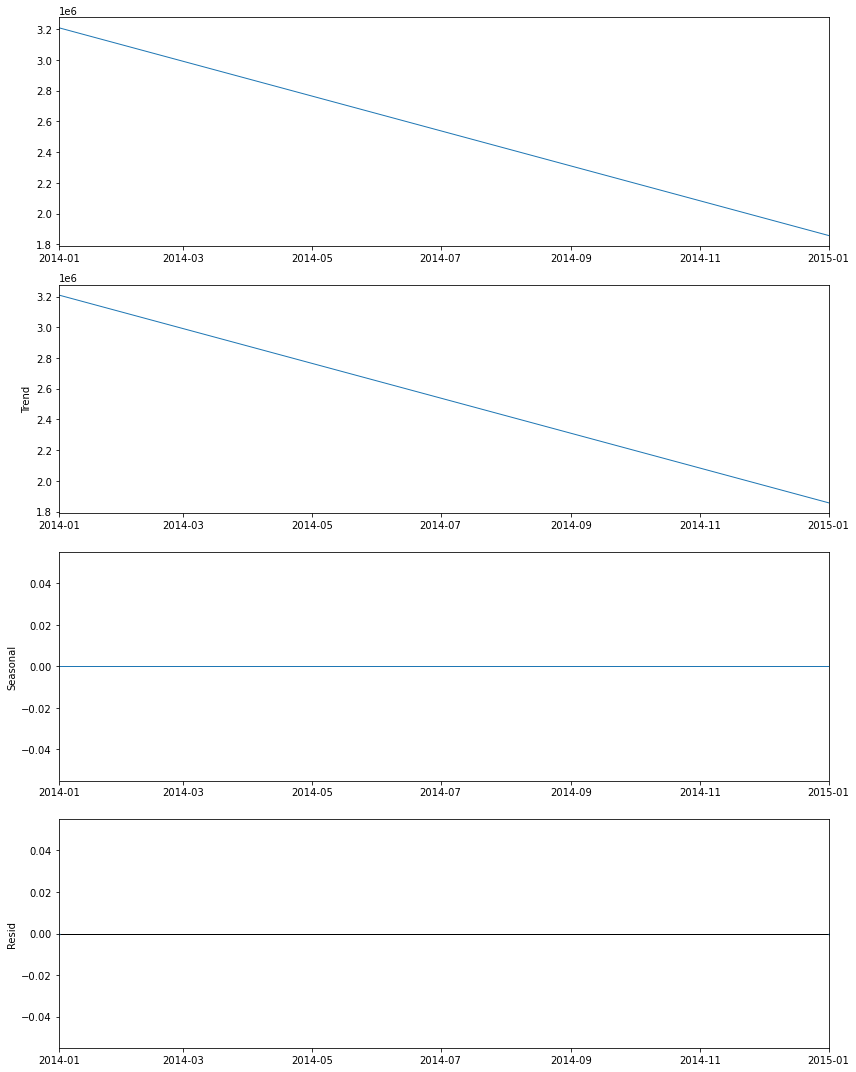

In [36]:
# Time Series Decomposition of Revenue [Decade, 5 Years, 2 Years, Yearly]
ts_periodicity = [10, 5, 2, 1]
ts_n_periods = 1

decomp_freq(ts, ts_name='Net Sales Or Revenues', model_type='add', periodicity=ts_periodicity, n_periods=ts_n_periods)


##### Time Series Decomposition for Straits Times Index Year Close #####


Time Series Decomposition (Additive) for 30 observations:


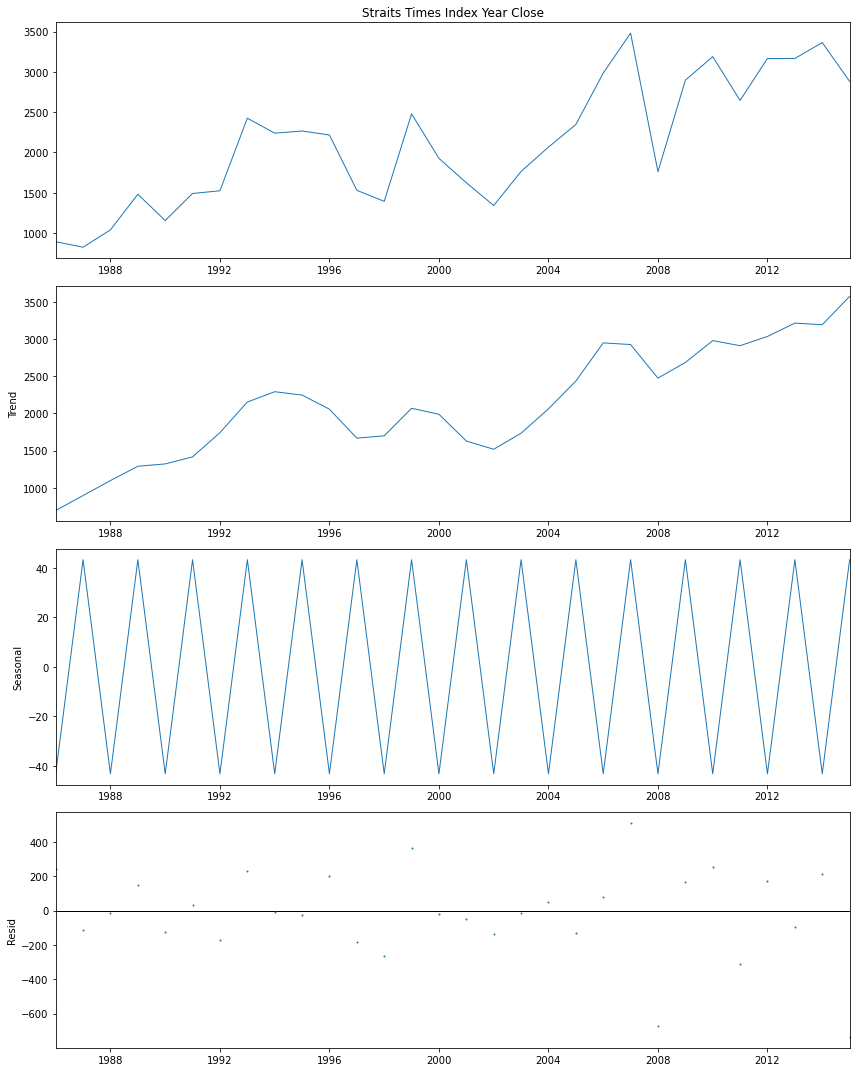

Last 10 observations:


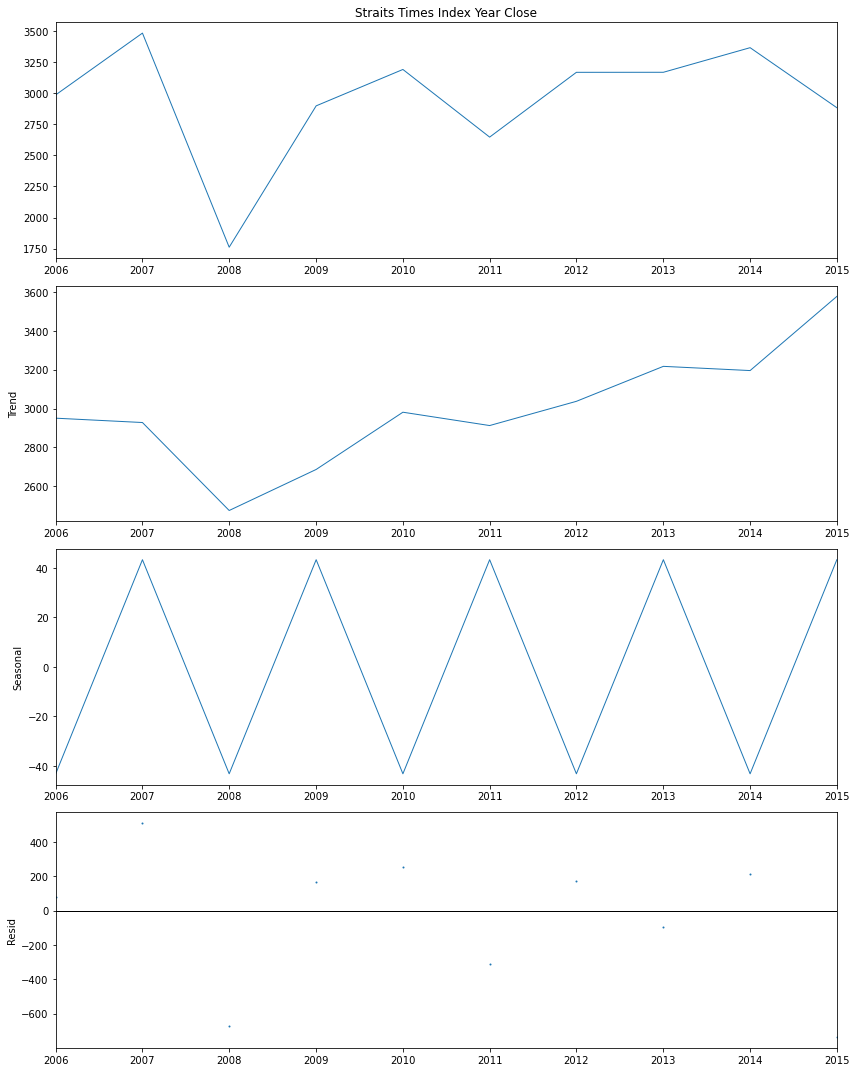

Last 5 observations:


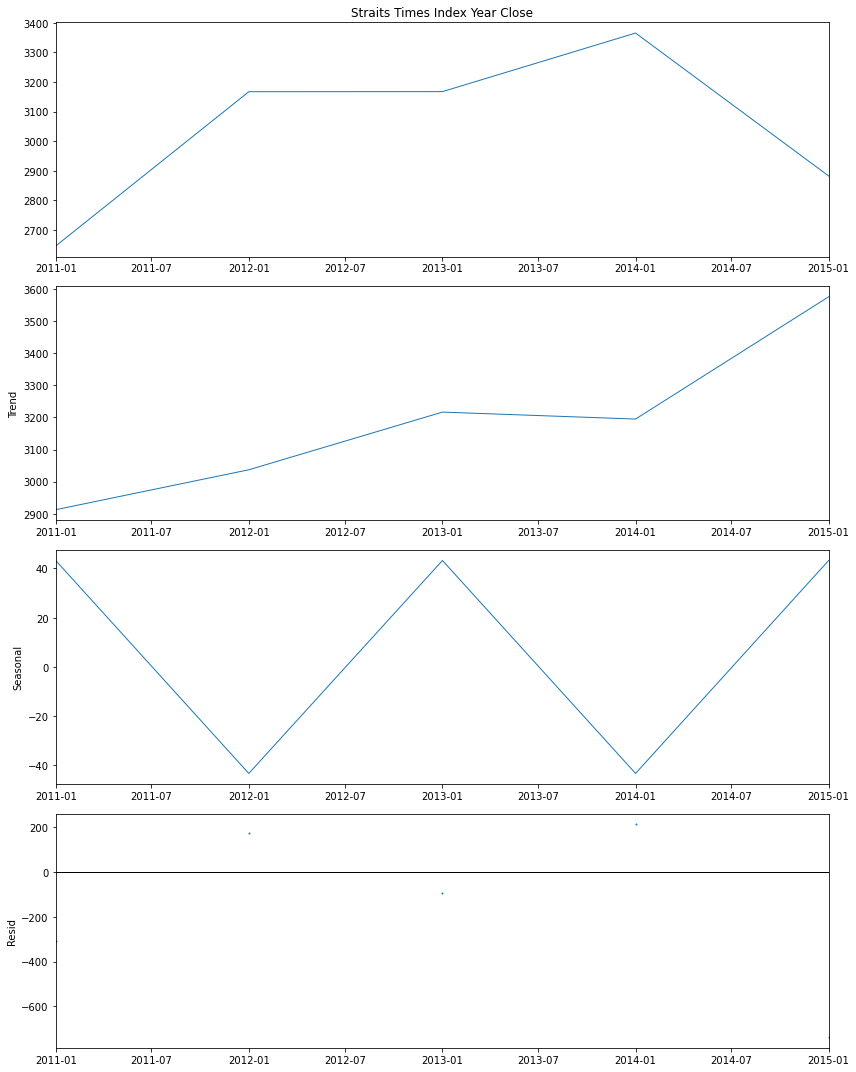

Last 2 observations:


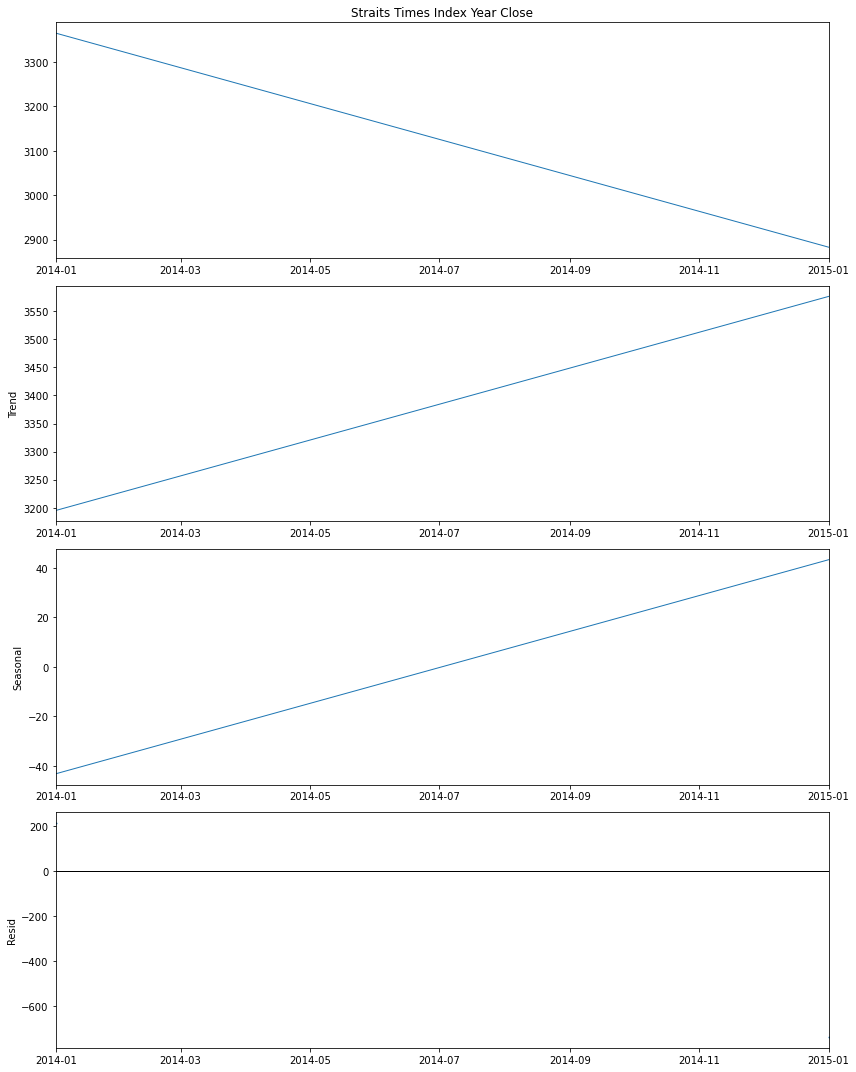


##### Time Series Decomposition for Singapore Real interest rate (%) #####


Time Series Decomposition (Additive) for 30 observations:


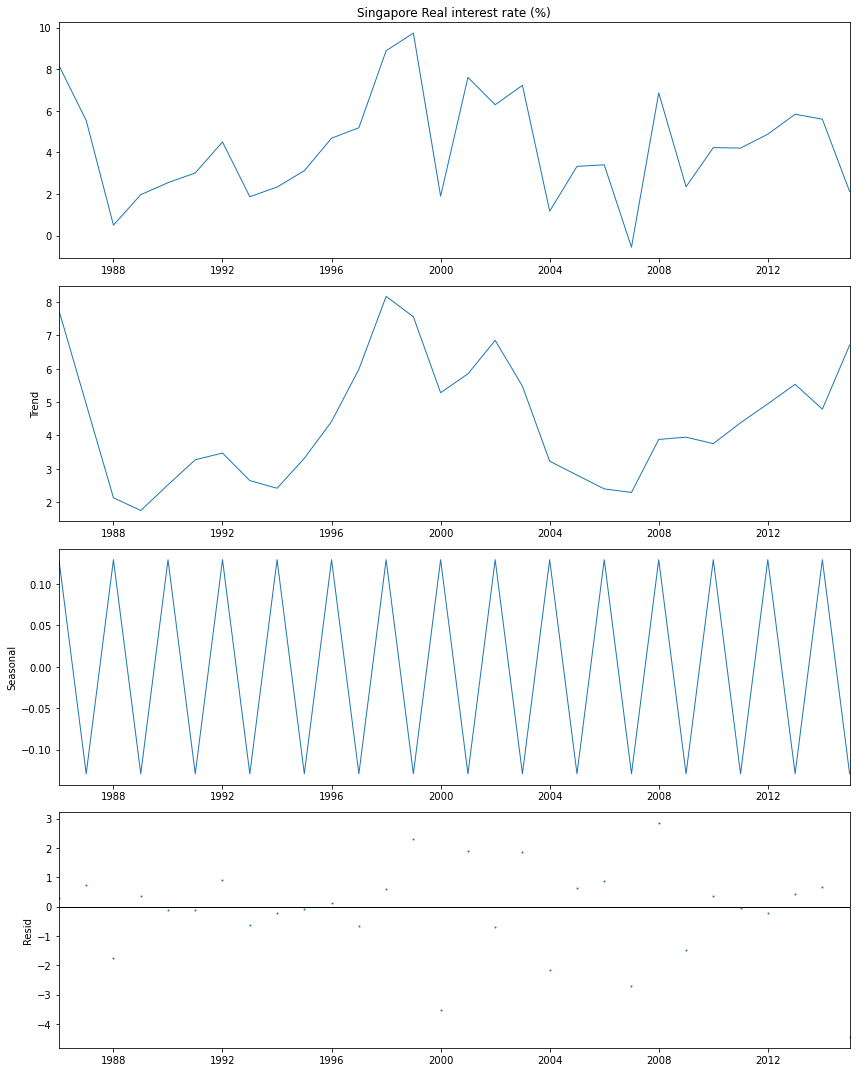

Last 10 observations:


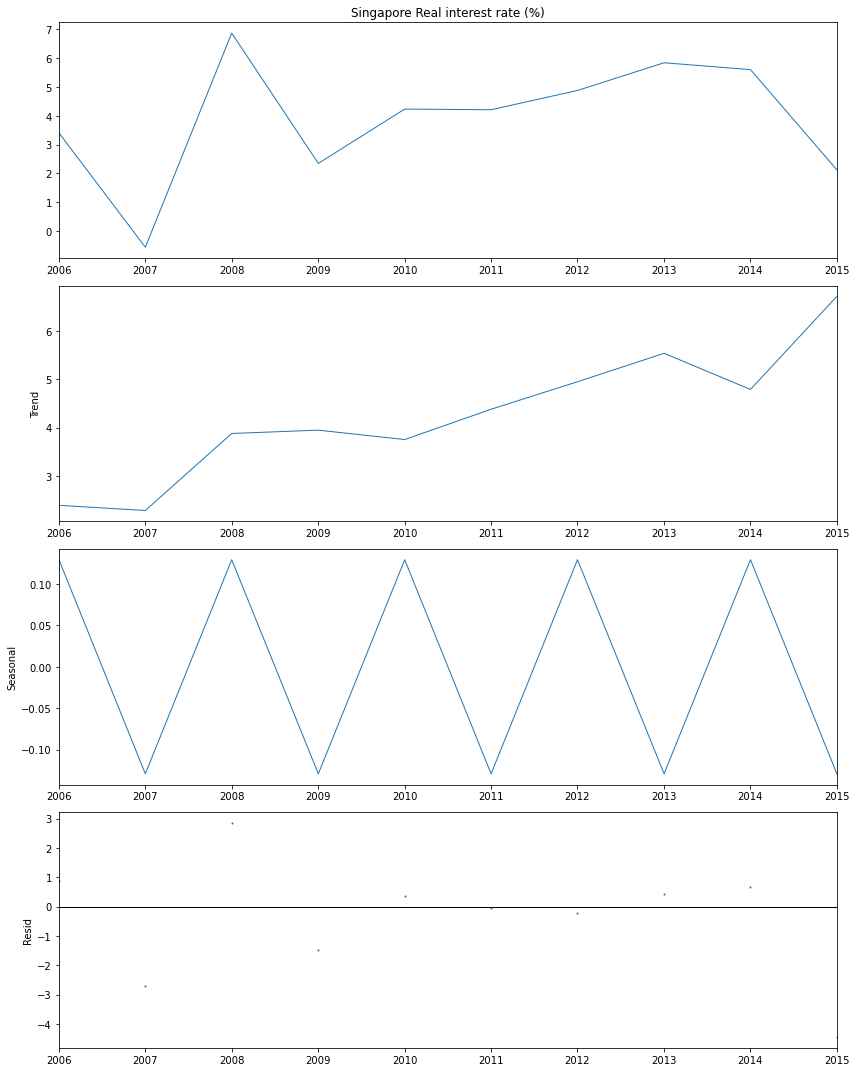

Last 5 observations:


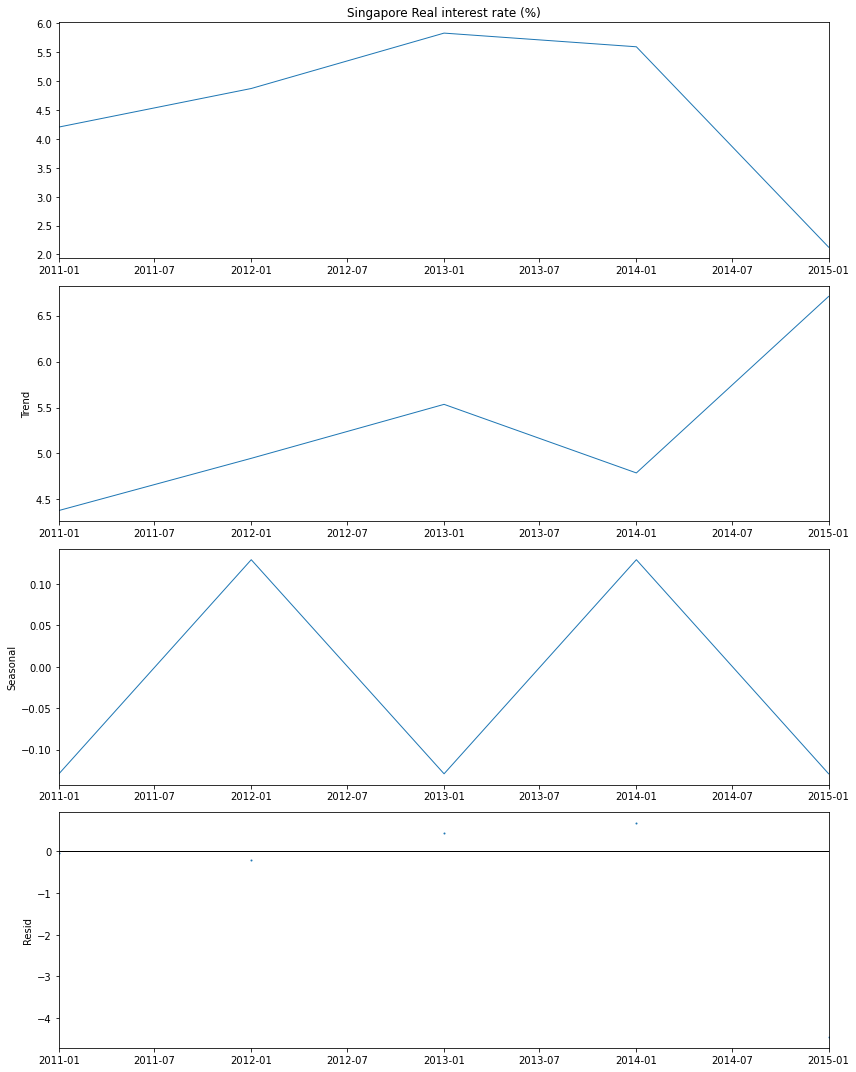

Last 2 observations:


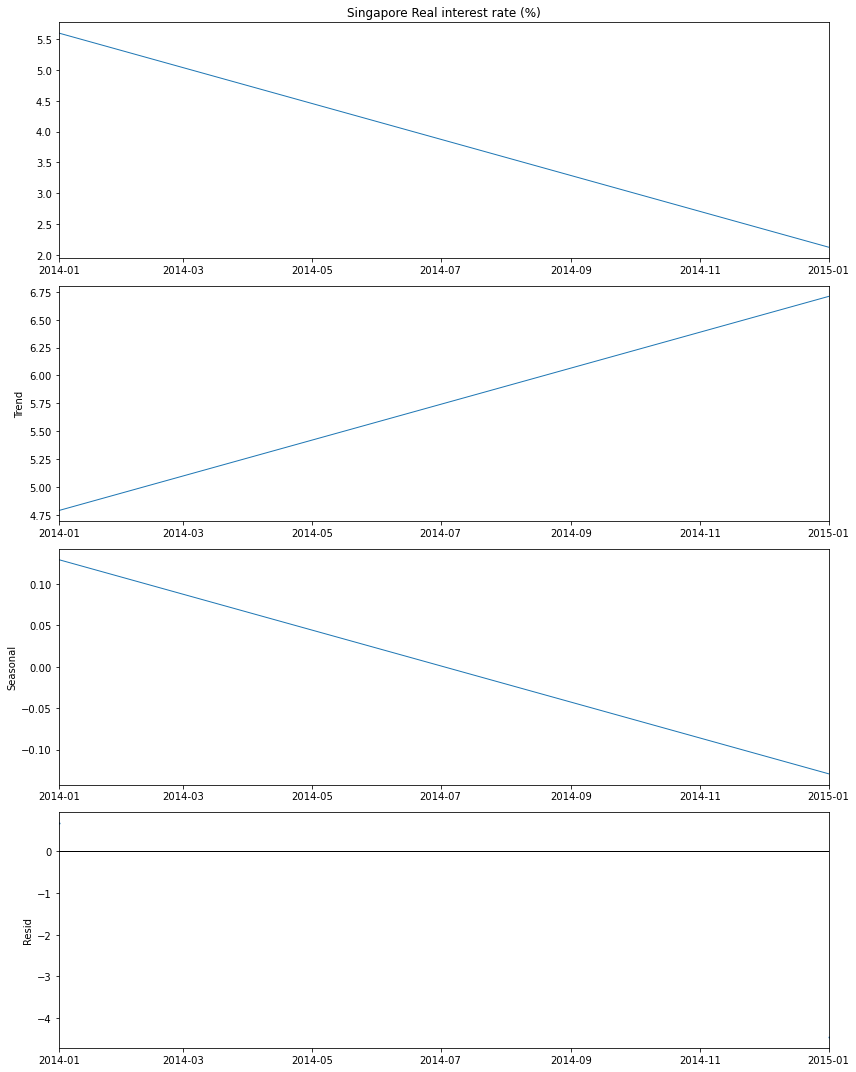


##### Time Series Decomposition for United States Real interest rate (%) #####


Time Series Decomposition (Additive) for 30 observations:


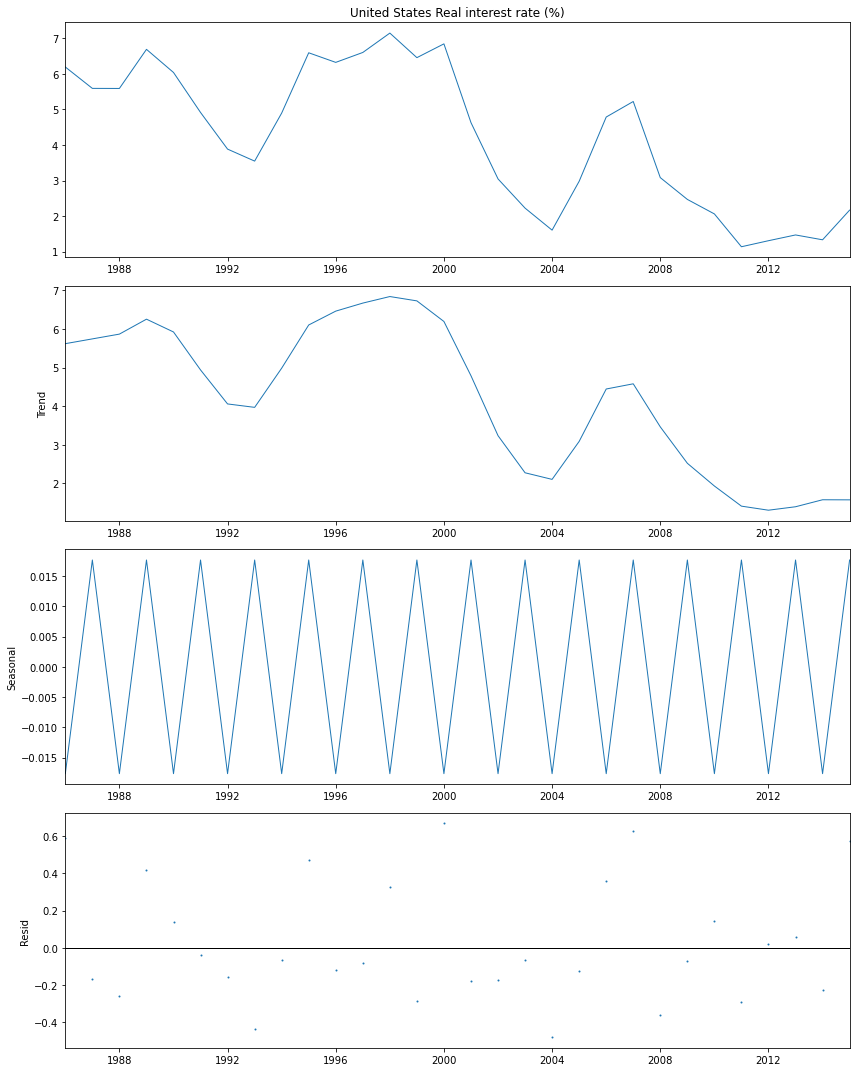

Last 10 observations:


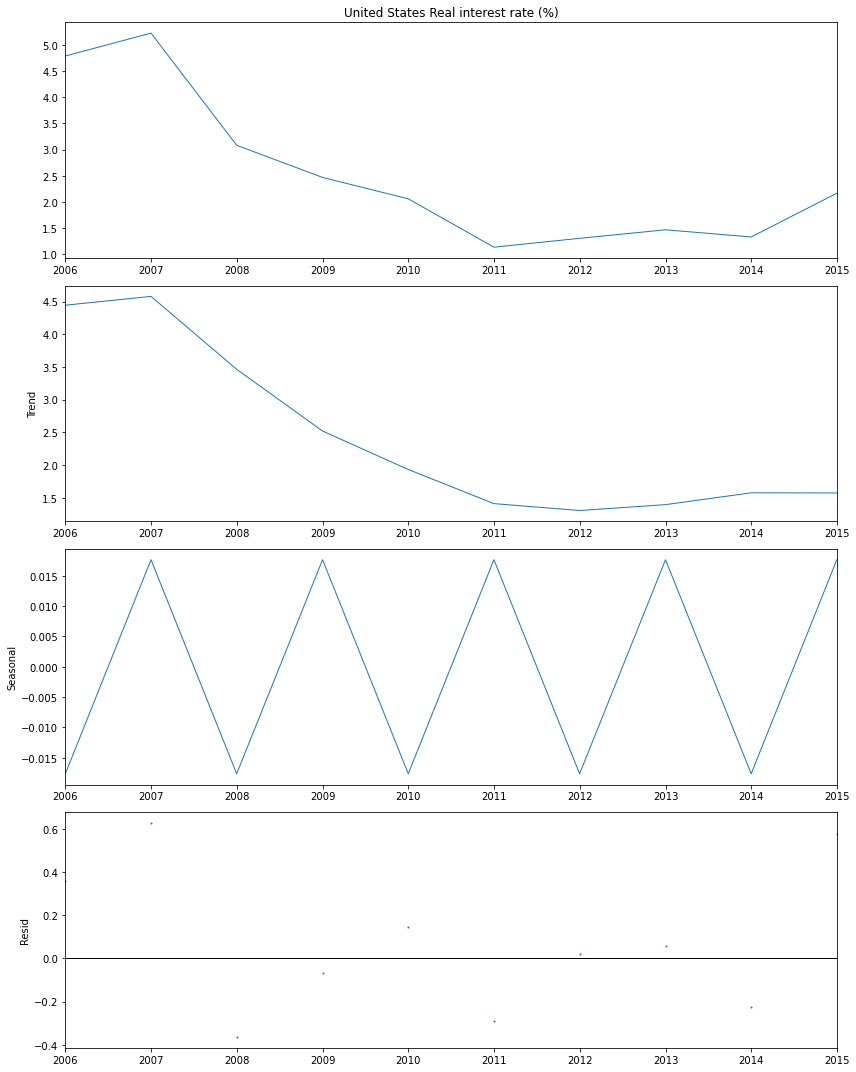

Last 5 observations:


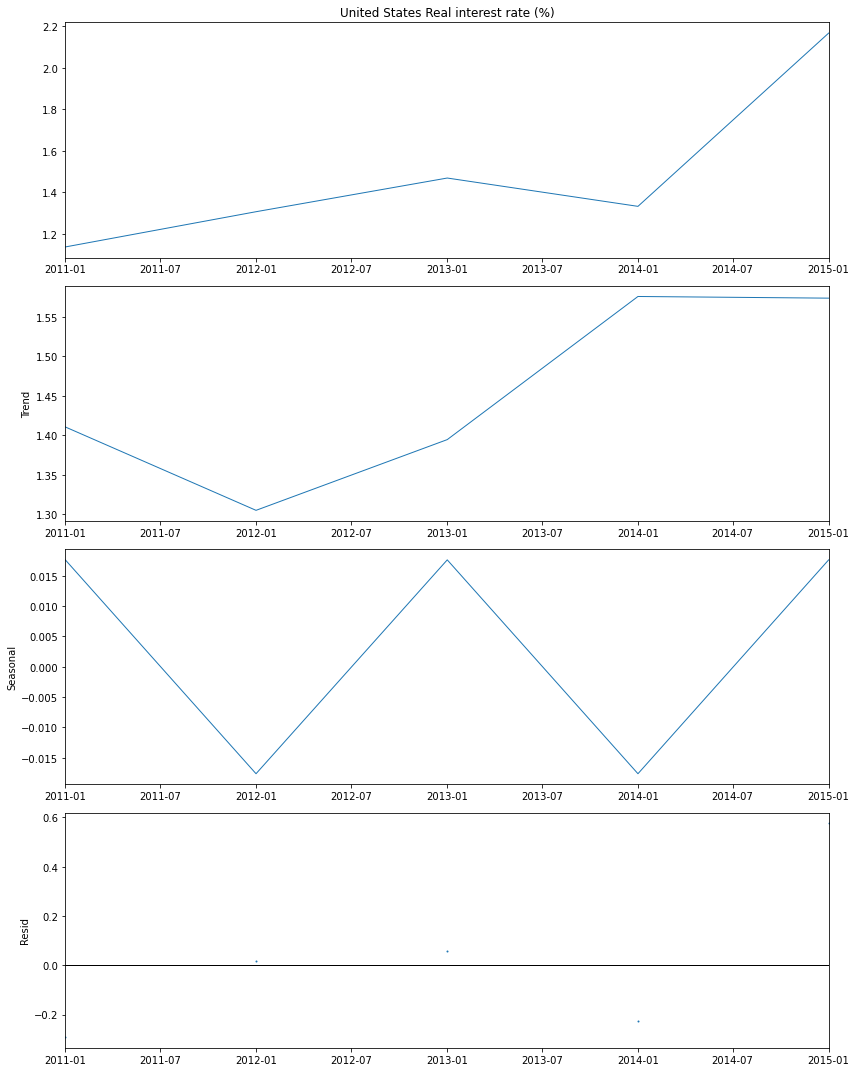

Last 2 observations:


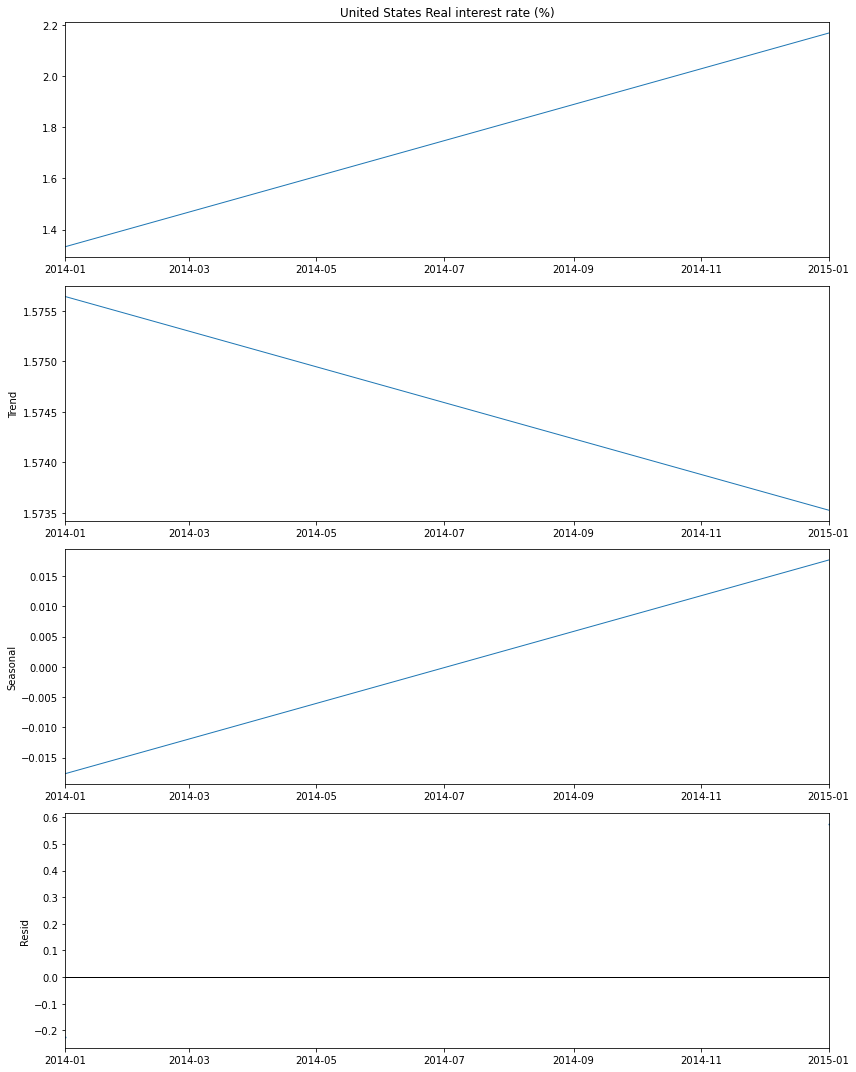


##### Time Series Decomposition for Common Shares Outstanding #####


Time Series Decomposition (Additive) for 30 observations:


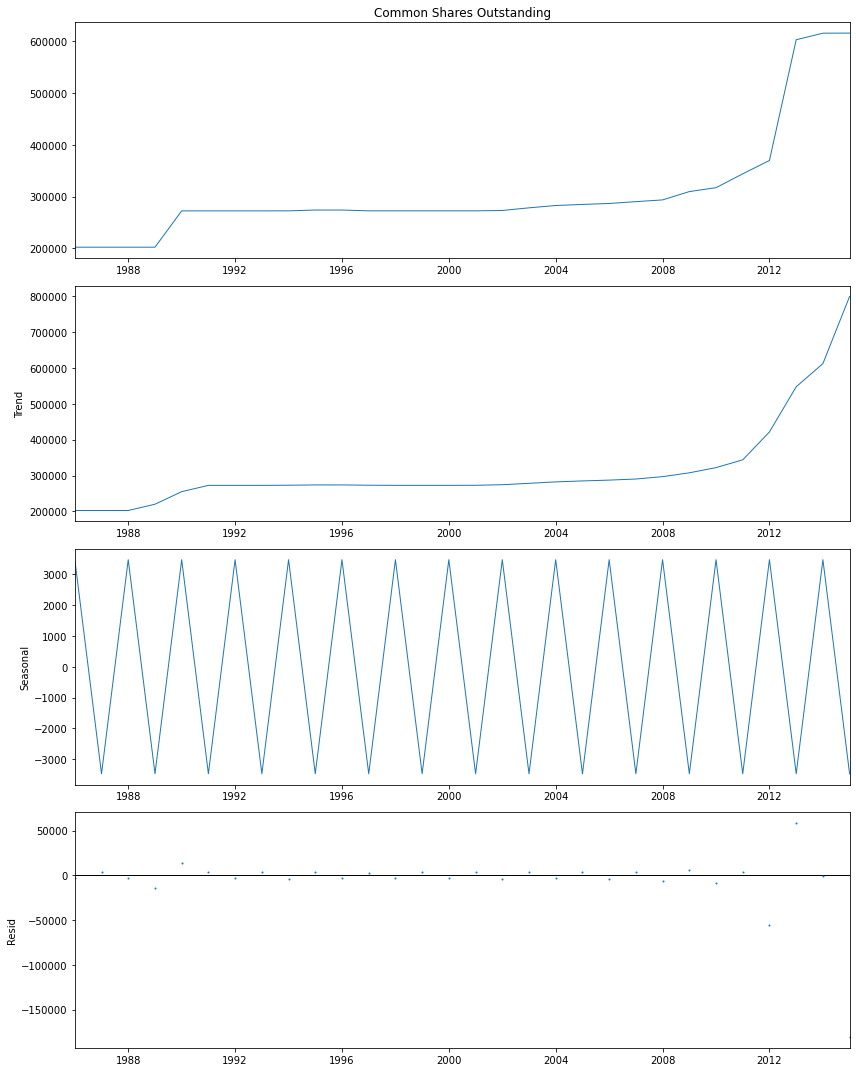

Last 10 observations:


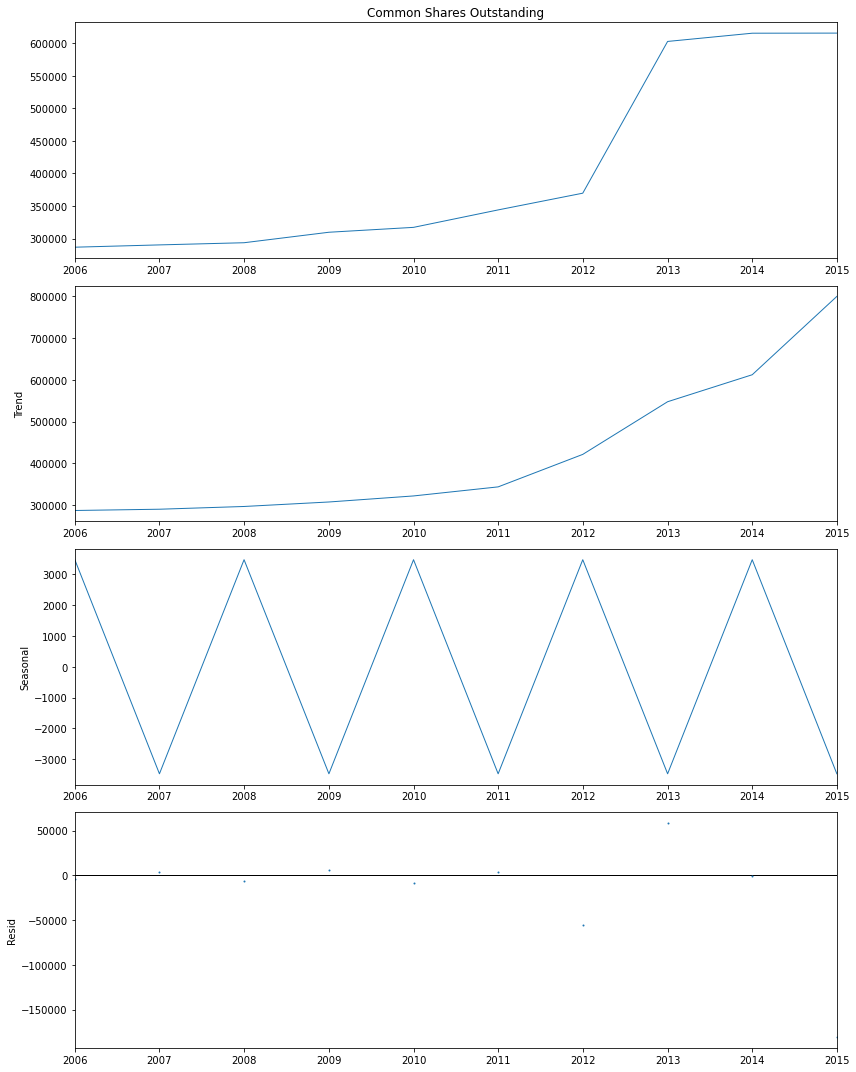

Last 5 observations:


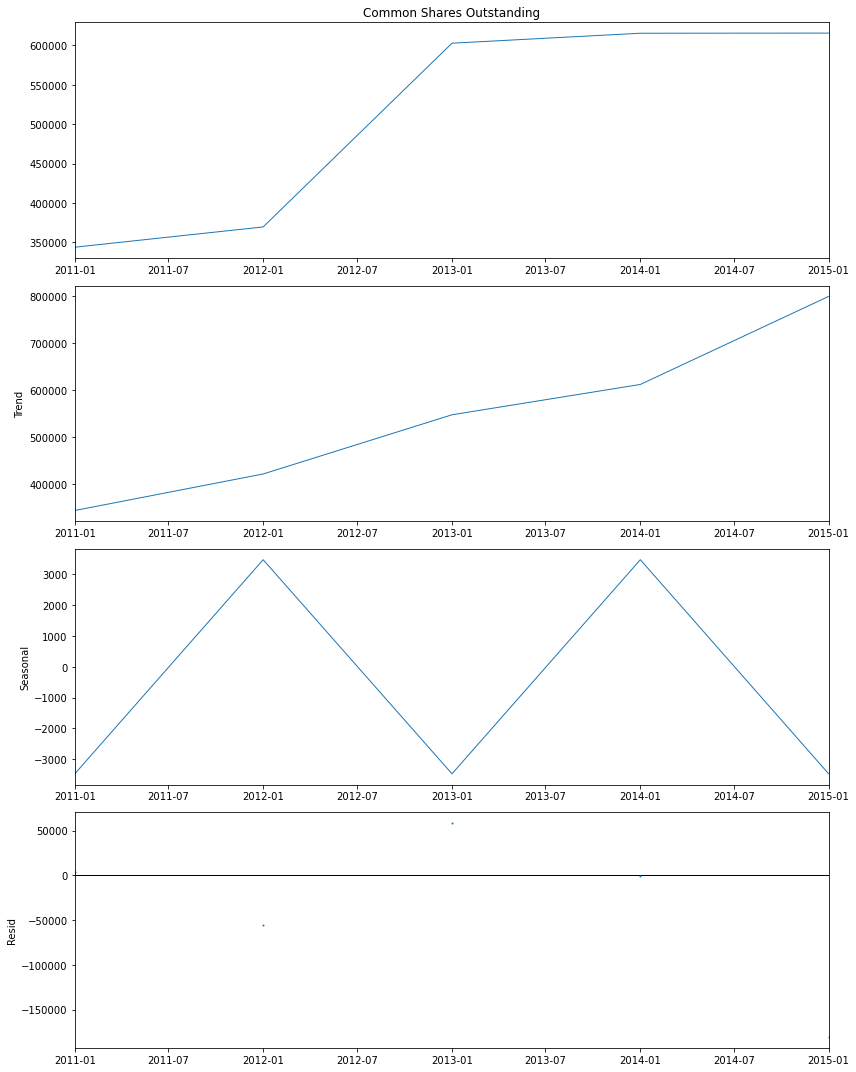

Last 2 observations:


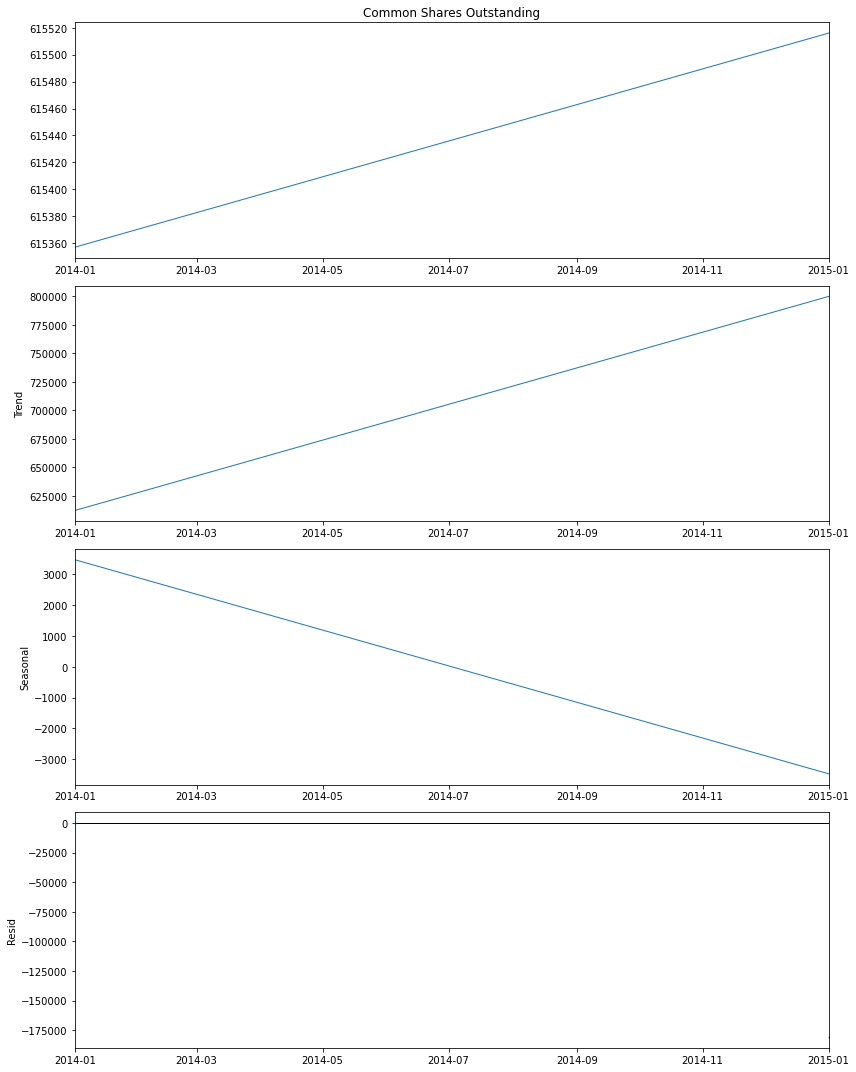

In [37]:
# Time series decomposition for exogenous variables
for var in list(df.columns[1:]):
    print("\n##### Time Series Decomposition for",var,"#####\n")
    ts_decomp(df[var], model_type='add', time_windows=[10, 5, 2], freq=2)

In [38]:
# Scaling time series data
ts_scaler = StandardScaler().fit(ts)
ts_scaled = pd.DataFrame(ts_scaler.transform(ts), columns=list(df.columns)[0:1], index=list(df.index))
ts_scaled

Net Sales Or Revenues
1986-01-01              -0.876391
1987-01-01              -0.888012
1988-01-01              -0.890384
1989-01-01              -0.857396
1990-01-01              -0.747602
1991-01-01              -0.722478
1992-01-01              -0.605726
1993-01-01              -0.571799
1994-01-01              -0.503452
1995-01-01              -0.376981
1996-01-01              -0.189385
1997-01-01              -0.283709
1998-01-01              -0.369188
1999-01-01              -0.279226
2000-01-01              -0.336144
2001-01-01              -0.268687
2002-01-01              -0.220378
2003-01-01              -0.234229
2004-01-01              -0.033232
2005-01-01               0.071316
2006-01-01               0.056342
2007-01-01              -0.121649
2008-01-01               0.000540
2009-01-01               0.126725
2010-01-01               0.425005
2011-01-01               0.856069
2012-01-01              -0.036212
2013-01-01               2.102191
2014-01-01               3.907261
2015-01-01               1.866813

In [39]:
# Scaling exogenous variables
exog_vars = df.drop(columns=['Net Sales Or Revenues'], inplace=False).copy()
exog_scaler = StandardScaler().fit(exog_vars)
exog_scaled = pd.DataFrame(exog_scaler.transform(exog_vars), columns=list(df.columns)[1:], index=list(df.index))
exog_scaled

Straits Times Index Year Close  Singapore Real interest rate (%)  \
1986-01-01                       -1.595945                          1.556842   
1987-01-01                       -1.683976                          0.501783   
1988-01-01                       -1.404441                         -1.511326   
1989-01-01                       -0.828952                         -0.925510   
1990-01-01                       -1.253832                         -0.695409   
1991-01-01                       -0.816771                         -0.507854   
1992-01-01                       -0.772964                          0.087388   
1993-01-01                        0.398631                         -0.965472   
1994-01-01                        0.156689                         -0.779048   
1995-01-01                        0.191761                         -0.465912   
1996-01-01                        0.127090                          0.159794   
1997-01-01                       -0.765892                          0.360490   
1998-01-01                       -0.944125                          1.840392   
1999-01-01                        0.468697                          2.179585   
2000-01-01                       -0.249836                         -0.954726   
2001-01-01                       -0.644011                          1.327793   
2002-01-01                       -1.011331                          0.802802   
2003-01-01                       -0.460826                          1.175979   
2004-01-01                       -0.068743                         -1.242369   
2005-01-01                        0.296795                         -0.381949   
2006-01-01                        1.126783                         -0.351963   
2007-01-01                        1.772156                         -1.935279   
2008-01-01                       -0.464674                          1.031197   
2009-01-01                        1.012117                         -0.773907   
2010-01-01                        1.392240                         -0.021205   
2011-01-01                        0.685485                         -0.030743   
2012-01-01                        1.362394                          0.236326   
2013-01-01                        1.362849                          0.620063   
2014-01-01                        1.619870                          0.525316   
2015-01-01                        0.992761                         -0.863079   

            United States Real interest rate (%)  Common Shares Outstanding  
1986-01-01                              0.994788                  -0.987342  
1987-01-01                              0.690505                  -0.987342  
1988-01-01                              0.689392                  -0.987342  
1989-01-01                              1.246205                  -0.987342  
1990-01-01                              0.916796                  -0.333541  
1991-01-01                              0.347807                  -0.333541  
1992-01-01                             -0.173979                  -0.333541  
1993-01-01                             -0.344794                  -0.333522  
1994-01-01                              0.339206                  -0.333028  
1995-01-01                              1.197308                  -0.318579  
1996-01-01                              1.060646                  -0.318495  
1997-01-01                              1.202033                  -0.332897  
1998-01-01                              1.477717                  -0.332869  
1999-01-01                              1.128013                  -0.332869  
2000-01-01                              1.324210                  -0.332878  
2001-01-01                              0.201765                  -0.332878  
2002-01-01                             -0.598634                  -0.326526  
2003-01-01                             -1.014079                  -0.278787  
2004-01-01                             -1.327578 

Stationarity of all the features are checked using the Augmented Dickey-Fuller Test. If the p-value <= 0.05 (significance level), the feature can be considered as stationary.

In [40]:
# Check stationary / non-stationary of exogenous variables
def check_stationarity(df):
    is_stationary = []
    
    for item in list(df.columns):
        result = adfuller(df[item].dropna(inplace=False))

        print('\n###',item,'###\n')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')

        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

        if result[1] <= 0.05:
            print('\nTime Series for',item,'is stationary. (d=0)')
            is_stationary.append(True)
        else:
            print('\nTime Series for',item,'is not stationary. (d>0)')
            is_stationary.append(False)

    return is_stationary

exog_stationary = check_stationarity(df.iloc[:,1:])
exog_stationary


### Straits Times Index Year Close ###

ADF Statistic: 1.455180
p-value: 0.997351
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651

Time Series for Straits Times Index Year Close is not stationary. (d>0)

### Singapore Real interest rate (%) ###

ADF Statistic: -4.698082
p-value: 0.000085
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

Time Series for Singapore Real interest rate (%) is stationary. (d=0)

### United States Real interest rate (%) ###

ADF Statistic: -2.044181
p-value: 0.267543
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625

Time Series for United States Real interest rate (%) is not stationary. (d>0)

### Common Shares Outstanding ###

ADF Statistic: 1.339856
p-value: 0.996823
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636

Time Series for Common Shares Outstanding is not stationary. (d>0)


[False, True, False, False]

In [41]:
# Exogenous Variables Forecast
exog_data = exog_scaled.copy()
exog_forecast = pd.DataFrame()

for i in range(len(list(exog_data.columns))):
    var = list(exog_data.columns)[i]
    data = exog_data[var].dropna(inplace=False).copy()
    
    exog_predict = auto_arima(data,
                              start_p=0, max_p=5, 
                              start_q=0, max_q=5, 
                              max_d=3, max_order=12,
                              seasonal=True, m=2,
                              stationary=exog_stationary[i],
                              transparams=True,
                              information_criterion='aic',
                              out_of_sample_size=5,
                              trace=True,
                              stepwise=True,
                              suppress_warnings=True,
                              scoring='mse',
                              random_state=42)
    
    results = exog_predict.predict(n_periods=5)
    exog_forecast[var] = results
    print('\n')
    
forecast_date = pd.date_range(start='01/01/2016',end='01/02/2020',freq='YS')
exog_forecast.set_index(forecast_date, inplace=True)

exog_data = pd.concat([exog_data,exog_forecast],axis=0)
exog_data

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 2) (constant=True); AIC=72.060, BIC=77.529, Time=0.243 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 2) (constant=True); AIC=69.178, BIC=71.912, Time=0.123 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 2) (constant=True); AIC=65.821, BIC=71.291, Time=0.201 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 2) (constant=True); AIC=64.430, BIC=69.899, Time=0.211 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 2) (constant=False); AIC=67.592, BIC=68.959, Time=0.061 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 2) (constant=True); AIC=62.981, BIC=67.083, Time=0.152 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 0, 2) (constant=True); AIC=64.592, BIC=70.061, Time=0.202 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 1, 2) (constant=True); AIC=66.342, BIC=73.179, Time=0.674 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 2) (constant=True); AIC=62.165, BIC=67.634, Time=0.819 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 2); setting score to inf (at least one inverse root too

Straits Times Index Year Close  Singapore Real interest rate (%)  \
1986-01-01                       -1.595945                          1.556842   
1987-01-01                       -1.683976                          0.501783   
1988-01-01                       -1.404441                         -1.511326   
1989-01-01                       -0.828952                         -0.925510   
1990-01-01                       -1.253832                         -0.695409   
1991-01-01                       -0.816771                         -0.507854   
1992-01-01                       -0.772964                          0.087388   
1993-01-01                        0.398631                         -0.965472   
1994-01-01                        0.156689                         -0.779048   
1995-01-01                        0.191761                         -0.465912   
1996-01-01                        0.127090                          0.159794   
1997-01-01                       -0.765892                          0.360490   
1998-01-01                       -0.944125                          1.840392   
1999-01-01                        0.468697                          2.179585   
2000-01-01                       -0.249836                         -0.954726   
2001-01-01                       -0.644011                          1.327793   
2002-01-01                       -1.011331                          0.802802   
2003-01-01                       -0.460826                          1.175979   
2004-01-01                       -0.068743                         -1.242369   
2005-01-01                        0.296795                         -0.381949   
2006-01-01                        1.126783                         -0.351963   
2007-01-01                        1.772156                         -1.935279   
2008-01-01                       -0.464674                          1.031197   
2009-01-01                        1.012117                         -0.773907   
2010-01-01                        1.392240                         -0.021205   
2011-01-01                        0.685485                         -0.030743   
2012-01-01                        1.362394                          0.236326   
2013-01-01                        1.362849                          0.620063   
2014-01-01                        1.619870                          0.525316   
2015-01-01                        0.992761                         -0.863079   
2016-01-01                        1.327196                          0.000000   
2017-01-01                        1.491265                          0.000000   
2018-01-01                        1.605029                          0.000000   
2019-01-01                        1.703941                          0.000000   
2020-01-01                        1.798467                          0.000000   

            United States Real interest rate (%)  Common Shares Outstanding  
1986-01-01                              0.994788                  -0.987342  
1987-01-01                              0.690505                  -0.987342  
1988-01-01                              0.689392                  -0.987342  
1989-01-01                              1.246205                  -0.987342  
1990-01-01                              0.916796                  -0.333541  
1991-01-01                              0.347807                  -0.333541  
1992-01-01                             -0.173979                  -0.333541  
1993-01-01                             -0.344794                  -0.333522  
1994-01-01                              0.339206                  -0.333028  
1995-01-01                              1.197308                  -0.318579  
1996-01-01                              1.060646                  -0.318495  
1997-01-01                              1.202033                  -0.332897  
1998-01-01                              1.477717                  -0.332869  
1999-01-01                             

In [42]:
# Creating lagged variables
df2 = pd.concat([ts_scaled,exog_data], axis=1, join='outer')
lags = [1, 2, 3]

for item in list(df2.columns[:]):
    for i in lags:
        key = item + '-' + str(i)
        df2[key] = df2[item].shift(i)

df2 = df2[np.max(lags):]
exog_data = df2.copy()
exog_data

Net Sales Or Revenues  Straits Times Index Year Close  \
1989-01-01              -0.857396                       -0.828952   
1990-01-01              -0.747602                       -1.253832   
1991-01-01              -0.722478                       -0.816771   
1992-01-01              -0.605726                       -0.772964   
1993-01-01              -0.571799                        0.398631   
1994-01-01              -0.503452                        0.156689   
1995-01-01              -0.376981                        0.191761   
1996-01-01              -0.189385                        0.127090   
1997-01-01              -0.283709                       -0.765892   
1998-01-01              -0.369188                       -0.944125   
1999-01-01              -0.279226                        0.468697   
2000-01-01              -0.336144                       -0.249836   
2001-01-01              -0.268687                       -0.644011   
2002-01-01              -0.220378                       -1.011331   
2003-01-01              -0.234229                       -0.460826   
2004-01-01              -0.033232                       -0.068743   
2005-01-01               0.071316                        0.296795   
2006-01-01               0.056342                        1.126783   
2007-01-01              -0.121649                        1.772156   
2008-01-01               0.000540                       -0.464674   
2009-01-01               0.126725                        1.012117   
2010-01-01               0.425005                        1.392240   
2011-01-01               0.856069                        0.685485   
2012-01-01              -0.036212                        1.362394   
2013-01-01               2.102191                        1.362849   
2014-01-01               3.907261                        1.619870   
2015-01-01               1.866813                        0.992761   
2016-01-01                    NaN                        1.327196   
2017-01-01                    NaN                        1.491265   
2018-01-01                    NaN                        1.605029   
2019-01-01                    NaN                        1.703941   
2020-01-01                    NaN                        1.798467   

            Singapore Real interest rate (%)  \
1989-01-01                         -0.925510   
1990-01-01                         -0.695409   
1991-01-01                         -0.507854   
1992-01-01                          0.087388   
1993-01-01                         -0.965472   
1994-01-01                         -0.779048   
1995-01-01                         -0.465912   
1996-01-01                          0.159794   
1997-01-01                          0.360490   
1998-01-01                          1.840392   
1999-01-01                          2.179585   
2000-01-01                         -0.954726   
2001-01-01                          1.327793   
2002-01-01                          0.802802   
2003-01-01                          1.175979   
2004-01-01                         -1.242369   
2005-01-01                         -0.381949   
2006-01-01                         -0.351963   
2007-01-01                         -1.935279   
2008-01-01                          1.031197   
2009-01-01                         -0.773907   
2010-01-01                         -0.021205   
2011-01-01                         -0.030743   
2012-01-01                          0.236326   
2013-01-01                          0.620063   
2014-01-01                          0.525316   
2015-01-01                         -0.863079   
2016-01-01                          0.000000   
2017-01-01                          0.000000   
2018-01-01                          0.000000   
2019-01-01                          0.000000   
2020-01-01                          0.000000   

            United States Real interest rate (%)  Common Shares Outstanding  \
1989-01-01                              1.246205                  -0.9

In [43]:
check_stationarity(exog_data)


### Net Sales Or Revenues ###

ADF Statistic: 2.232956
p-value: 0.998909
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667

Time Series for Net Sales Or Revenues is not stationary. (d>0)

### Straits Times Index Year Close ###

ADF Statistic: -1.163530
p-value: 0.689084
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623

Time Series for Straits Times Index Year Close is not stationary. (d>0)

### Singapore Real interest rate (%) ###

ADF Statistic: -4.982915
p-value: 0.000024
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619

Time Series for Singapore Real interest rate (%) is stationary. (d=0)

### United States Real interest rate (%) ###

ADF Statistic: -0.340279
p-value: 0.919603
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628

Time Series for United States Real interest rate (%) is not stationary. (d>0)

### Common Shares Outstanding ###

ADF Statistic: 3.080414
p-value: 1.000000
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639

Time Series for Common Shares 

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False]

### SARIMAX (Auto ARIMA with Backward Stepwise Selection)

Features are dropped based on their significance (p-value), and models are re-evaluated based on model parsimony (AIC).

In [44]:
# Initial auto_arima() model with full exogenous variables set
stepwise_model = auto_arima(exog_data['Net Sales Or Revenues'][:-5],
                            exogenous=exog_data.drop(columns=['Net Sales Or Revenues'],inplace=False)[:-5],
                            start_p=0, max_p=5, 
                            start_q=0, max_q=5, 
                            max_d=3, max_order=12,
                            seasonal=True, m=2,
                            stationary=False,
                            transparams=True,
                            information_criterion='aic',
                            out_of_sample_size=5,
                            trace=True,
                            stepwise=True,
                            suppress_warnings=True,
                            scoring='mse',
                            random_state=42)
print('Current Model AIC =', stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 2) (constant=True); AIC=77.271, BIC=105.305, Time=3.502 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 2) (constant=True); AIC=58.616, BIC=84.213, Time=1.312 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 2) (constant=True); AIC=86.389, BIC=114.424, Time=2.317 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 2) (constant=True); AIC=71.430, BIC=99.464, Time=2.938 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 2) (constant=False); AIC=51.610, BIC=75.987, Time=1.180 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 2) (constant=True); AIC=78.513, BIC=105.328, Time=1.964 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 2) (constant=True); AIC=81.247, BIC=108.062, Time=2.257 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 2) (constant=True); AIC=60.082, BIC=86.897, Time=1.691 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 2) (constant=True); AIC=55.500, BIC=82.315, Time=2.232 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 2) (constant=True); AIC=66.779, BIC=94.813, Time=4.877 seconds
Total fit ti

In [45]:
# Backward Stepwise Variable Selection
best_aic = stepwise_model.aic()
best_model = stepwise_model
all_vars = list(exog_data.columns[1:])

for i in range(len(all_vars)):
    temp_var = all_vars.pop(np.argmax(best_model.pvalues())-1)
    
    stepwise_model = auto_arima(exog_data['Net Sales Or Revenues'][:-5],
                                exogenous=exog_data[all_vars][:-5],
                                start_p=0, max_p=5, 
                                start_q=0, max_q=5, 
                                max_d=3, max_order=12,
                                seasonal=True, m=2,
                                stationary=False,
                                transparams=True,
                                information_criterion='aic',
                                out_of_sample_size=5,
                                trace=True,
                                stepwise=True,
                                suppress_warnings=True,
                                scoring='mse',
                                random_state=42)
    
    if stepwise_model.aic() <= best_aic:
        best_aic = stepwise_model.aic()
        best_model = stepwise_model
    else:
        all_vars += [temp_var]
        print('\n##### ENDED #####\n')
        print('Best features:', all_vars)
        print('Best AIC =', best_aic)
        best_model.summary()
        break

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 2) (constant=True); AIC=107.278, BIC=134.093, Time=3.135 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 2) (constant=True); AIC=97.040, BIC=121.417, Time=1.115 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 2) (constant=True); AIC=100.012, BIC=126.828, Time=2.366 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 2) (constant=True); AIC=95.735, BIC=122.550, Time=2.336 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 2) (constant=False); AIC=82.457, BIC=105.615, Time=0.512 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 0, 2) (constant=True); AIC=100.332, BIC=125.928, Time=1.930 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 2) (constant=True); AIC=100.493, BIC=126.089, Time=2.048 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 2) (constant=True); AIC=90.483, BIC=116.079, Time=1.265 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 0, 2) (constant=True); AIC=84.597, BIC=110.194, Time=1.618 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 2) (constant=True); AIC=99.375, BIC=126.190, Time=1.684 seconds
To

In [46]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                   27
Model:             SARIMAX(0, 1, 0, 2)   Log Likelihood                  -5.805
Date:                 Wed, 22 Apr 2020   AIC                             51.610
Time:                         00:45:17   BIC                             75.987
Sample:                              0   HQIC                            58.371
                                  - 27                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0839      0.408      0.205      0.837      -0.717       0.884
x2             0.1575      0.272      0.580      0.562      -0.375       0.690
x3            -0.0560      0.363     -0.154      0.878      -0.768       0.656
x4             0.9759      1.021      0.956      0.339      -1.025       2.977
x5             0.3680      1.081      0.340      0.734      -1.750       2.486
x6            -0.8552      1.867     -0.458      0.647      -4.514       2.804
x7             0.2705      1.367      0.198      0.843      -2.409       2.950
x8             0.1088      0.523      0.208      0.835      -0.916       1.134
x9            -0.1070      0.438     -0.244      0.807      -0.965       0.751
x10            0.1065      0.435      0.245      0.807      -0.747       0.960
x11            0.0010      0.436      0.002      0.998      -0.853       0.855
x12            0.0888      0.329      0.270      0.787      -0.556       0.733
x13            0.0732      0.261      0.281      0.779      -0.438       0.584
x14            0.0582      0.451      0.129      0.897      -0.826       0.942
x15           -0.0210      0.803     -0.026      0.979      -1.595       1.552
x16           -0.1442      0.488     -0.296      0.768      -1.100       0.812
x17           -0.1234      1.923     -0.064      0.949      -3.893       3.646
x18            0.1125      1.633      0.069      0.945      -3.088       3.313
x19           -0.2558      1.578     -0.162      0.871      -3.348       2.837
sigma2         0.0675      0.049      1.382      0.167      -0.028       0.163
===================================================================================
Ljung-Box (Q):                       12.01   Jarque-Bera (JB):                 5.14
Prob(Q):                              0.98   Prob(JB):                         0.08
Heteroskedasticity (H):              20.67   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# Forecasted 5 future values of Revenue
for i in range(5):
    if i==4:
        exog_predict = exog_data[all_vars][-5+i:]
    else:
        exog_predict = exog_data[all_vars][-5+i:-4+i]
    
    ts_results = best_model.predict(n_periods=1, exogenous=exog_predict)
    
    if i==0:
        exog_data['Net Sales Or Revenues'][-5] = ts_results
        exog_data['Net Sales Or Revenues-1'][-4] = ts_results
        exog_data['Net Sales Or Revenues-2'][-3] = ts_results
        exog_data['Net Sales Or Revenues-3'][-2] = ts_results
    elif i==1:
        exog_data['Net Sales Or Revenues'][-4] = ts_results
        exog_data['Net Sales Or Revenues-1'][-3] = ts_results
        exog_data['Net Sales Or Revenues-2'][-2] = ts_results
        exog_data['Net Sales Or Revenues-3'][-1] = ts_results
    elif i==2:
        exog_data['Net Sales Or Revenues'][-3] = ts_results
        exog_data['Net Sales Or Revenues-1'][-2] = ts_results
        exog_data['Net Sales Or Revenues-2'][-1] = ts_results
    elif i==3:
        exog_data['Net Sales Or Revenues'][-2] = ts_results
        exog_data['Net Sales Or Revenues-1'][-1] = ts_results
    elif i==4:
        exog_data['Net Sales Or Revenues'][-1] = ts_results

exog_data

Net Sales Or Revenues  Straits Times Index Year Close  \
1989-01-01              -0.857396                       -0.828952   
1990-01-01              -0.747602                       -1.253832   
1991-01-01              -0.722478                       -0.816771   
1992-01-01              -0.605726                       -0.772964   
1993-01-01              -0.571799                        0.398631   
1994-01-01              -0.503452                        0.156689   
1995-01-01              -0.376981                        0.191761   
1996-01-01              -0.189385                        0.127090   
1997-01-01              -0.283709                       -0.765892   
1998-01-01              -0.369188                       -0.944125   
1999-01-01              -0.279226                        0.468697   
2000-01-01              -0.336144                       -0.249836   
2001-01-01              -0.268687                       -0.644011   
2002-01-01              -0.220378                       -1.011331   
2003-01-01              -0.234229                       -0.460826   
2004-01-01              -0.033232                       -0.068743   
2005-01-01               0.071316                        0.296795   
2006-01-01               0.056342                        1.126783   
2007-01-01              -0.121649                        1.772156   
2008-01-01               0.000540                       -0.464674   
2009-01-01               0.126725                        1.012117   
2010-01-01               0.425005                        1.392240   
2011-01-01               0.856069                        0.685485   
2012-01-01              -0.036212                        1.362394   
2013-01-01               2.102191                        1.362849   
2014-01-01               3.907261                        1.619870   
2015-01-01               1.866813                        0.992761   
2016-01-01              -0.320071                        1.327196   
2017-01-01               1.582053                        1.491265   
2018-01-01               3.525237                        1.605029   
2019-01-01               2.274121                        1.703941   
2020-01-01               0.575248                        1.798467   

            Singapore Real interest rate (%)  \
1989-01-01                         -0.925510   
1990-01-01                         -0.695409   
1991-01-01                         -0.507854   
1992-01-01                          0.087388   
1993-01-01                         -0.965472   
1994-01-01                         -0.779048   
1995-01-01                         -0.465912   
1996-01-01                          0.159794   
1997-01-01                          0.360490   
1998-01-01                          1.840392   
1999-01-01                          2.179585   
2000-01-01                         -0.954726   
2001-01-01                          1.327793   
2002-01-01                          0.802802   
2003-01-01                          1.175979   
2004-01-01                         -1.242369   
2005-01-01                         -0.381949   
2006-01-01                         -0.351963   
2007-01-01                         -1.935279   
2008-01-01                          1.031197   
2009-01-01                         -0.773907   
2010-01-01                         -0.021205   
2011-01-01                         -0.030743   
2012-01-01                          0.236326   
2013-01-01                          0.620063   
2014-01-01                          0.525316   
2015-01-01                         -0.863079   
2016-01-01                          0.000000   
2017-01-01                          0.000000   
2018-01-01                          0.000000   
2019-01-01                          0.000000   
2020-01-01                          0.000000   

            United States Real interest rate (%)  Common Shares Outstanding  \
1989-01-01                              1.246205                  -0.9

In [48]:
# Finding model error, and using inverse_transform() to find actual forecasted values from standardized forecasted values
fitted_vals = best_model.predict_in_sample(exogenous=exog_data[all_vars][:-5],
                                           dynamic=True)

rmse = np.sqrt(mean_squared_error(fitted_vals,exog_data['Net Sales Or Revenues'][:-5]))
print('Pre-Transformed Prediction Error =', rmse)

fitted_transform = pd.DataFrame(ts_scaler.inverse_transform(fitted_vals),
                                columns=['Net Sales Or Revenues'],
                                index=list(exog_data.index)[:-5])

rmse = np.sqrt(mean_squared_error(fitted_transform,ts['Net Sales Or Revenues'][3:]))
print('\nEstimated Prediction Error =',rmse)

Pre-Transformed Prediction Error = 0.29017662013352896

Estimated Prediction Error = 192317.49843949472


### Time Series Plots

#### Historical vs Fitted

In [49]:
# Plot Revenue fitted values
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=ts.index[3:],
                y=ts['Net Sales Or Revenues'][3:],
                name="Historical",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=fitted_transform.index,
                y=fitted_transform['Net Sales Or Revenues'],
                name="Fitted",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=[list(exog_data.index)[0].strftime('%Y-%m-%d'),list(exog_data.index)[-6].strftime('%Y-%m-%d')],
                  title={'text':'Net Sales Or Revenues Fitted Values'},
                  width=1000,
                  height=600)
fig.show()

#### *Please refer to the uploaded .html file if the above plot is not displayed correctly.

#### Historical vs Forecasted

In [50]:
# Plot forecasted values against historical values
ts_forecast = pd.DataFrame(ts_scaler.inverse_transform(exog_data['Net Sales Or Revenues'][-5:]), 
                           columns=['Net Sales Or Revenues'],
                           index=list(exog_data.index)[-5:])

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=ts.index,
                y=ts['Net Sales Or Revenues'],
                name="Historical",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=exog_data.index[-6:],
                y=np.append(ts['Net Sales Or Revenues'][-1],ts_forecast.values),
                name="Forecasted",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(xaxis_range=[list(exog_data.index)[0].strftime('%Y-%m-%d'),list(exog_data.index)[-1].strftime('%Y-%m-%d')],
                  title={'text':'Net Sales Or Revenues Forecast'},
                  width=1000,
                  height=600)
fig.show()

#### *Please refer to the uploaded .html file if the above plot is not displayed correctly.

## Clustering Analysis

### Analysis 1

#### X = Cash Flow Per Share - Current (Security)
#### Y = Net Sales Or Revenues
#### Z = Reinvestment Rate - Per Share - Current

     Cash Flow Per Share - Current (Security)  Net Sales Or Revenues  \
0                                   -0.078436              -0.090821   
1                                   -0.079541              -0.090395   
2                                   -0.080784              -0.090861   
3                                   -0.082090              -0.090818   
4                                   -0.078524              -0.090651   
..                                        ...                    ...   
569                                 -0.077883              -0.090474   
570                                 -0.079365              -0.086633   
571                                 -0.080696              -0.090751   
572                                 -0.080194              -0.090824   
573                                 -0.079290              -0.090403   

     Reinvestment Rate - Per Share - Current  
0                                   1.021870  
1                                   0.055

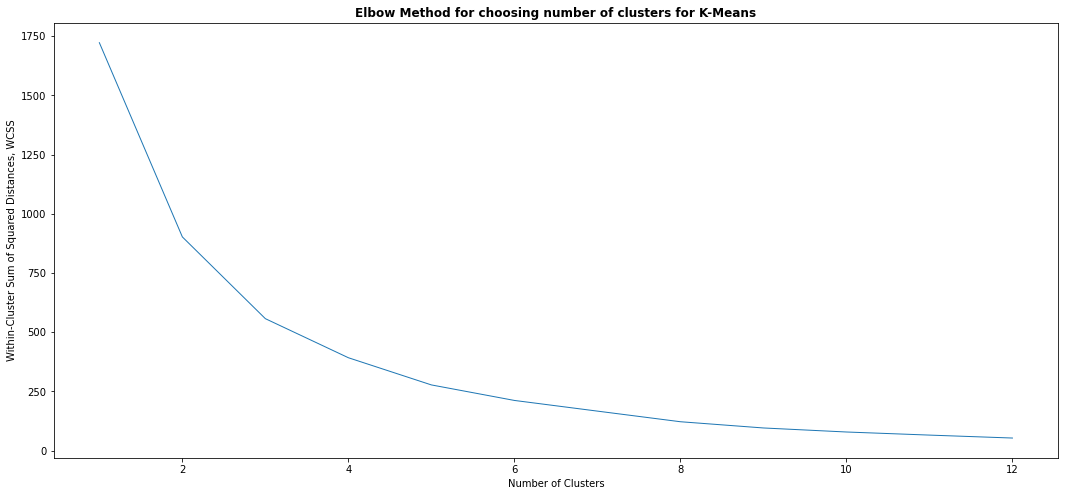


Applying the Elbow Method to the above Elbow chart, the number of clusters is determined to be 3.


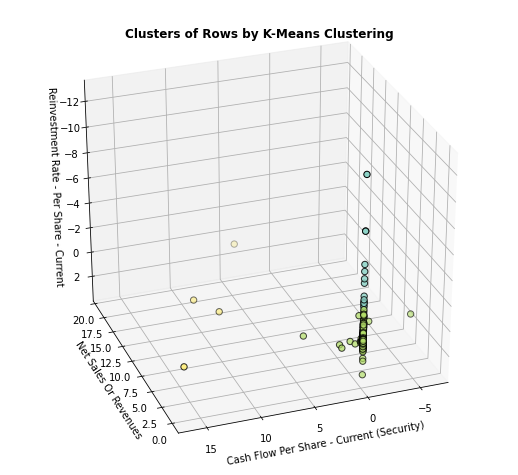

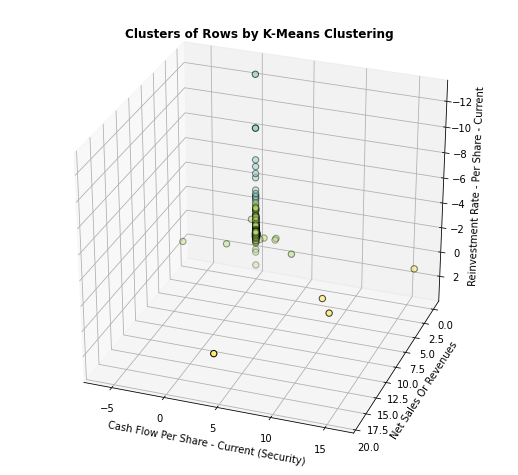


The Series cluster_mn stores the cluster memberships.

Clustering for 574 rows and 3 columns took 0.04 mins.


In [51]:
display(HTML("<style>div.output_scroll { height: 31em; }</style>"))
plt.rcParams['lines.linewidth'] = 1
stm = time.time()

df = df_cluster.copy()

scaler = StandardScaler()
df = df.drop(columns=['Company Name (Security)'], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), columns=list(df.columns))

# Produces 3-D plots
X = df.iloc[:, [2, 6, 5]]
print(X)

r = X.shape[0]
c = X.shape[1]
xname = list(X)[0]
if c > 1: 
    yname = list(X)[1]
    if c > 2:
        zname = list(X)[2]
    else:
        zname = ''
else:
    yname = ''
    zname = ''

X = X.values

# Try cluster sizes of 1 to 12
# Minimum clusters has to be increased for large datasets
minclusters = 1
maxclusters = min(12, r)

def meth(method, c):
    print('\n', f"\033[94m\033[1m", '\n' + method, 'Clustering with', c, 'X variables:', f"\033[0m", '\n')

def plelbow(m, wcss, meth, p):
    # Width and height for time-series plot
    plt.rcParams['figure.figsize'] = 18, 8
    plt.plot(range(m, len(wcss) + m), wcss)
    plt.title('Elbow Method for choosing number of clusters for ' + meth, fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of '
              + ('Manhattan' if meth == 'K-Medoids' and p == 1 else ('' if  meth == 'K-Medoids' else 'Squared'))
              + ' Distances, WCS' + ('M' if meth == 'K-Medoids' and p == 1 else ('' if  meth == 'K-Medoids' else 'S')))
    plt.show()

def plcenter(centers):
    # Plot the centroids
    plt.rcParams['figure.figsize'] = 7.000, 7.000
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c='orange', label = 'Centroids')

def pl3d(elev, azim, X, clusters, ttl, xname, yname, zname):

    fig = plt.figure(1, figsize=(7, 6.4)) #figsize=(width, height)
    
    ax = Axes3D(fig, elev=elev, azim=azim)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters, cmap=plt.cm.Set3, edgecolor='k', s=40)
    ax.set_title(ttl, fontweight='bold')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel(zname)
    
    plt.show()
    
def plclus(ncluster, clusters, type, xname, yname, zname, c):
    if c == 2 or c == 3:
        ttl = 'Clusters of Rows by ' + type + ' Clustering'
    if c == 2:
        # Plot the clusters
        plt.rcParams['figure.figsize'] = 7.000, 7.000
        for i in range(ncluster):
            color = ['red', 'green', 'blue', 'cyan', 'grey', 'gold',
                     'magenta', 'olive', 'orchid', 'brown', 'black', 'yellowgreen']
            # Dot size of 10
            plt.scatter(X[clusters==i, 0], X[clusters==i, 1], s=10, c=color[i], label ='Cluster '+str(i+1))

        plt.title(ttl, fontweight='bold')
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
    elif c == 3:
        
        pl3d(-150, 110, X, clusters, ttl, xname, yname, zname)
        
        pl3d(-150, -110, X, clusters, ttl, xname, yname, zname)
    
    clusters = pd.Series(clusters, index=df.index, name='Cluster #')
    if c == 2 or c == 3:
        print('\nThe Series cluster_' + ('mn' if type == 'K-Means' else
                                         ('md' if type == 'K-Medoids' else 'hc')) + ' stores the cluster memberships.')
    else:
        print('\nCluster memberships:')
        print(clusters)
    
    return clusters

print('\nFor K-Means and K-Medoids, results may differ across runs due to random initializations.')

# K-means clustering

# Print method header in bold blue
meth('K-Means', c)
# Use the elbow method to find out the optimal number of clusters 

# Within-cluster sum of squared distance
wcss_mn = []

# Compute WCSS
for i in range(minclusters, maxclusters+1):
    # For i clusters, without fixing random_state to a number, output will be slightly different for each run
    kmeans = KMeans(i)
    # K-means algorithm fit for the X dataset
    kmeans.fit(X)
    # kmeans.inertia_ is the sum of squared distances of rows to their closest cluster center
    wcss_mn.append(kmeans.inertia_)

# Plot the elbow graph
p = 2
plelbow(minclusters, wcss_mn, 'K-Means', p)

# According to the elbow graph we determine the clusters number as 3
ncluster_mn = 3

print('\nApplying the Elbow Method to the above Elbow chart, the number of clusters is determined to be '
      + str(ncluster_mn) + '.')

kmeans = KMeans(ncluster_mn)

# The fit_predict method will return, for each row, the cluster number it belongs to
clusters_mn = kmeans.fit_predict(X)
# cluster_centers_ has the coordinates of the centroids
centers_mn = kmeans.cluster_centers_

# Visualising the clusters
if c == 2:
    # Plot the centroids
    plcenter(centers_mn)
    
# Plot the clusters
clusters_mn = plclus(ncluster_mn, clusters_mn, 'K-Means', xname, yname, zname, c)

print('\nClustering for', r, 'rows and', c, 'columns took', '%.2f' % ((time.time() - stm) / 60), 'mins.')

### Analysis 2
#### X = Cash Flow Per Share - Current (Security)
#### Y = Net Sales Or Revenues
#### Z = Alpha (Security)

     Cash Flow Per Share - Current (Security)  Net Sales Or Revenues  \
0                                   -0.078436              -0.090821   
1                                   -0.079541              -0.090395   
2                                   -0.080784              -0.090861   
3                                   -0.082090              -0.090818   
4                                   -0.078524              -0.090651   
..                                        ...                    ...   
569                                 -0.077883              -0.090474   
570                                 -0.079365              -0.086633   
571                                 -0.080696              -0.090751   
572                                 -0.080194              -0.090824   
573                                 -0.079290              -0.090403   

     Alpha (Security)  
0           -0.150497  
1           -0.620677  
2            0.469144  
3           -0.577085  
4           -0.

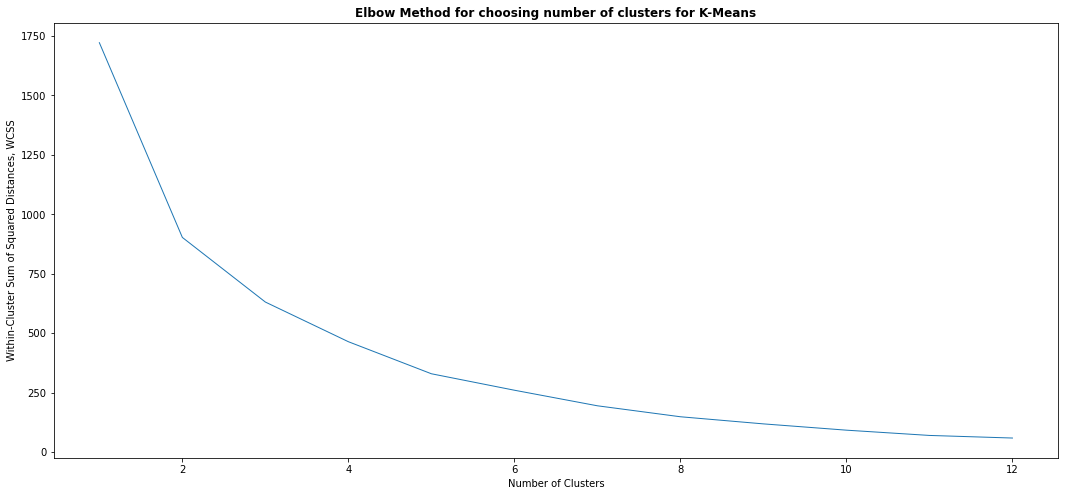


Applying the Elbow Method to the above Elbow chart, the number of clusters is determined to be 3.


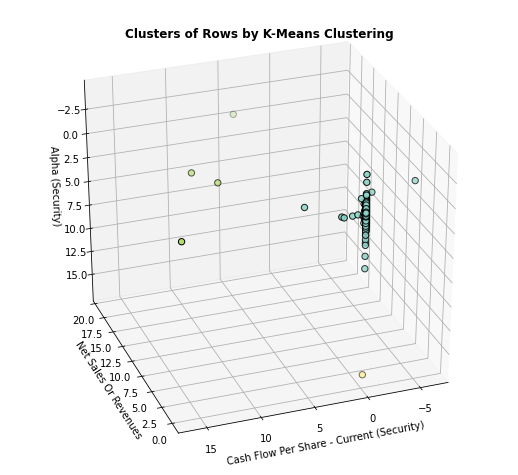

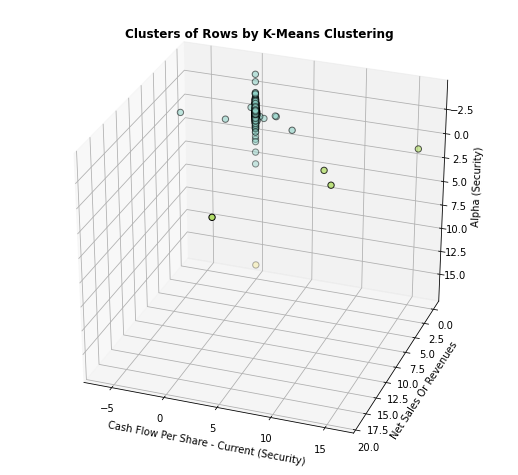


The Series cluster_mn stores the cluster memberships.

Clustering for 574 rows and 3 columns took 0.05 mins.


In [52]:
stm = time.time()

df = df_cluster.copy()

scaler = StandardScaler()
df = df.drop(columns=['Company Name (Security)'], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), columns=list(df.columns))

# Produces 3-D plots
X = df.iloc[:, [2, 6, 0]]
print(X)

r = X.shape[0]
c = X.shape[1]
xname = list(X)[0]
if c > 1: 
    yname = list(X)[1]
    if c > 2:
        zname = list(X)[2]
    else:
        zname = ''
else:
    yname = ''
    zname = ''

X = X.values

# Try cluster sizes of 1 to 12
# Minimum clusters has to be increased for large datasets
minclusters = 1
maxclusters = min(12, r)

def meth(method, c):
    print('\n', f"\033[94m\033[1m", '\n' + method, 'Clustering with', c, 'X variables:', f"\033[0m", '\n')

def plelbow(m, wcss, meth, p):
    # Width and height for time-series plot
    plt.rcParams['figure.figsize'] = 18, 8
    plt.plot(range(m, len(wcss) + m), wcss)
    plt.title('Elbow Method for choosing number of clusters for ' + meth, fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of '
              + ('Manhattan' if meth == 'K-Medoids' and p == 1 else ('' if  meth == 'K-Medoids' else 'Squared'))
              + ' Distances, WCS' + ('M' if meth == 'K-Medoids' and p == 1 else ('' if  meth == 'K-Medoids' else 'S')))
    plt.show()

def plcenter(centers):
    # Plot the centroids
    plt.rcParams['figure.figsize'] = 7.000, 7.000
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c='orange', label = 'Centroids')

def pl3d(elev, azim, X, clusters, ttl, xname, yname, zname):

    fig = plt.figure(1, figsize=(7, 6.4)) #figsize=(width, height)
    
    ax = Axes3D(fig, elev=elev, azim=azim)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters, cmap=plt.cm.Set3, edgecolor='k', s=40)
    ax.set_title(ttl, fontweight='bold')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel(zname)
    
    plt.show()
    
def plclus(ncluster, clusters, type, xname, yname, zname, c):
    if c == 2 or c == 3:
        ttl = 'Clusters of Rows by ' + type + ' Clustering'
    if c == 2:
        # Plot the clusters
        plt.rcParams['figure.figsize'] = 7.000, 7.000
        for i in range(ncluster):
            color = ['red', 'green', 'blue', 'cyan', 'grey', 'gold',
                     'magenta', 'olive', 'orchid', 'brown', 'black', 'yellowgreen']
            # Dot size of 10
            plt.scatter(X[clusters==i, 0], X[clusters==i, 1], s=10, c=color[i], label ='Cluster '+str(i+1))

        plt.title(ttl, fontweight='bold')
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.show()
    elif c == 3:
        
        pl3d(-150, 110, X, clusters, ttl, xname, yname, zname)
        
        pl3d(-150, -110, X, clusters, ttl, xname, yname, zname)
    
    clusters = pd.Series(clusters, index=df.index, name='Cluster #')
    if c == 2 or c == 3:
        print('\nThe Series cluster_' + ('mn' if type == 'K-Means' else
                                         ('md' if type == 'K-Medoids' else 'hc')) + ' stores the cluster memberships.')
    else:
        print('\nCluster memberships:')
        print(clusters)
    
    return clusters

print('\nFor K-Means and K-Medoids, results may differ across runs due to random initializations.')

# K-means clustering

# Print method header in bold blue
meth('K-Means', c)
# Use the elbow method to find out the optimal number of clusters 

# Within-cluster sum of squared distance
wcss_mn = []

# Compute WCSS
for i in range(minclusters, maxclusters+1):
    # For i clusters, without fixing random_state to a number, output will be slightly different for each run
    kmeans = KMeans(i)
    # K-means algorithm fit for the X dataset
    kmeans.fit(X)
    # kmeans.inertia_ is the sum of squared distances of rows to their closest cluster center
    wcss_mn.append(kmeans.inertia_)

# Plot the elbow graph
p = 2
plelbow(minclusters, wcss_mn, 'K-Means', p)

# According to the elbow graph we determine the clusters number as 3
ncluster_mn = 3

print('\nApplying the Elbow Method to the above Elbow chart, the number of clusters is determined to be '
      + str(ncluster_mn) + '.')

kmeans = KMeans(ncluster_mn)

# The fit_predict method will return, for each row, the cluster number it belongs to
clusters_mn = kmeans.fit_predict(X)
# cluster_centers_ has the coordinates of the centroids
centers_mn = kmeans.cluster_centers_

# Visualising the clusters
if c == 2:
    # Plot the centroids
    plcenter(centers_mn)
    
# Plot the clusters
clusters_mn = plclus(ncluster_mn, clusters_mn, 'K-Means', xname, yname, zname, c)

print('\nClustering for', r, 'rows and', c, 'columns took', '%.2f' % ((time.time() - stm) / 60), 'mins.')

### Analysis 3

#### X = Reinvestment Rate - Per Share - Current
#### Y = Cash Flow Per Share - Current (Security)

     Reinvestment Rate - Per Share - Current  \
0                                   1.021870   
1                                   0.055548   
2                                   0.051432   
3                                  -0.092391   
4                                   0.413893   
..                                       ...   
569                                 0.182422   
570                                 0.134965   
571                                -1.804216   
572                                 0.141018   
573                                 0.265228   

     Cash Flow Per Share - Current (Security)  
0                                   -0.078436  
1                                   -0.079541  
2                                   -0.080784  
3                                   -0.082090  
4                                   -0.078524  
..                                        ...  
569                                 -0.077883  
570                                 -0.

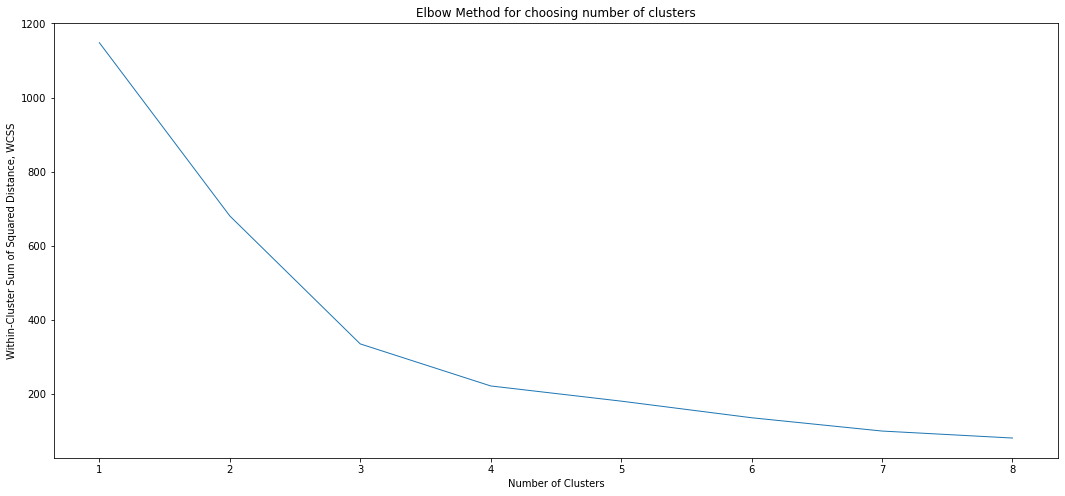


From the elbow method, the number of clusters is determined to be 3.


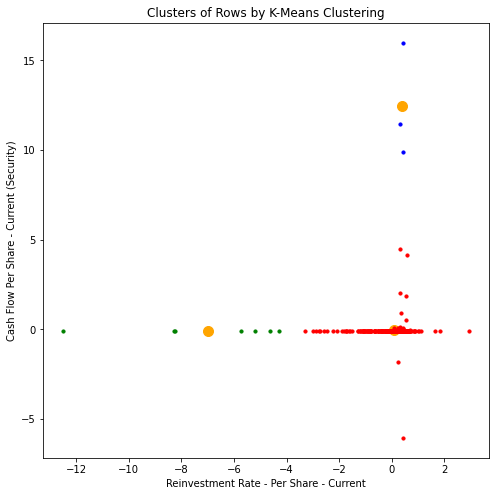

In [53]:
dataset = df_cluster.copy()

scaler = StandardScaler()
dataset = dataset.drop(columns=['Company Name (Security)'], axis=1)
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=list(dataset.columns))

X = dataset.iloc[:, [5, 2]]
xname = list(X)[0]
yname = list(X)[1]
print(X)
X = X.values

# K-means clustering
print('\n\nK-Means Clustering:\n')

# Step 1: Use the elbow method to find out the optimal number of clusters

# Try 10 clusters
maxclusters = 10
# Within-cluster sum of squared distance
wcss=[]

# Compute WCSS
for i in range(1, maxclusters-1):
    # For i clusters, without fixing random_state to a number, output will be slightly different for each run
    kmeans = KMeans(i, random_state=0)  
    # K-means algorithm fit for the X dataset
    kmeans.fit(X)
    # kmeans.inertia_ is the sum of squared distances of rows to their closest cluster center
    wcss.append(kmeans.inertia_)

# Step 2: Plot the elbow graph

# Width and height for time-series plot
plt.rcParams['figure.figsize'] = 18, 8
plt.plot(range(1, maxclusters-1), wcss)
plt.title('Elbow Method for choosing number of clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squared Distance, WCSS')
plt.show()

# Step 3: According to the elbow graph we determine the clusters number as 3

ncluster = 3
print('\nFrom the elbow method, the number of clusters is determined to be ' + str(ncluster) + '.')

kmeans = KMeans(ncluster, random_state=0)

# Method of fit_predict will return, for each row, the cluster number it belongs to
y_kmeans = kmeans.fit_predict(X)

# Step 4: Visualising the clusters

plt.rcParams['figure.figsize'] = 8.000, 8.000
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='orange', label = 'Centroids')
plt.title('Clusters of Rows by K-Means Clustering')
plt.xlabel(xname)
plt.ylabel(yname)

# Plot the clusters
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=10, c='magenta', label ='Cluster 5')
plt.show()

### Analysis 4

#### X = Alpha (Security)
#### Y = Net Sales Or Revenues

     Alpha (Security)  Net Sales Or Revenues
0           -0.150497              -0.090821
1           -0.620677              -0.090395
2            0.469144              -0.090861
3           -0.577085              -0.090818
4           -0.458761              -0.090651
..                ...                    ...
569         -0.097563              -0.090474
570         -0.256366              -0.086633
571         -0.608222              -0.090751
572         -0.256366              -0.090824
573         -0.162952              -0.090403

[574 rows x 2 columns]


K-Means Clustering:



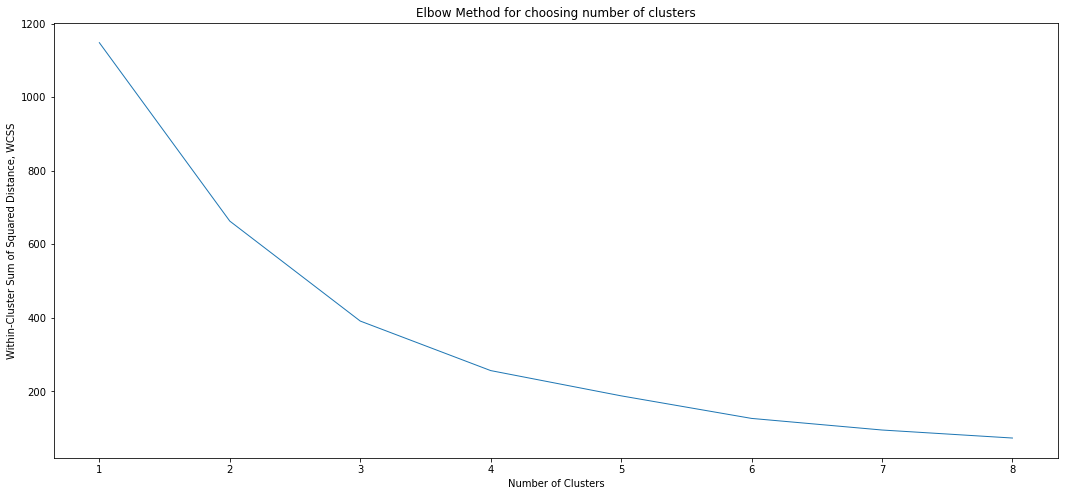


From the elbow method, the number of clusters is determined to be 3.


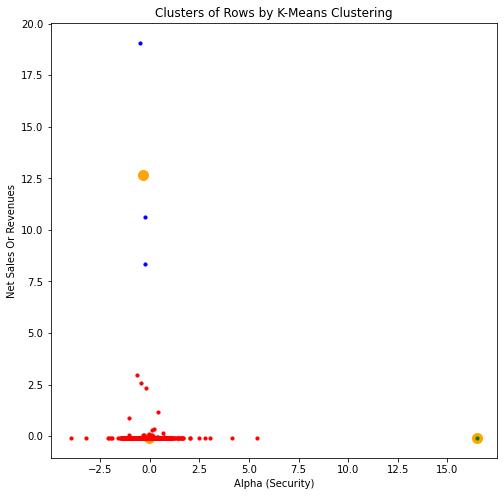

In [54]:
dataset = df_cluster.copy()

scaler = StandardScaler()
dataset = dataset.drop(columns=['Company Name (Security)'], axis=1)
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=list(dataset.columns))

X = dataset.iloc[:, [0, 6]]
xname = list(X)[0]
yname = list(X)[1]
print(X)
X = X.values

# K-means clustering
print('\n\nK-Means Clustering:\n')

# Step 1: Use the elbow method to find out the optimal number of clusters

# Try 10 clusters
maxclusters = 10
# Within-cluster sum of squared distance
wcss=[]

# Compute WCSS
for i in range(1, maxclusters-1):
    # For i clusters, without fixing random_state to a number, output will be slightly different for each run
    kmeans = KMeans(i, random_state=0)  
    # K-means algorithm fit for the X dataset
    kmeans.fit(X)
    # kmeans.inertia_ is the sum of squared distances of rows to their closest cluster center
    wcss.append(kmeans.inertia_)

# Step 2: Plot the elbow graph

# Width and height for time-series plot
plt.rcParams['figure.figsize'] = 18, 8
plt.plot(range(1, maxclusters-1), wcss)
plt.title('Elbow Method for choosing number of clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squared Distance, WCSS')
plt.show()

# Step 3: According to the elbow graph we determine the clusters number as 3

ncluster = 3
print('\nFrom the elbow method, the number of clusters is determined to be ' + str(ncluster) + '.')

kmeans = KMeans(ncluster, random_state=0)

# Method of fit_predict will return, for each row, the cluster number it belongs to
y_kmeans = kmeans.fit_predict(X)

# Step 4: Visualising the clusters

plt.rcParams['figure.figsize'] = 8.000, 8.000
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='orange', label = 'Centroids')
plt.title('Clusters of Rows by K-Means Clustering')
plt.xlabel(xname)
plt.ylabel(yname)

# Plot the clusters
plt.scatter(X[y_kmeans==0, 0], X[y_kmeans==0, 1], s=10, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1, 0], X[y_kmeans==1, 1], s=10, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2, 0], X[y_kmeans==2, 1], s=10, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3, 0], X[y_kmeans==3, 1], s=10, c='cyan', label ='Cluster 4')
plt.scatter(X[y_kmeans==4, 0], X[y_kmeans==4, 1], s=10, c='magenta', label ='Cluster 5')
plt.show()

In [55]:
print('Total Notebook Runtime:', round((time.time()-master_tm)/60,2) , 'mins')

Total Notebook Runtime: 25.82 mins
